## FHC + RHC background subtracted event rate & uncertainties

In [1]:
ISOLD = False

isClosureTest = True 

isNuWro = True

ISRUN3 = "" # Leaving empty sets to combined

cut_level = ""

In [2]:
import sys

sys.path.insert(0, 'backend_functions')

import selection_functions as sf

import importlib

import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb

# This is our configuration file, cfg.py, which contains the variable names and binning information. 
import cfg
from cfg import * 

import awkward
import matplotlib.pyplot as plt
import pandas as pd

import ROOT

import top 
from top import *

import uncertainty_functions 
from uncertainty_functions import *

import xsec_functions 
from xsec_functions import smear_matrix

from ROOT import TH1D, TH2D, TDirectory, TH1F, TH2F, TMatrixD

importlib.reload(sf)
from selection_functions import *

Welcome to JupyROOT 6.26/10


In [3]:
import io
import json
import os
from datetime import date

In [4]:
# Choose your variable!
# Variables = "Opening Angle", "Proton Multiplicity", "Electron Energy", "Visible Energy"
name_of_variable = "Electron Energy" 
xvar, true_var, bins, xlow, xhigh, x_label, x_ticks = get_variable_info(name_of_variable, ISRUN3, cut_level)

From cfg.py...
Variable definition: Electron Energy
Reconstructed variable = shr_energy_cali
True variable = elec_e
Bins = [0.02, 0.22, 0.42, 0.62, 0.82, 1.22, 7.0]
Lowest x-value on plot = 0.02
Highest x-value on plot = 2.5
x-axis title = Electron Energy [GeV]
x-axis labels = [0.02, 0.22, 0.42, 0.62, 0.82, 1.22]


In [5]:
if xvar=='tksh_angle': 
    bincenters = 0.5*(np.array(x_ticks)[1:]+np.array(x_ticks)[:-1])

else: 
    #bincenters = 0.5*(np.array(x_ticks+[xhigh])[1:]+np.array(x_ticks+[xhigh])[:-1])
    bincenters = 0.5*(np.array(bins[:-1]+[xhigh])[1:]+np.array(bins[:-1]+[xhigh])[:-1])
    

In [6]:
# Path for loading in files from uncertainty.ipynb

if isNuWro:
    # Files for NuWro
    with open('unfolding/variations/FHCVariations_'+xvar+'_021225.json') as f_fhc:
        fhc_dict = json.load(f_fhc)
    with open('unfolding/variations/FHCVariations_'+xvar+'_021225.json') as f_rhc:
        rhc_dict = json.load(f_rhc)

else:
    # Old/new Run 1 file
    with open('unfolding/variations/FHCVariations_'+xvar+'_021225.json') as f_fhc:
        fhc_dict = json.load(f_fhc)
    # Old/new Run 3 file
    with open('unfolding/variations/FHCVariations_'+xvar+'_021225.json') as f_rhc:
        rhc_dict = json.load(f_rhc)

In [7]:
binwidth = []

for x in range(len(bincenters)): 
    #binwidth.append(round(abs((x_ticks+[xhigh])[x+1]-(x_ticks+[xhigh])[x])/2, 2))  
    binwidth.append(round(abs((bins[:-1]+[xhigh])[x+1]-(bins[:-1]+[xhigh])[x])/2, 3))  
    
binwidth

[0.1, 0.1, 0.1, 0.1, 0.2, 0.64]

## PPFX

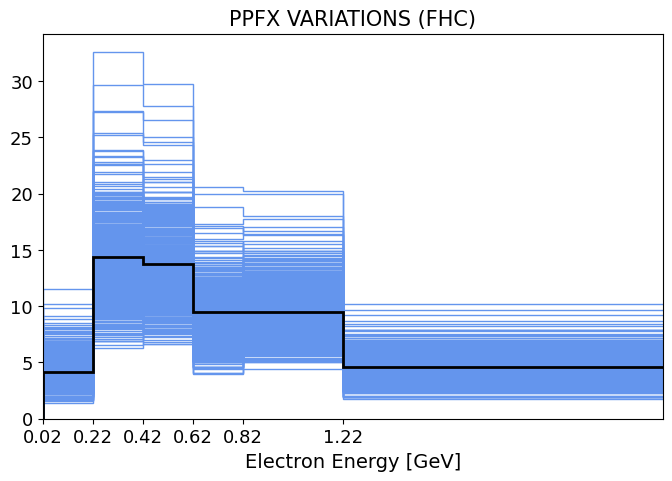

In [8]:
fig = plt.figure(figsize=(8, 5)) 

for v in fhc_dict['ppfx']: 
    #print(v)
    #print(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]))
    
    plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=v,
        histtype='step', color='cornflowerblue', linewidth=1)

plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=fhc_dict['evt_rate'],
        histtype='step', color='black', linewidth=2)    

plt.xlim(xlow, xhigh)
plt.title("PPFX VARIATIONS (FHC)", fontsize=15)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel(x_label, fontsize=14)

plt.show()

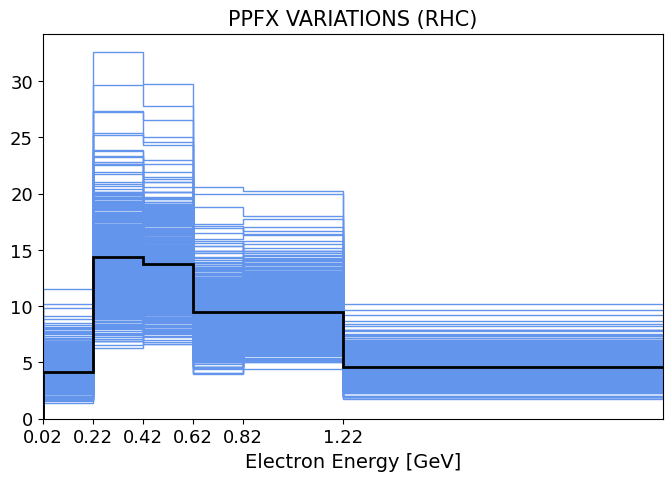

In [9]:
fig = plt.figure(figsize=(8, 5)) 

for v in rhc_dict['ppfx']: 
    
    plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=v,
        histtype='step', color='cornflowerblue', linewidth=1)

plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=rhc_dict['evt_rate'],
        histtype='step', color='black', linewidth=2) 
    
plt.xlim(xlow, xhigh)
plt.title("PPFX VARIATIONS (RHC)", fontsize=15)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel(x_label, fontsize=14)
plt.show()

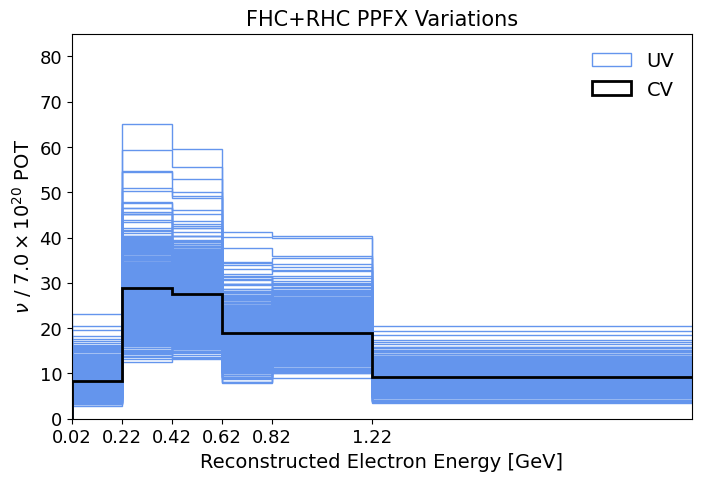

In [10]:
ppfx_variations = []

fig = plt.figure(figsize=(8, 5)) 

n = 0

for v_fhc, v_rhc in zip(fhc_dict['ppfx'], rhc_dict['ppfx']): 
    
    comb_v = [a+b for a,b in zip(v_fhc,v_rhc)]
    ppfx_variations.append(comb_v)
    
    if n==0: 
        plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
            histtype='step', color='cornflowerblue', linewidth=1, label='UV')
    else: 
        plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
            histtype='step', color='cornflowerblue', linewidth=1)
        
    
    n+=1

plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, 
        weights=[a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])],
        histtype='step', color='black', linewidth=2, label='CV') 
    
plt.xlim(xlow, xhigh)
plt.ylim(0, 85)
plt.title("FHC+RHC PPFX Variations", fontsize=15)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(fontsize=14, frameon=False)

plt.xlabel('Reconstructed '+x_label, fontsize=14)
plt.ylabel('$\\nu$ / $7.0 \\times 10^{20}$ POT' , fontsize=14)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/ppfx_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

In [11]:
fhc_ppfx_dict = calcCov(xvar, bins, fhc_dict['evt_rate'], fhc_dict['evt_rate'], 
                    fhc_dict['ppfx'], plot=False, 
                    save=False, xticks=x_ticks, xhigh=xhigh) 

number of universes =  600


In [12]:
rhc_ppfx_dict = calcCov(xvar, bins, rhc_dict['evt_rate'], rhc_dict['evt_rate'], 
                    rhc_dict['ppfx'], plot=False,  save=False, xticks=x_ticks, xhigh=xhigh) 

number of universes =  600


number of universes =  600


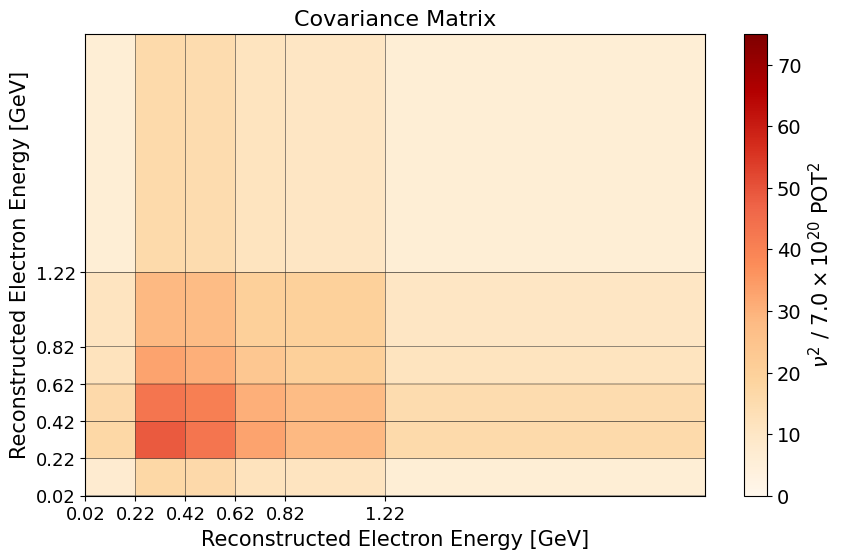

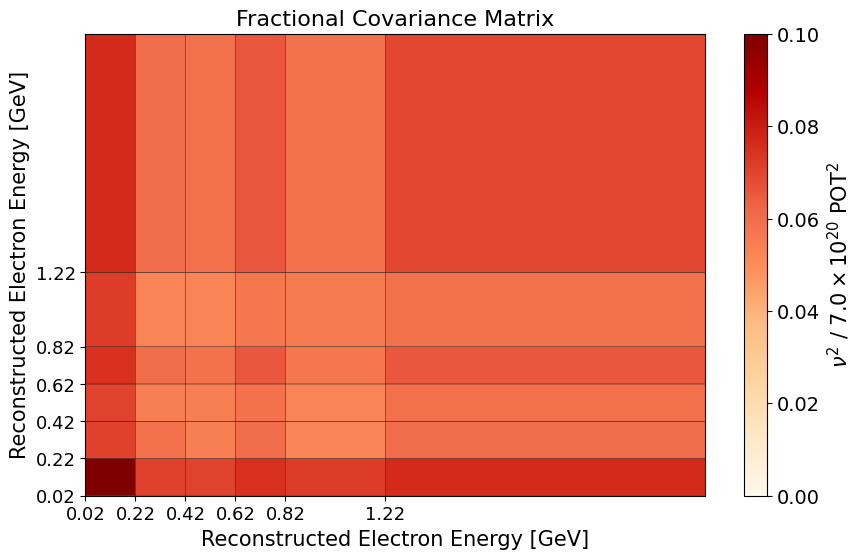

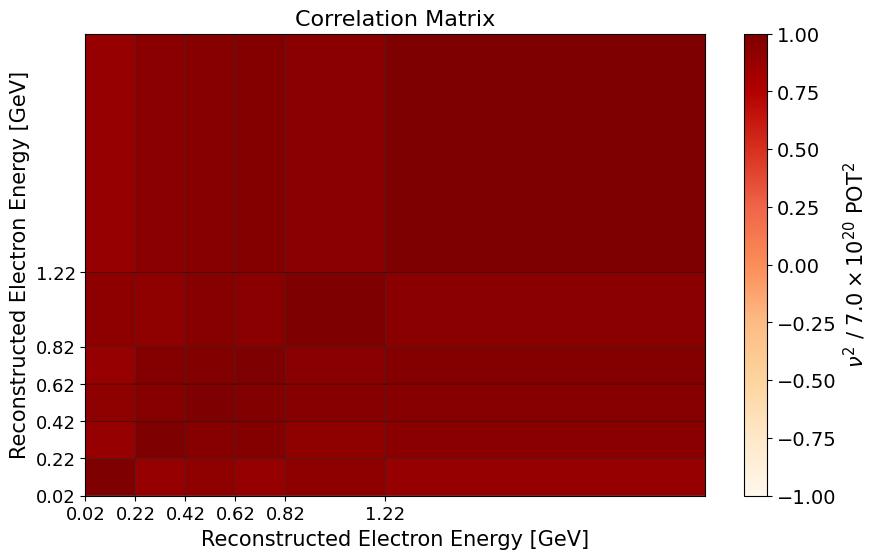

In [13]:
## calculate covariance 

ppfx_dict = calcCov(xvar, bins, [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
                    [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
                    ppfx_variations, plot=True, xticks=x_ticks, xhigh=xhigh, 
                    axis_label='Reconstructed '+x_label, pot='$7.0 \\times 10^{20}$ POT') 
                    #save="/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/ppfx_") 

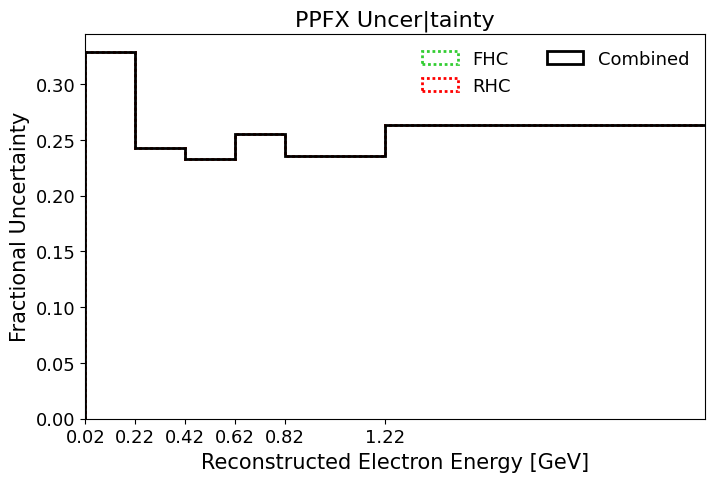

In [14]:
fig = plt.figure(figsize=(8, 5))  

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC", 
         weights=fhc_ppfx_dict['fractional_uncertainty'], linestyle=(0, (1, 1)), linewidth=2, color='limegreen')
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="RHC", 
         weights=rhc_ppfx_dict['fractional_uncertainty'], linestyle=(0, (1, 1)), color='red', linewidth=2)

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Combined", 
         weights=ppfx_dict['fractional_uncertainty'], color='black', linewidth=2)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)


plt.legend(fontsize=13, frameon=False, ncol=2)
plt.title("PPFX Uncer|tainty", fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/ppfx_"+xvar+"_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

In [15]:
[round(x*100,1) for x in ppfx_dict['fractional_uncertainty']]

[32.9, 24.3, 23.3, 25.6, 23.6, 26.4]

## Beamline Geometry 

In [16]:
beamline_runs = ['HornCurrent', 'xHorn1', 'yHorn1', 'BeamSpotSize', 'xHorn2', 'yHorn2', 'WaterOnHorns', 
                'xBeamShift', 'yBeamShift', 'zTargetPosition']

HornCurrent


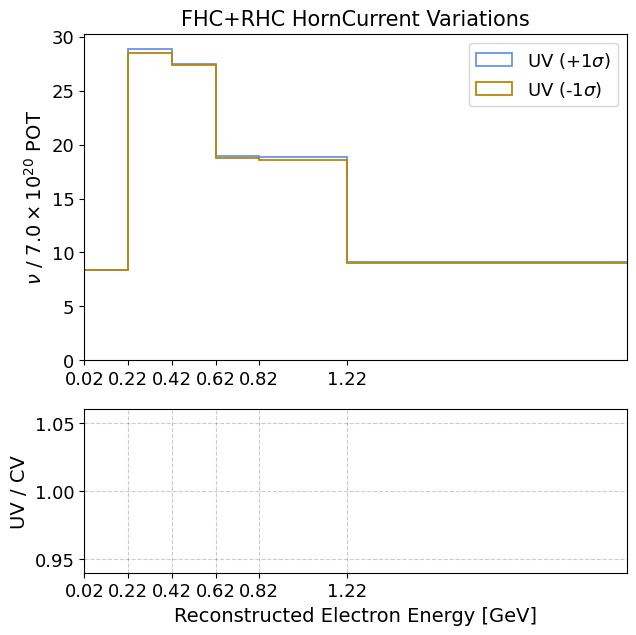

number of universes =  2
number of universes =  2
number of universes =  2
xHorn1


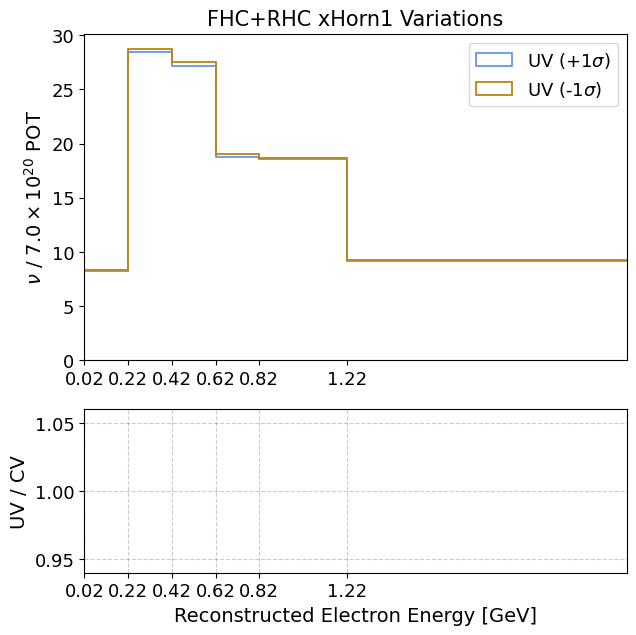

number of universes =  2
number of universes =  2
number of universes =  2
yHorn1


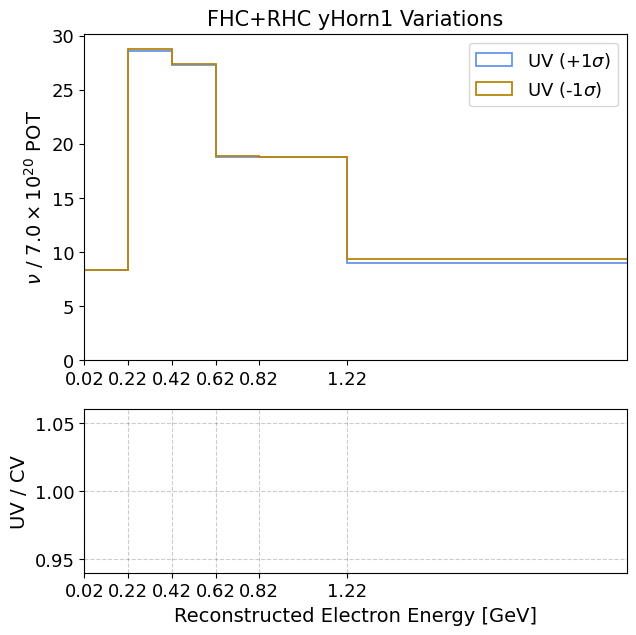

number of universes =  2
number of universes =  2
number of universes =  2
BeamSpotSize


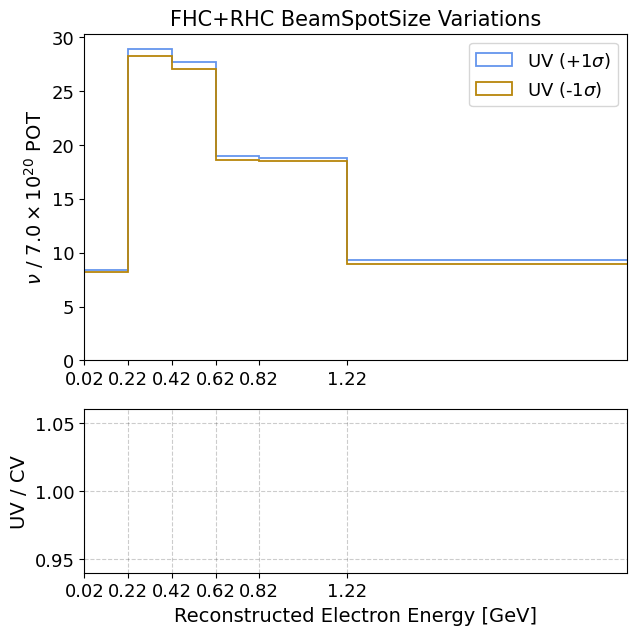

number of universes =  2
number of universes =  2
number of universes =  2
xHorn2


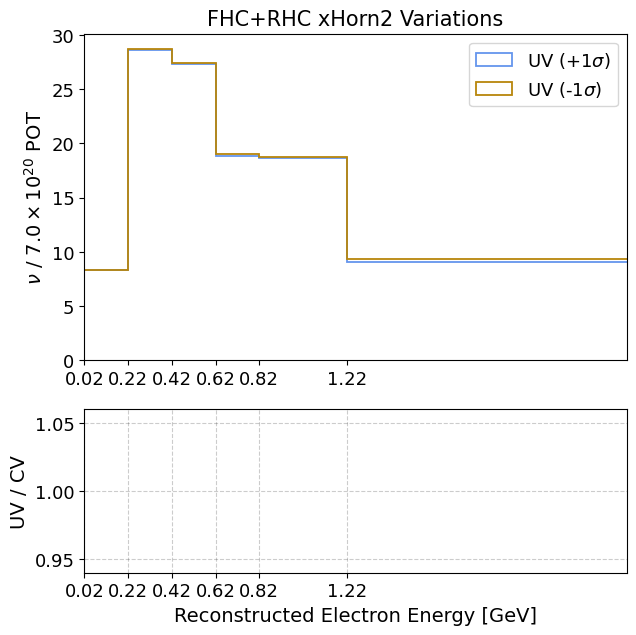

number of universes =  2
number of universes =  2
number of universes =  2
yHorn2


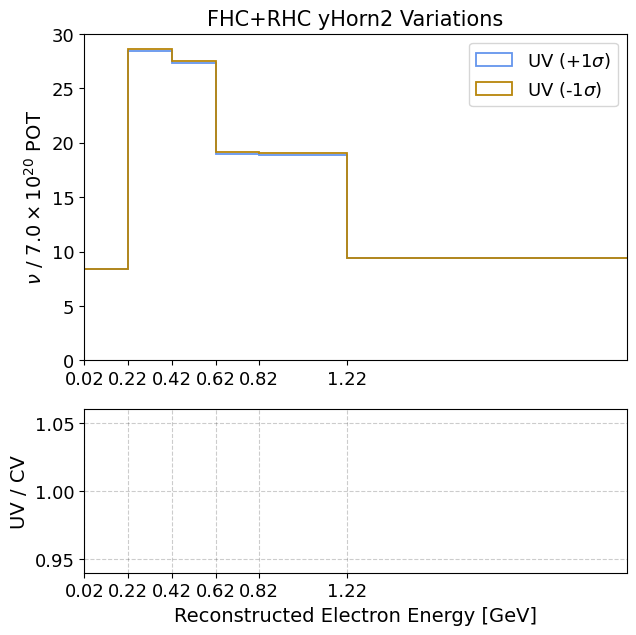

number of universes =  2
number of universes =  2
number of universes =  2
WaterOnHorns


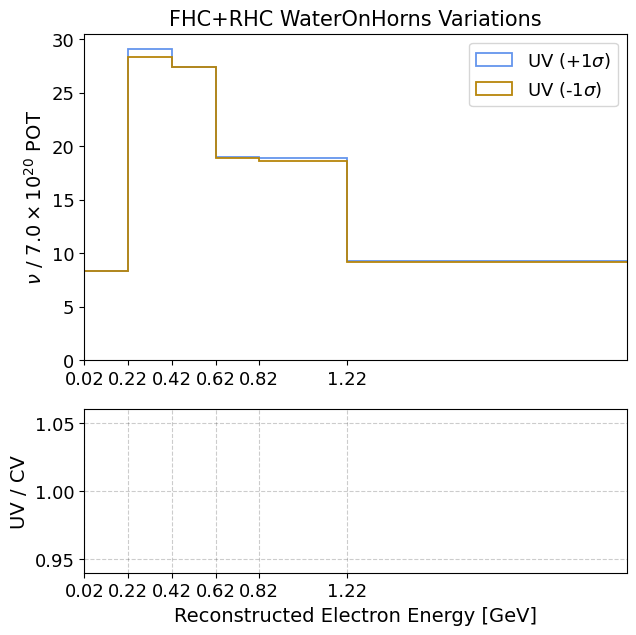

number of universes =  2
number of universes =  2
number of universes =  2
xBeamShift


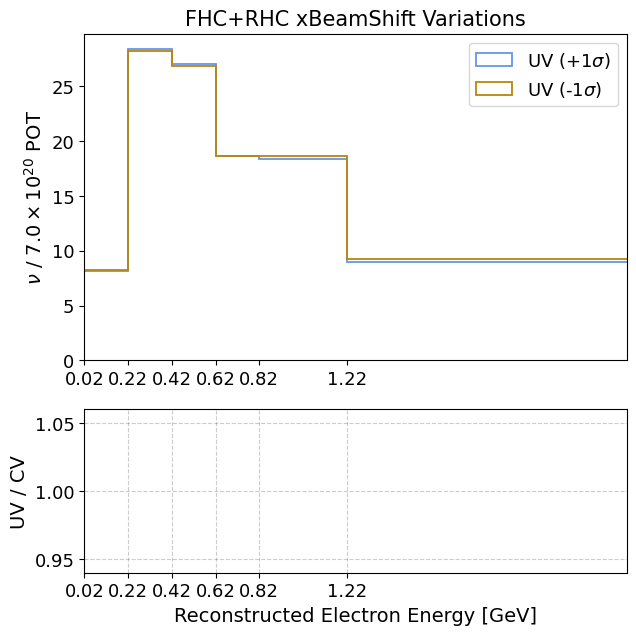

number of universes =  2
number of universes =  2
number of universes =  2
yBeamShift


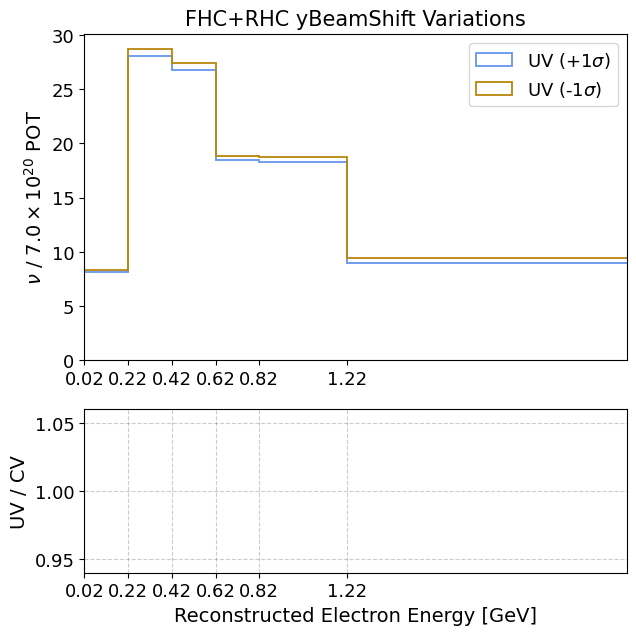

number of universes =  2
number of universes =  2
number of universes =  2
zTargetPosition


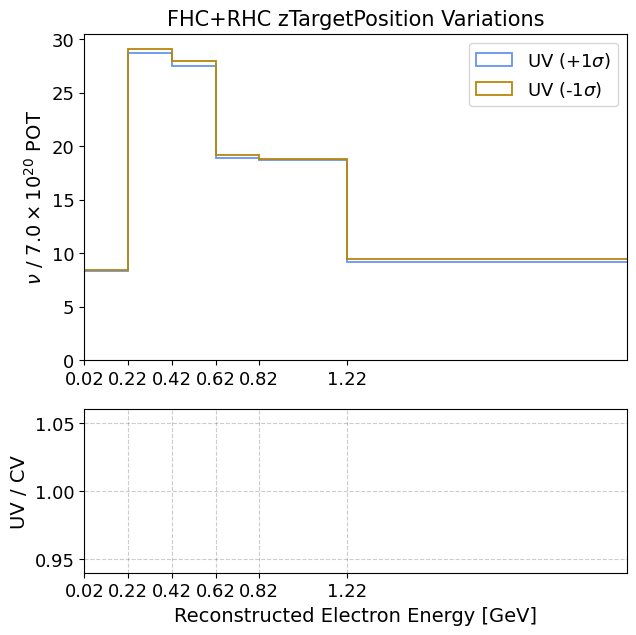

number of universes =  2
number of universes =  2
number of universes =  2


In [17]:
fhc_beamline_unisim_cov = {}
rhc_beamline_unisim_cov = {}
beamline_unisim_cov = {}

i = 0

for v_fhc, v_rhc in zip(fhc_dict['beamline'], rhc_dict['beamline']): 
    
    print(beamline_runs[i])
    
    variations = []
    
    comb_v = [a+b for a,b in zip(v_fhc[0],v_rhc[0])]
    comb_v2 = [a+b for a,b in zip(v_fhc[1],v_rhc[1])]
    
    variations.append(comb_v)
    variations.append(comb_v2)
    
    fig = plt.figure(figsize=(7, 7)) 
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 13)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 13)
    
    #ax1.errorbar(bincenters, [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
    #            color='black', label="CV", xerr=binwidth, linestyle='None')

    ax1.hist(bincenters, bins, weights=comb_v, linewidth=1.3, 
        histtype='step', color='cornflowerblue', label='UV (+$1\sigma$)')
    
    ax1.hist(bincenters, bins, weights=comb_v2, linewidth=1.3, 
            histtype='step', color='darkgoldenrod', label='UV (-$1\sigma$)')
    
    # Ratios to CV 
    #ax2.hist(bincenters, bins,
    #         weights=[x/y for x,y in zip(comb_v, [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])])], 
    #         color="cornflowerblue", histtype='step', linewidth=1.3)
    
    #ax2.hist(bincenters, bins,
    #         weights=[x/y for x,y in zip(comb_v2, [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])])], 
    #         color="darkgoldenrod", histtype='step', linewidth=1.3)
    
    ax1.set_xlim(xlow, xhigh)
    ax1.set_title("FHC+RHC "+beamline_runs[i]+" Variations", fontsize=15)
    ax1.set_xticks(x_ticks)
    
    ax1.set_ylabel('$\\nu$ / $7.0 \\times 10^{20}$ POT' , fontsize=14)
    ax1.legend(fontsize=13)
    
    ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
    ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)

    ax2.set_xlabel('Reconstructed '+x_label, fontsize=14)
    ax2.set_ylabel('UV / CV', fontsize=14)
    ax2.set_xlim(xlow, xhigh)
    ax2.set_ylim(0.94, 1.06)
    ax2.set_xticks(x_ticks)
    
    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/beamline_"+beamline_runs[i]+"_"+xvar+".pdf", 
    #        transparent=True, bbox_inches='tight')
    
    plt.show()
    
    # compute unisim covariance
    
    fhc_beamline_unisim_cov[beamline_runs[i]] = calcCov(xvar, bins, 
                                                    fhc_dict['evt_rate'], fhc_dict['evt_rate'], 
                                                    v_fhc, plot=False)
    
    rhc_beamline_unisim_cov[beamline_runs[i]] = calcCov(xvar, bins, 
                                                    rhc_dict['evt_rate'], rhc_dict['evt_rate'], 
                                                    v_rhc, plot=False)
    
    beamline_unisim_cov[beamline_runs[i]] = calcCov(xvar, bins, 
                                                    [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
                                                    [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
                                                    variations, plot=False)
    

    i += 1

In [18]:
for k,d in enumerate([fhc_beamline_unisim_cov, rhc_beamline_unisim_cov, beamline_unisim_cov]): 
    
    cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    
    for variation in d.keys(): 

        for i in range(len(bins)-1): 
            for j in range(len(bins)-1):

                cov[i][j] += d[variation]['cov'][i][j]
                frac_cov[i][j] += d[variation]['frac_cov'][i][j] 


    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                    cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
        
    if k==0: 
        
        fhc_beamline_unisim_dict = {
            'cov' : cov, 
            'frac_cov' : frac_cov,
            'cor' : cor,
            'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
        } 
        
        
    elif k==1: 
        rhc_beamline_unisim_dict = {
            'cov' : cov, 
            'frac_cov' : frac_cov,
            'cor' : cor,
            'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
        } 
        
    elif k==2: 
        beamline_unisim_dict = {
            'cov' : cov, 
            'frac_cov' : frac_cov,
            'cor' : cor,
            'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
        } 


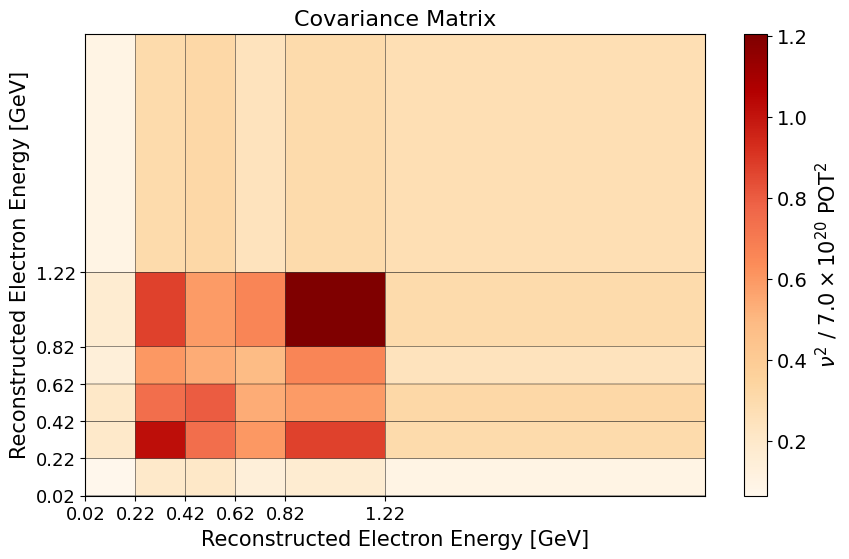

In [19]:
fig = plt.figure(figsize=(10, 6))

plt.pcolor(bins, bins, beamline_unisim_dict['cov'], cmap='OrRd', edgecolors='k')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
     
plt.xlabel("Reconstructed "+x_label, fontsize=15)
plt.ylabel("Reconstructed "+x_label, fontsize=15)

cbar.set_label(label='$\\nu^{2}$ / $7.0 \\times 10^{20}$ POT$^{2}$', fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(bins[0], xhigh)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(x_ticks,fontsize=13)

plt.title('Covariance Matrix', fontsize=16)
#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/beamline_"+xvar+"_cov.pdf", 
#            transparent=True, bbox_inches='tight')
plt.show()

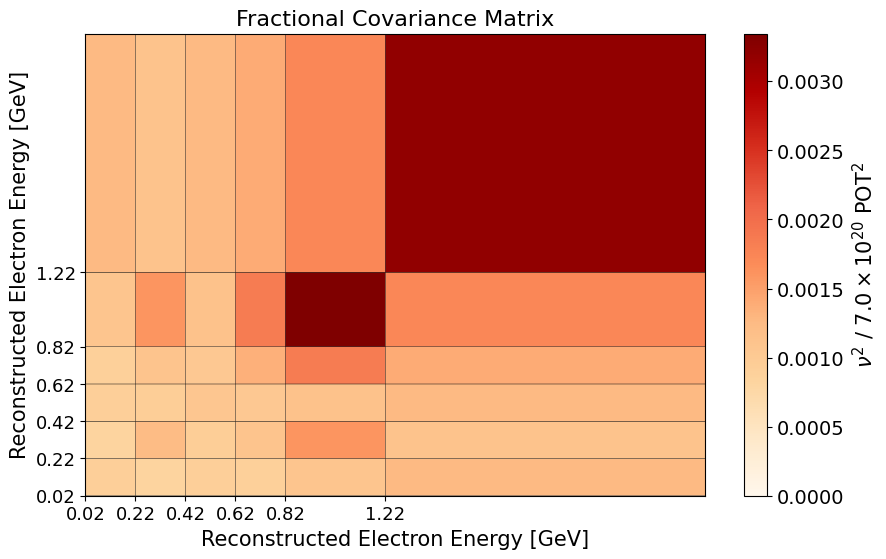

In [20]:
fig = plt.figure(figsize=(10, 6))

plt.pcolor(bins, bins, beamline_unisim_dict['frac_cov'], cmap='OrRd', edgecolors='k', vmin=0)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
     
plt.xlabel("Reconstructed "+x_label, fontsize=15)
plt.ylabel("Reconstructed "+x_label, fontsize=15)

cbar.set_label(label='$\\nu^{2}$ / $7.0 \\times 10^{20}$ POT$^{2}$', fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(bins[0], xhigh)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(x_ticks,fontsize=13)

plt.title('Fractional Covariance Matrix', fontsize=16)
#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/beamline_"+xvar+"_frac_cov.pdf", 
#            transparent=True, bbox_inches='tight')
plt.show()

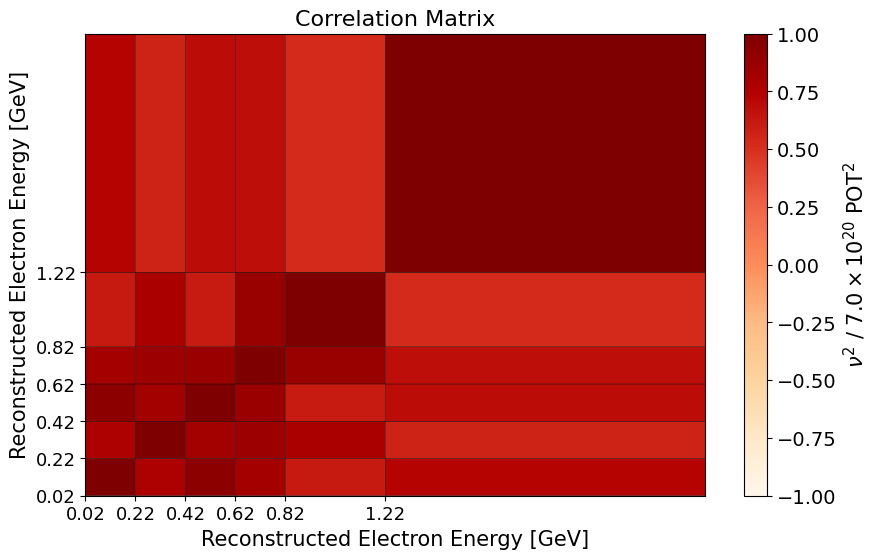

In [21]:
fig = plt.figure(figsize=(10, 6))

plt.pcolor(bins, bins, beamline_unisim_dict['cor'], cmap='OrRd', edgecolors='k', vmin=-1, vmax=1)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
     
plt.xlabel("Reconstructed "+x_label, fontsize=15)
plt.ylabel("Reconstructed "+x_label, fontsize=15)

cbar.set_label(label='$\\nu^{2}$ / $7.0 \\times 10^{20}$ POT$^{2}$', fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(bins[0], xhigh)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(x_ticks,fontsize=13)

plt.title('Correlation Matrix', fontsize=16)
#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/beamline_"+xvar+"_cor.pdf", 
#            transparent=True, bbox_inches='tight')
plt.show()

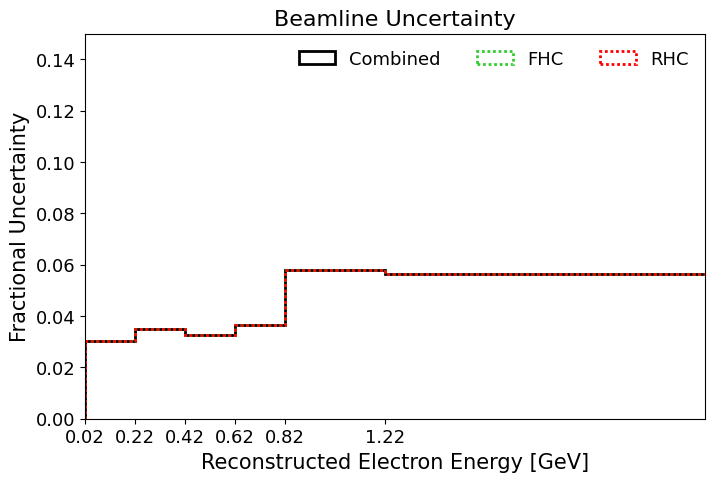

In [22]:
fig = plt.figure(figsize=(8, 5))  


plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Combined", 
         weights=beamline_unisim_dict['fractional_uncertainty'], color='black', linewidth=2)

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC", 
         weights=fhc_beamline_unisim_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), linewidth=2, color='limegreen')
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="RHC", 
         weights=rhc_beamline_unisim_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), color='red', linewidth=2)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 0.15)

plt.legend(fontsize=13, frameon=False, ncol=3)
plt.title("Beamline Uncertainty", fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/beamline_"+xvar+"_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

## GENIE ms

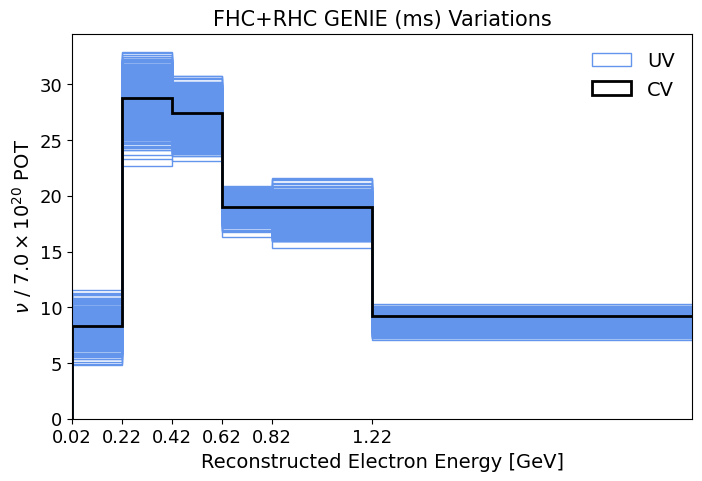

In [23]:
genie_variations = []

fig = plt.figure(figsize=(8, 5)) 

n = 0

for v_fhc, v_rhc in zip(fhc_dict['genie_ms'], rhc_dict['genie_ms']): 
    
    comb_v = [a+b for a,b in zip(v_fhc,v_rhc)]
    genie_variations.append(comb_v)
    
    if n==0: 
        plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
            histtype='step', color='cornflowerblue', linewidth=1, label='UV')
    else: 
        plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
            histtype='step', color='cornflowerblue', linewidth=1)
        
    n+=1

plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, 
        weights=[a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])],
        histtype='step', color='black', linewidth=2, label='CV') 
    
plt.xlim(xlow, xhigh)
plt.title("FHC+RHC GENIE (ms) Variations", fontsize=15)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(fontsize=14, frameon=False)

plt.xlabel('Reconstructed '+x_label, fontsize=14)
plt.ylabel('$\\nu$ / $7.0 \\times 10^{20}$ POT' , fontsize=14)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/genie_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

In [24]:
fhc_genie_dict = calcCov(xvar, bins, fhc_dict['evt_rate'], fhc_dict['evt_rate'], 
                    fhc_dict['genie_ms'], plot=False) 

rhc_genie_dict = calcCov(xvar, bins, rhc_dict['evt_rate'], rhc_dict['evt_rate'], 
                    rhc_dict['genie_ms'], plot=False) 

number of universes =  600
number of universes =  600


number of universes =  600


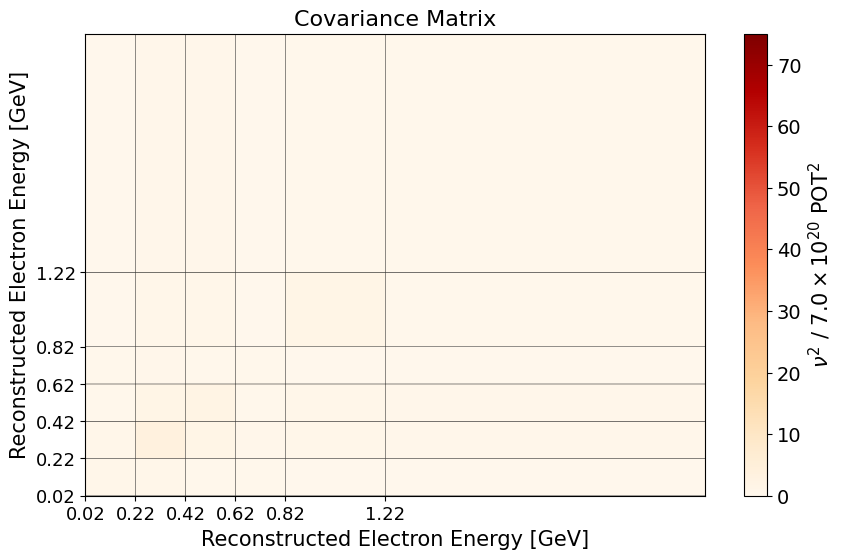

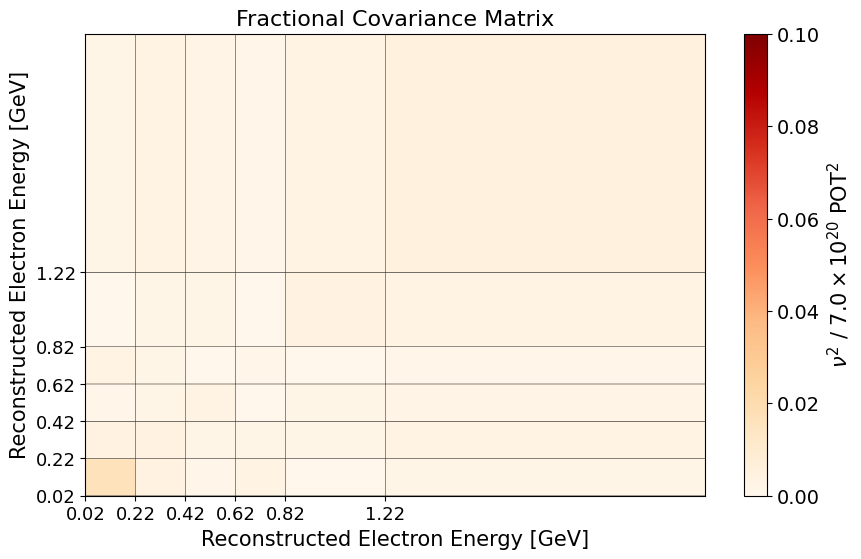

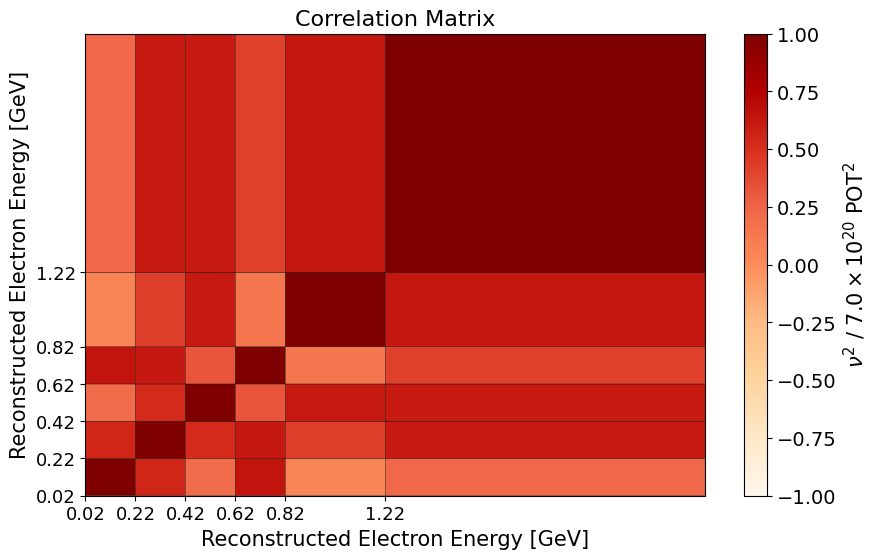

In [25]:
genie_dict = calcCov(xvar, bins, [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
                     [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
                     genie_variations, xticks=x_ticks, xhigh=xhigh,
                     axis_label='Reconstructed '+x_label, pot='$7.0 \\times 10^{20}$ POT',
                     plot=True)#, save="/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/genie_")


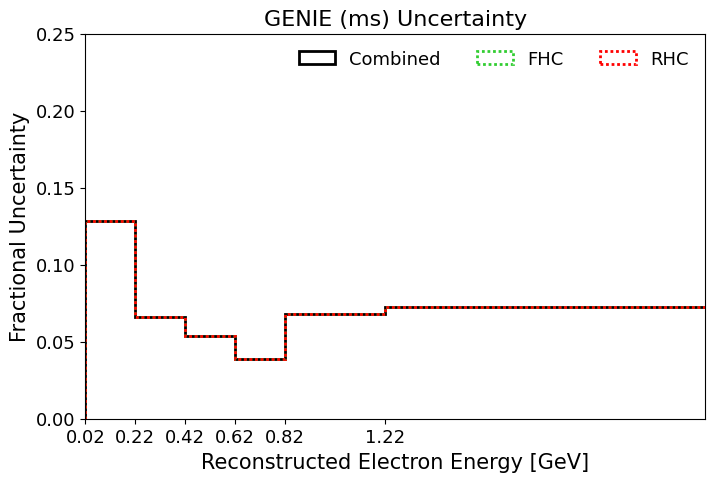

In [26]:
fig = plt.figure(figsize=(8, 5))  


plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Combined", 
         weights=genie_dict['fractional_uncertainty'], color='black', linewidth=2)

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC", 
         weights=fhc_genie_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), linewidth=2, color='limegreen')
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="RHC", 
         weights=rhc_genie_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), color='red', linewidth=2)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 0.25)

plt.legend(fontsize=13, frameon=False, ncol=3)
plt.title("GENIE (ms) Uncertainty", fontsize=16)


#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/genie_"+xvar+"_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

## GENIE us

In [27]:
genie_unisims = ['RPA', 'RPA', 'CCMEC', 'AxFFCCQE', 'VecFFCCQE', 'DecayAngMEC', 'ThetaDelta2Npi', 'ThetaDelta2NRad', 
                          'NormCCCOH', 'NormNCCOH', 'xsr_scc_Fv3', 'xsr_scc_Fa3']

RPA


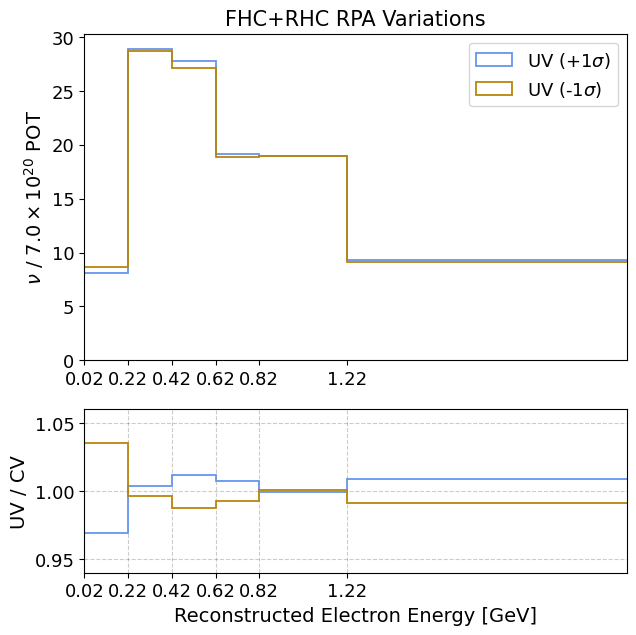

number of universes =  2
number of universes =  2
number of universes =  2
CCMEC


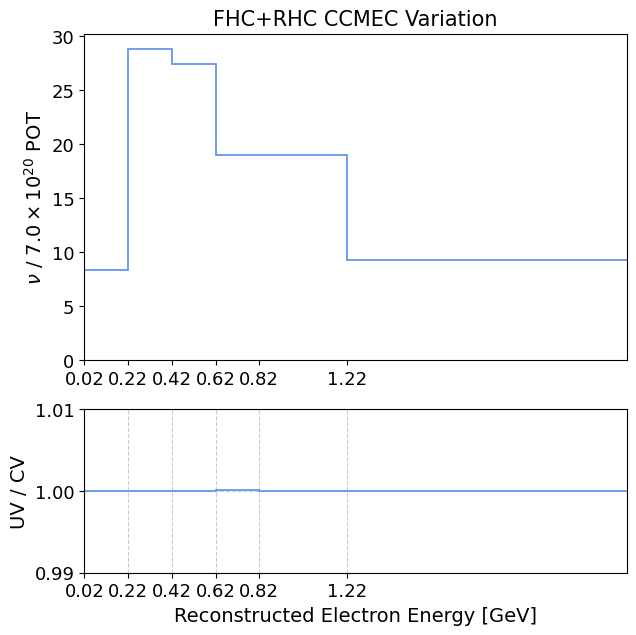

number of universes =  1
number of universes =  1
number of universes =  1
AxFFCCQE


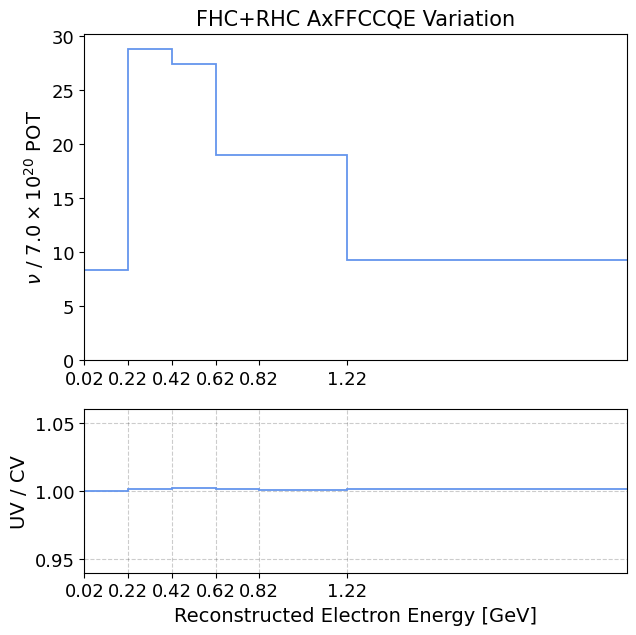

number of universes =  1
number of universes =  1
number of universes =  1
VecFFCCQE


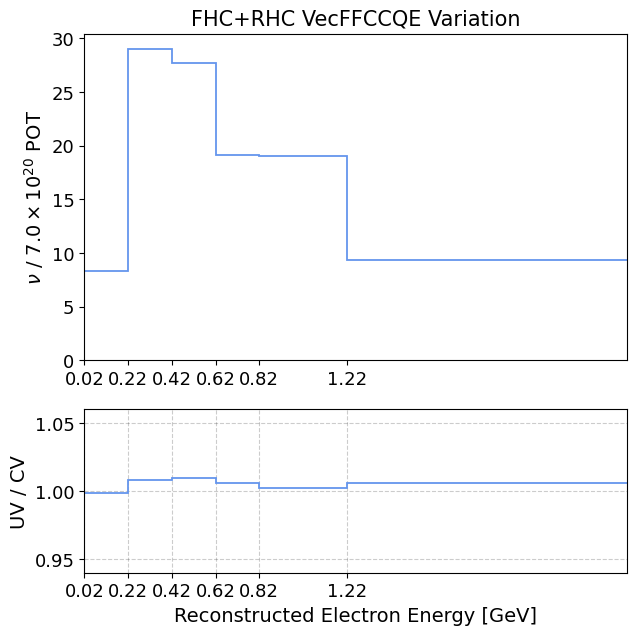

number of universes =  1
number of universes =  1
number of universes =  1
DecayAngMEC


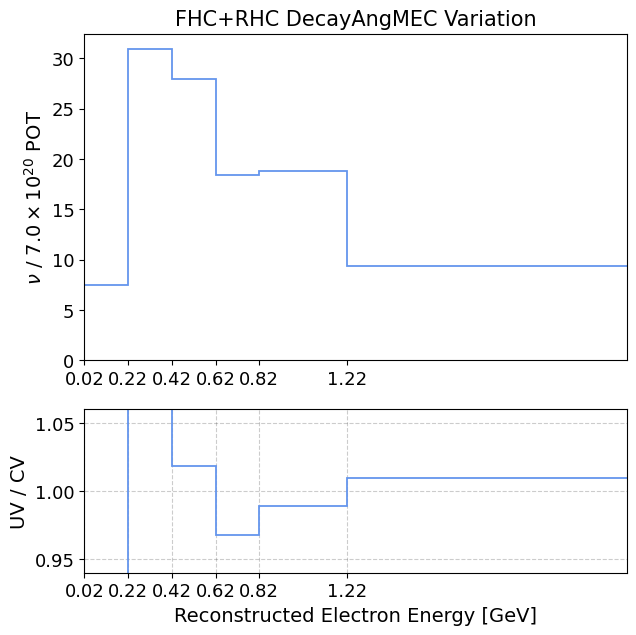

number of universes =  1
number of universes =  1
number of universes =  1
ThetaDelta2Npi


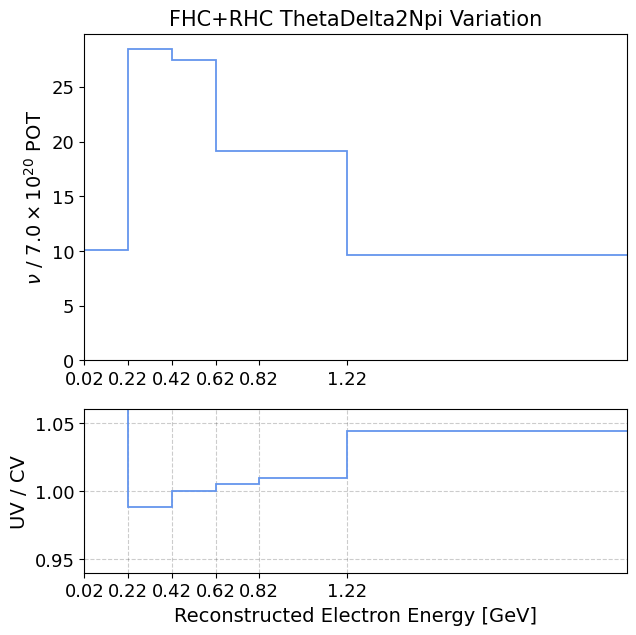

number of universes =  1
number of universes =  1
number of universes =  1
ThetaDelta2NRad


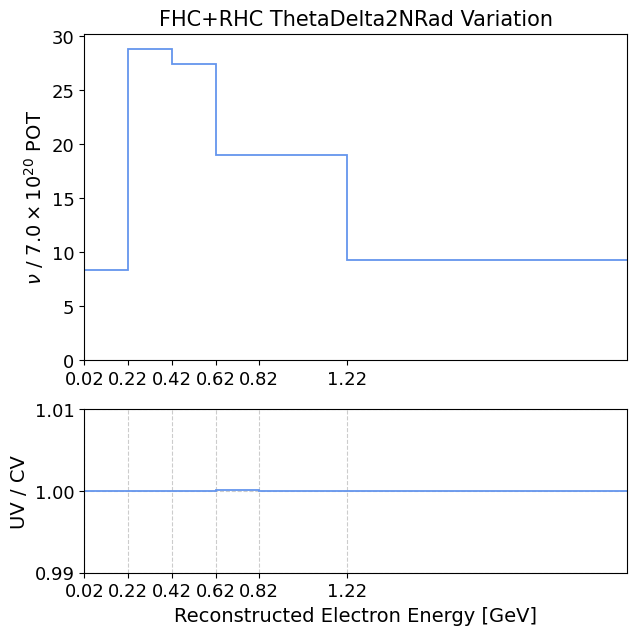

number of universes =  1
number of universes =  1
number of universes =  1
NormCCCOH


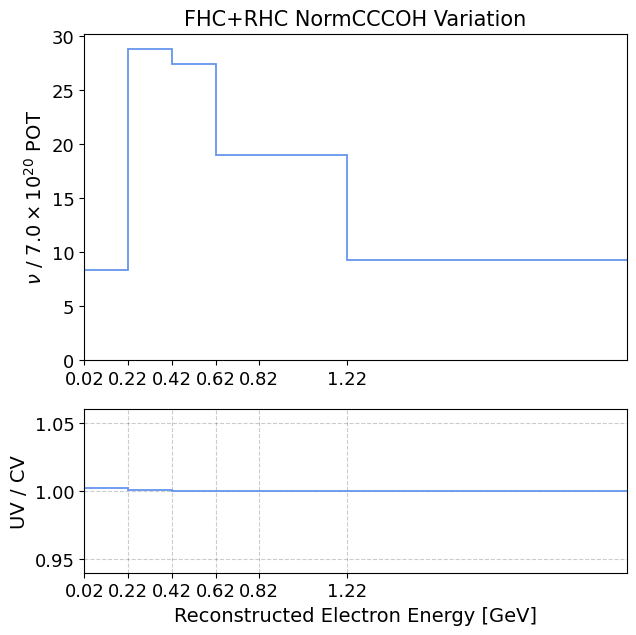

number of universes =  1
number of universes =  1
number of universes =  1
NormNCCOH


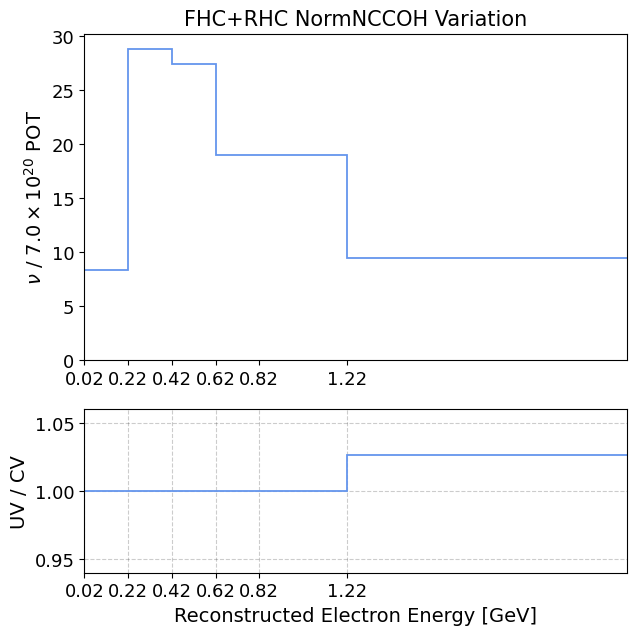

number of universes =  1
number of universes =  1
number of universes =  1
xsr_scc_Fv3


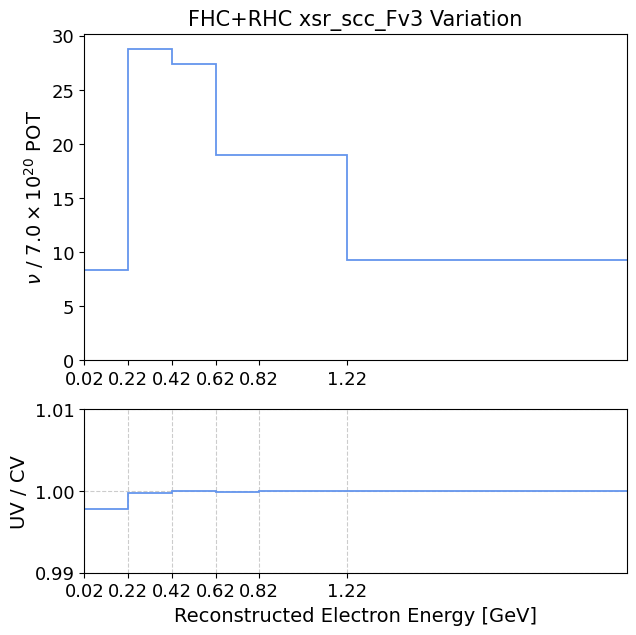

number of universes =  1
number of universes =  1
number of universes =  1
xsr_scc_Fa3


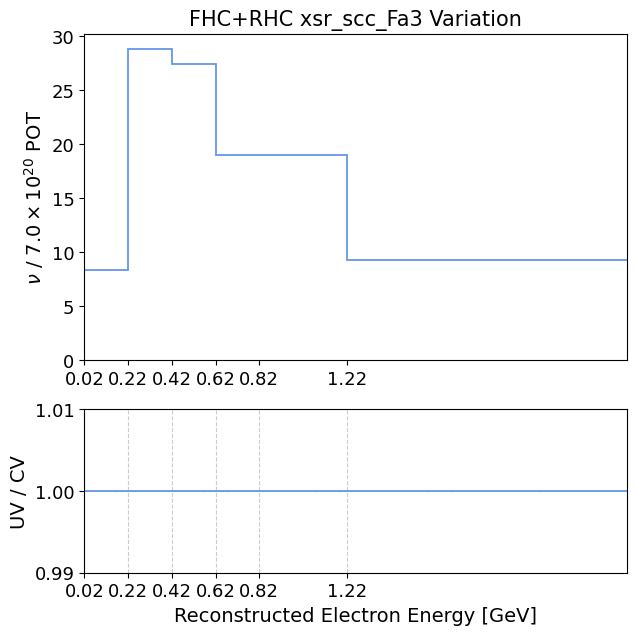

number of universes =  1
number of universes =  1
number of universes =  1


In [28]:
genie_unisim_cov = {}
fhc_genie_unisim_cov = {}
rhc_genie_unisim_cov = {}


i = 1

for v_fhc, v_rhc in zip(fhc_dict['genie_us'], rhc_dict['genie_us']): 
    
    print(genie_unisims[i])
    
    variations = []
    
    comb_v = [a+b for a,b in zip(v_fhc[0],v_rhc[0])]
    
    if i==1:
        comb_v2 = [a+b for a,b in zip(v_fhc[1],v_rhc[1])]
        variations.append(comb_v)
        variations.append(comb_v2)
    
    else: 
        variations.append(comb_v)
    
    fig = plt.figure(figsize=(7, 7)) 
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    ax1.tick_params(axis = 'x', which = 'major', labelsize = 13)
    ax2.tick_params(axis = 'x', which = 'major', labelsize = 13)
    
    ax1.tick_params(axis = 'y', which = 'major', labelsize = 13)
    ax2.tick_params(axis = 'y', which = 'major', labelsize = 13)
    
    #ax1.errorbar(bincenters, [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
    #            color='black', label="CV", xerr=binwidth, linestyle='None')
    
    if i==1: 
        
        ax1.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v, linewidth=1.3, 
        histtype='step', color='cornflowerblue', label='UV (+1$\\sigma$)')
        
        ax1.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v2, linewidth=1.3, 
        histtype='step', color='darkgoldenrod', label='UV (-1$\\sigma$)')
        
        ax1.legend(fontsize=13)
        
    else: 
        ax1.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v, linewidth=1.3, 
        histtype='step', color='cornflowerblue')
    
    # Ratios to CV 
    ax2.hist(bincenters, bins,
             weights=[x/y for x,y in zip(comb_v, [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])])], 
             color="cornflowerblue", histtype='step', linewidth=1.3)
    
    #print([x/y for x,y in zip(comb_v, [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])])])
    
    if i==1: 
        ax2.hist(bincenters, bins,
             weights=[x/y for x,y in zip(comb_v2, [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])])], 
             color="darkgoldenrod", histtype='step', linewidth=1.3)
    
    
    ax1.set_xlim(xlow, xhigh)
    if i==1: 
        ax1.set_title("FHC+RHC "+genie_unisims[i]+" Variations", fontsize=15)
    else: 
        ax1.set_title("FHC+RHC "+genie_unisims[i]+" Variation", fontsize=15)
    ax1.set_xticks(x_ticks)
    
    ax1.set_ylabel('$\\nu$ / $7.0 \\times 10^{20}$ POT' , fontsize=14)
    
    ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
    ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)

    ax2.set_xlabel('Reconstructed '+x_label, fontsize=14)
    ax2.set_ylabel('UV / CV', fontsize=14)
    ax2.set_xlim(xlow, xhigh)
    
    if (genie_unisims[i] == 'CCMEC') or (genie_unisims[i] =='ThetaDelta2NRad') or ('xsr' in genie_unisims[i]): 
        ax2.set_ylim(0.99, 1.01)
    else: 
        ax2.set_ylim(0.94, 1.06)
    
    ax2.set_xticks(x_ticks)
    
    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/genie_us_"+genie_unisims[i]+"_"+xvar+".pdf", 
    #        transparent=True, bbox_inches='tight')
    
    plt.show()
    
    fhc_genie_unisim_cov[genie_unisims[i]] = calcCov(xvar, bins, 
                                                    fhc_dict['evt_rate'], fhc_dict['evt_rate'], 
                                                    v_fhc, plot=False, save=False)
    
    rhc_genie_unisim_cov[genie_unisims[i]] = calcCov(xvar, bins, 
                                                    rhc_dict['evt_rate'], rhc_dict['evt_rate'], 
                                                    v_rhc, plot=False, save=False)
    
    genie_unisim_cov[genie_unisims[i]] = calcCov(xvar, bins, [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
                                     [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
                                     variations, plot=False, save=False)
    

    i += 1

In [29]:
for k,d in enumerate([fhc_genie_unisim_cov, rhc_genie_unisim_cov, genie_unisim_cov]): 
    
    cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    
    for variation in d.keys(): 

        for i in range(len(bins)-1): 
            for j in range(len(bins)-1):

                cov[i][j] += d[variation]['cov'][i][j]
                frac_cov[i][j] += d[variation]['frac_cov'][i][j] 


    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                    cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
        
    if k==0: 
        fhc_genie_unisim_dict = {
            'cov' : cov, 
            'frac_cov' : frac_cov,
            'cor' : cor,
            'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
        } 
        
        
    elif k==1: 
        rhc_genie_unisim_dict = {
            'cov' : cov, 
            'frac_cov' : frac_cov,
            'cor' : cor,
            'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
        } 
        
    elif k==2: 
        genie_unisim_dict = {
            'cov' : cov, 
            'frac_cov' : frac_cov,
            'cor' : cor,
            'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
        } 


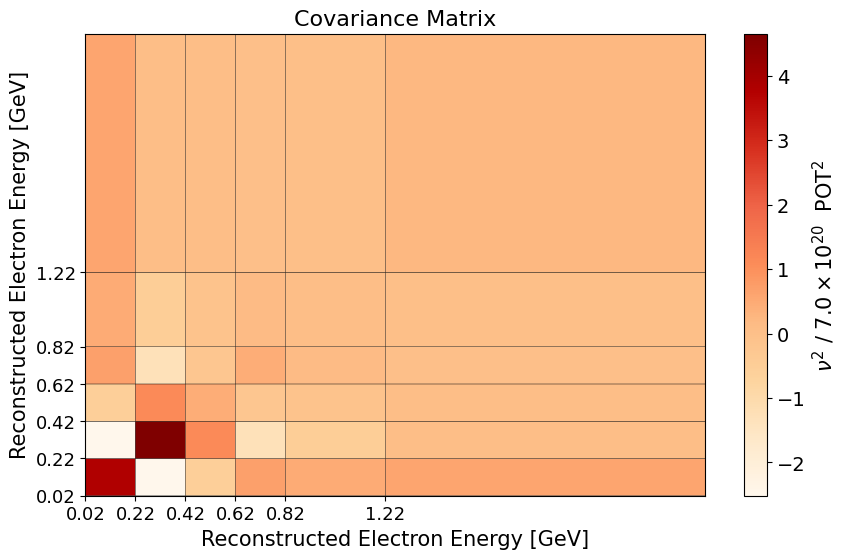

In [30]:
# covariance

fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, genie_unisim_dict['cov'], cmap='OrRd', edgecolors='k')
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label="$\\nu^{2}$ / $7.0\\times10^{20}$  POT$^{2}$", fontsize=15)
        
plt.xticks(x_ticks, fontsize=13)
plt.yticks(x_ticks,fontsize=13)
        
plt.xlim(bins[0], xhigh)
plt.ylim(bins[0], xhigh)

plt.xlabel('Reconstructed '+x_label, fontsize=15)
plt.ylabel('Reconstructed '+x_label, fontsize=15)

plt.title('Covariance Matrix', fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/genie_us_"+xvar+"_cov.pdf", 
#            transparent=True, bbox_inches='tight')


plt.show()

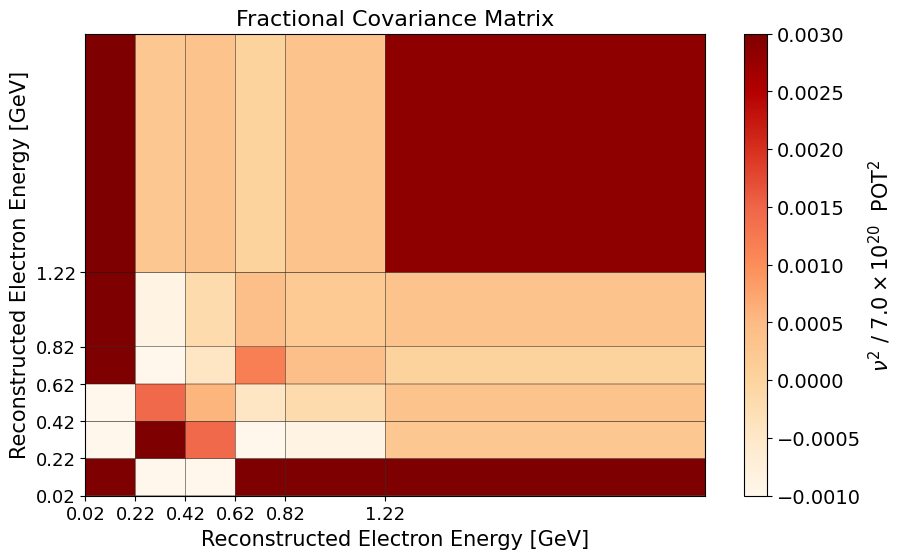

In [31]:
# frac covariance

fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, genie_unisim_dict['frac_cov'], cmap='OrRd', edgecolors='k', vmin=-0.001, vmax=0.003)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label="$\\nu^{2}$ / $7.0\\times10^{20}$  POT$^{2}$", fontsize=15)
        
plt.xticks(x_ticks, fontsize=13)
plt.yticks(x_ticks,fontsize=13)
        
plt.xlim(bins[0], xhigh)
plt.ylim(bins[0], xhigh)

plt.xlabel('Reconstructed '+x_label, fontsize=15)
plt.ylabel('Reconstructed '+x_label, fontsize=15)

plt.title('Fractional Covariance Matrix', fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/genie_us_"+xvar+"_frac_cov.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

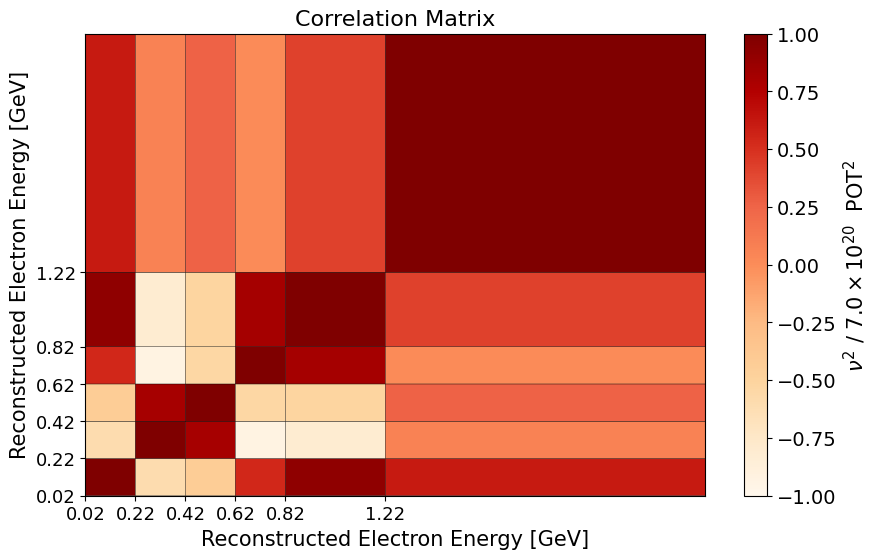

In [32]:
# correlation

fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, genie_unisim_dict['cor'], cmap='OrRd', edgecolors='k', vmin=-1, vmax=1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label="$\\nu^{2}$ / $7.0\\times10^{20}$  POT$^{2}$", fontsize=15)
        
plt.xticks(x_ticks, fontsize=13)
plt.yticks(x_ticks,fontsize=13)
        
plt.xlim(bins[0], xhigh)
plt.ylim(bins[0], xhigh)

plt.xlabel('Reconstructed '+x_label, fontsize=15)
plt.ylabel('Reconstructed '+x_label, fontsize=15)

plt.title('Correlation Matrix', fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/genie_us_"+xvar+"_cor.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

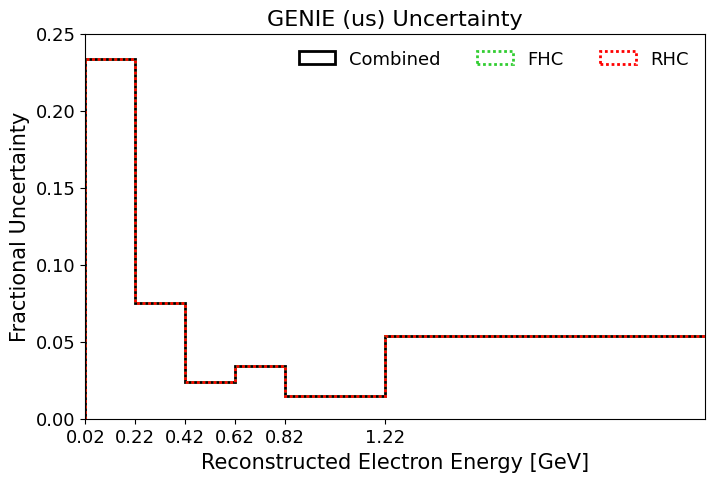

In [33]:


fig = plt.figure(figsize=(8, 5))  


plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Combined", 
         weights=genie_unisim_dict['fractional_uncertainty'], color='black', linewidth=2)

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC", 
         weights=fhc_genie_unisim_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), linewidth=2, color='limegreen')
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="RHC", 
         weights=rhc_genie_unisim_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), color='red', linewidth=2)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 0.25)

plt.legend(fontsize=13, frameon=False, ncol=3)
plt.title("GENIE (us) Uncertainty", fontsize=16)


#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/genie_us_"+xvar+"_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

## GEANT4

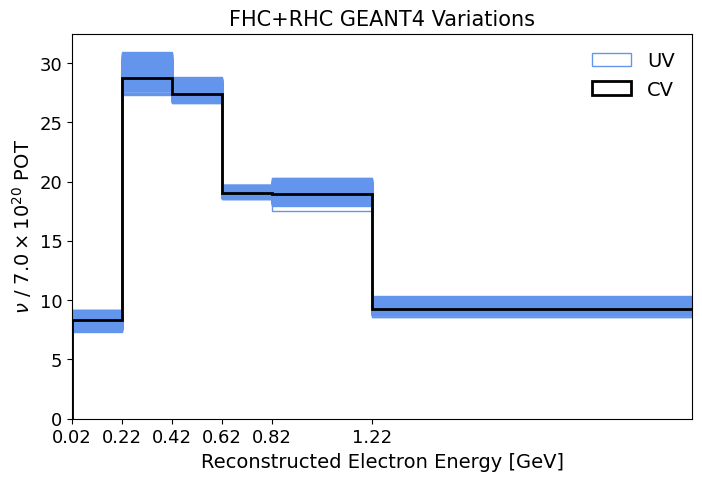

In [34]:
geant4_variations = []

fig = plt.figure(figsize=(8, 5)) 

n = 0

for v_fhc, v_rhc in zip(fhc_dict['geant4'], rhc_dict['geant4']): 
    
    comb_v = [a+b for a,b in zip(v_fhc,v_rhc)]
    geant4_variations.append(comb_v)
    
    if n==0: 
        plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
            histtype='step', color='cornflowerblue', linewidth=1, label='UV')
    else: 
        plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
            histtype='step', color='cornflowerblue', linewidth=1)
        
    
    n+=1

plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, 
        weights=[a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])],
        histtype='step', color='black', linewidth=2, label='CV') 
    
plt.xlim(xlow, xhigh)
plt.title("FHC+RHC GEANT4 Variations", fontsize=15)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(fontsize=14, frameon=False)

plt.xlabel('Reconstructed '+x_label, fontsize=14)
plt.ylabel('$\\nu$ / $7.0 \\times 10^{20}$ POT' , fontsize=14)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/geant4_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()


In [35]:
fhc_geant4_dict = calcCov(xvar, bins, fhc_dict['evt_rate'], fhc_dict['evt_rate'], 
                    fhc_dict['geant4'], plot=False) 

rhc_geant4_dict = calcCov(xvar, bins, rhc_dict['evt_rate'], rhc_dict['evt_rate'], 
                    rhc_dict['geant4'], plot=False) 

number of universes =  1000
number of universes =  1000


number of universes =  1000


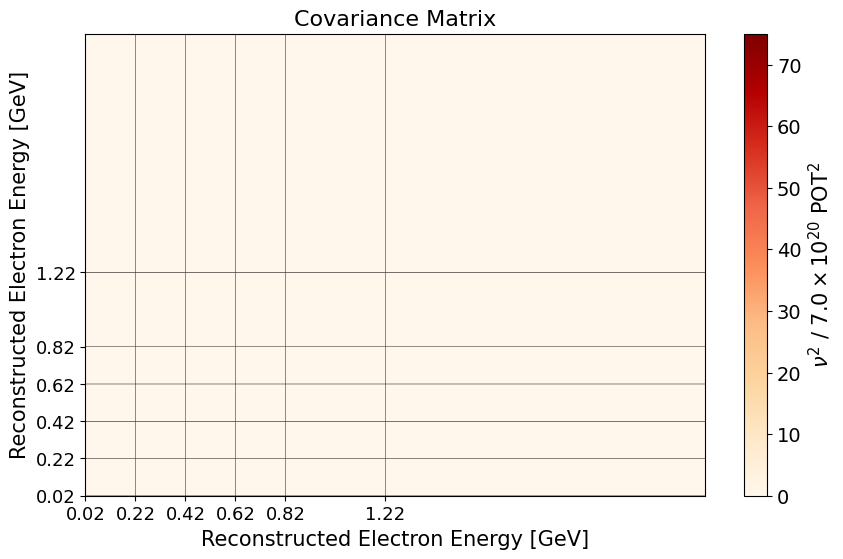

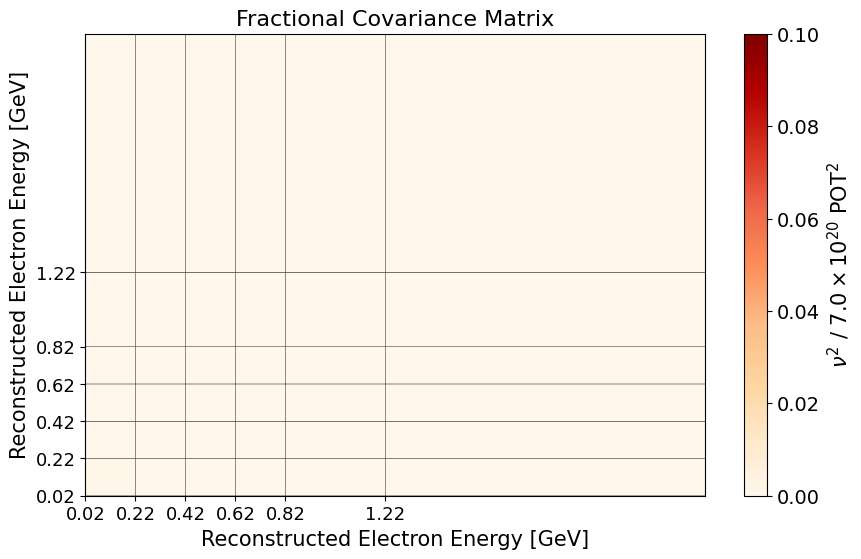

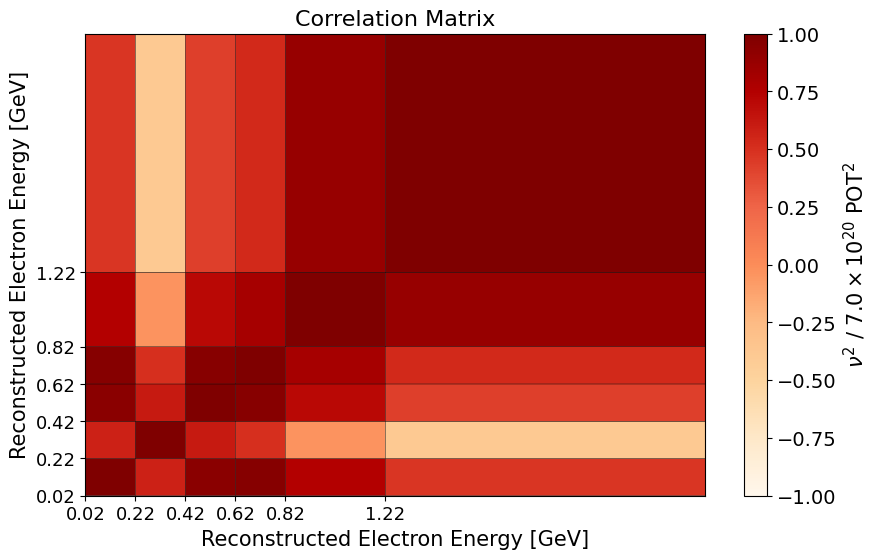

In [36]:
geant4_dict = calcCov(xvar, bins, [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
                    [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
                    geant4_variations, plot=True, xticks=x_ticks, xhigh=xhigh, axis_label="Reconstructed "+x_label, 
                     pot='$7.0 \\times 10^{20}$ POT')
                    #save="/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/geant4_") 

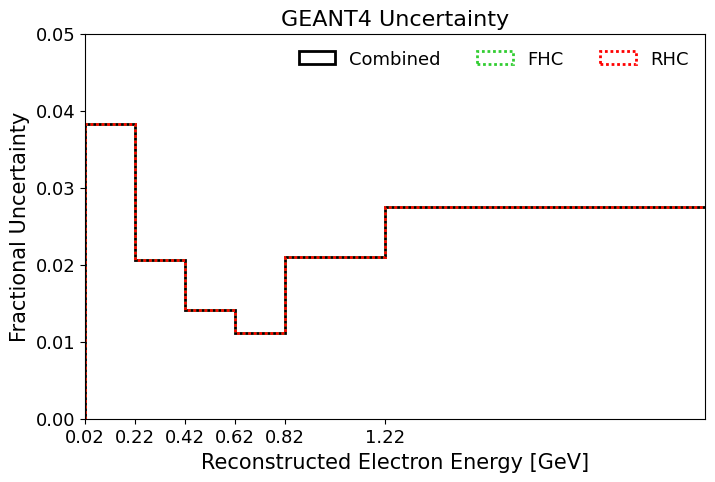

In [37]:


fig = plt.figure(figsize=(8, 5))  


plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Combined", 
         weights=geant4_dict['fractional_uncertainty'], color='black', linewidth=2)

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC", 
         weights=fhc_geant4_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), linewidth=2, color='limegreen')
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="RHC", 
         weights=rhc_geant4_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), color='red', linewidth=2)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 0.05)

plt.legend(fontsize=13, frameon=False, ncol=3)
plt.title("GEANT4 Uncertainty", fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/geant4_"+xvar+"_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

In [38]:
fhc_geant4_dict['fractional_uncertainty']

array([0.03832045, 0.02056306, 0.01414969, 0.01110995, 0.02098012,
       0.02750094])

## Detector systematics (Using Reco X) 

In [39]:
with open('unfolding/variations/old/FHCDetSysVariations_July31.json') as f_fhc_detsys:
    fhc_detsys_dict = json.load(f_fhc_detsys)
    
fhc_detsys_dict['LYAttenuation_intrinsic'] = [0 for i in range(len(fhc_detsys_dict['CV_intrinsic'] ))]

with open('unfolding/variations/old/RHCDetSysVariations_July31.json') as f_rhc_detsys:
    rhc_detsys_dict = json.load(f_rhc_detsys)

In [40]:
xvar_detsys = "reco_nu_vtx_sce_x"
bins_detsys = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250]

bincenters_detsys = 0.5*(np.array(bins_detsys)[1:]+np.array(bins_detsys)[:-1])
x_err_detsys = [ round(abs(bins_detsys[x+1]-bins_detsys[x])/2, 3) for x in range(len(bins_detsys)-1) ]

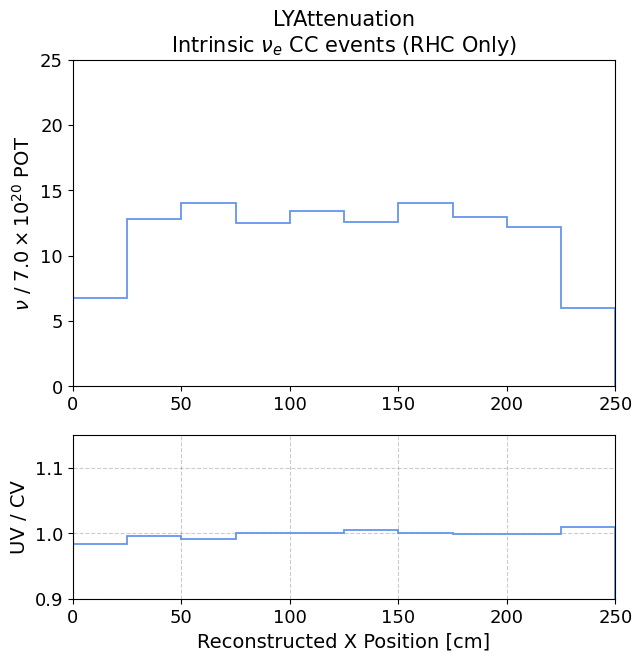

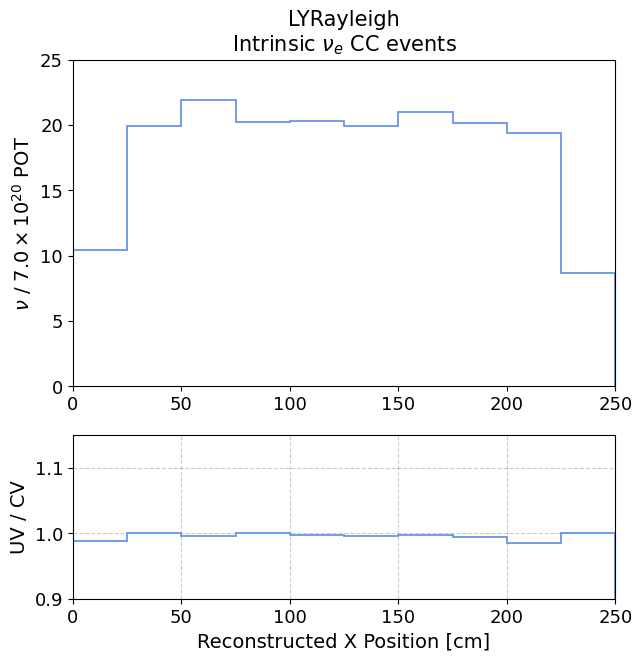

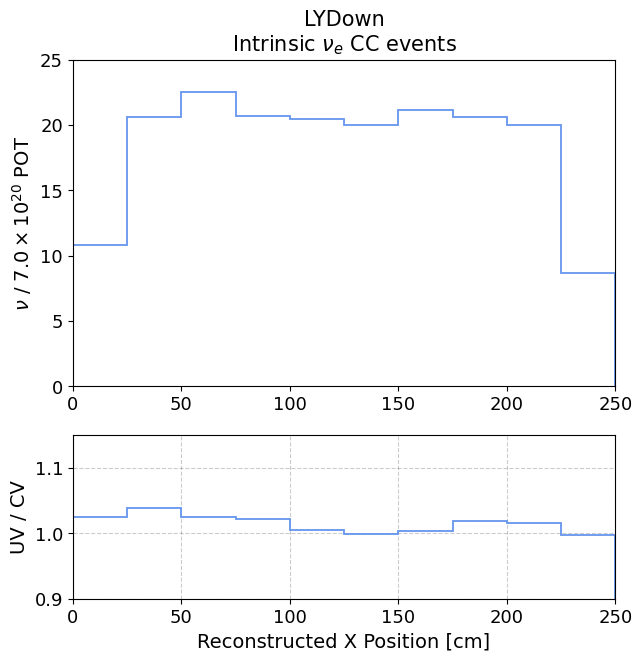

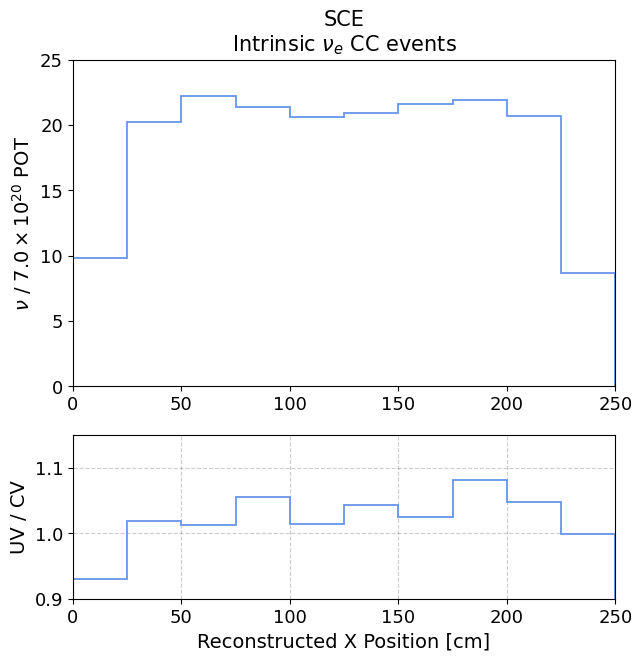

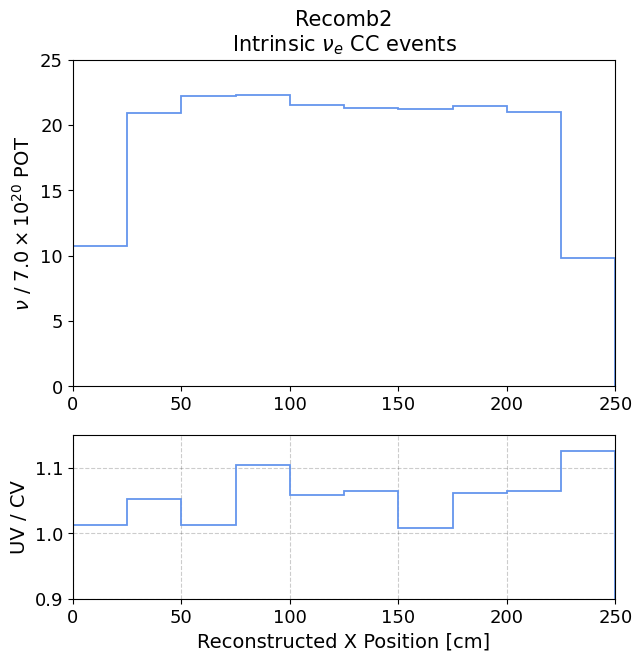

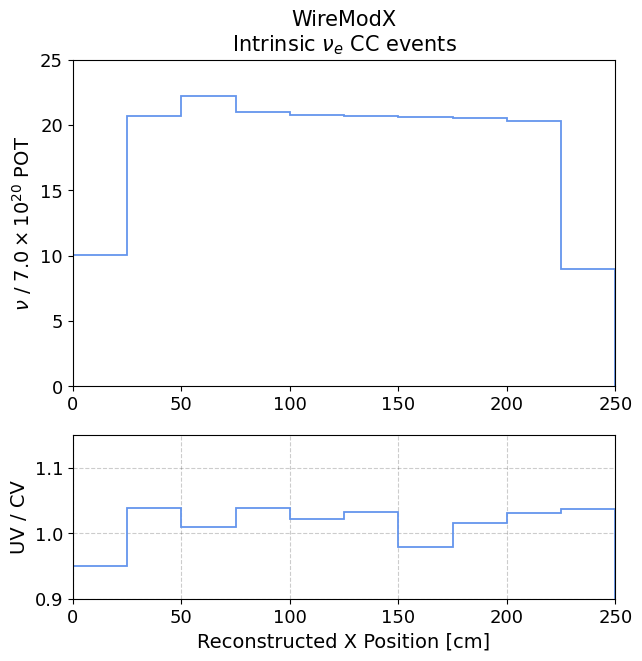

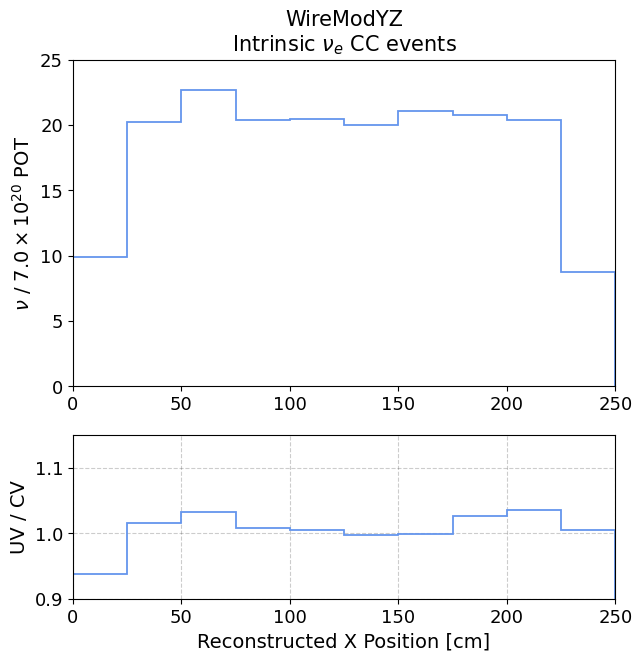

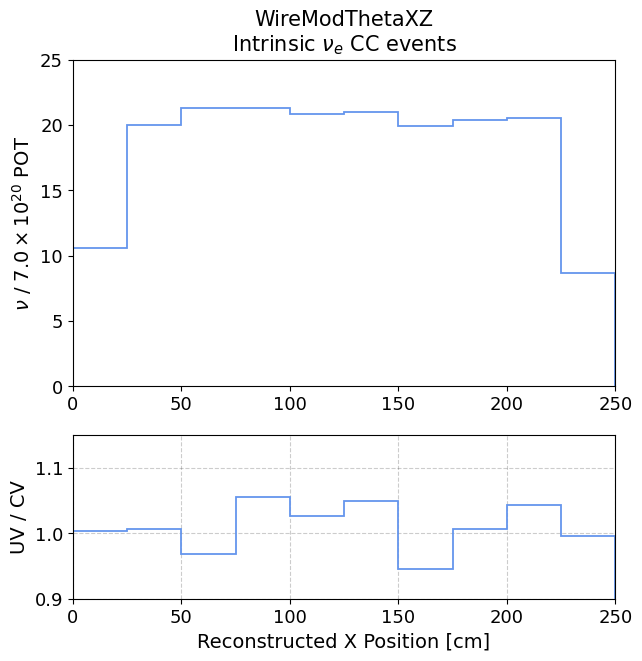

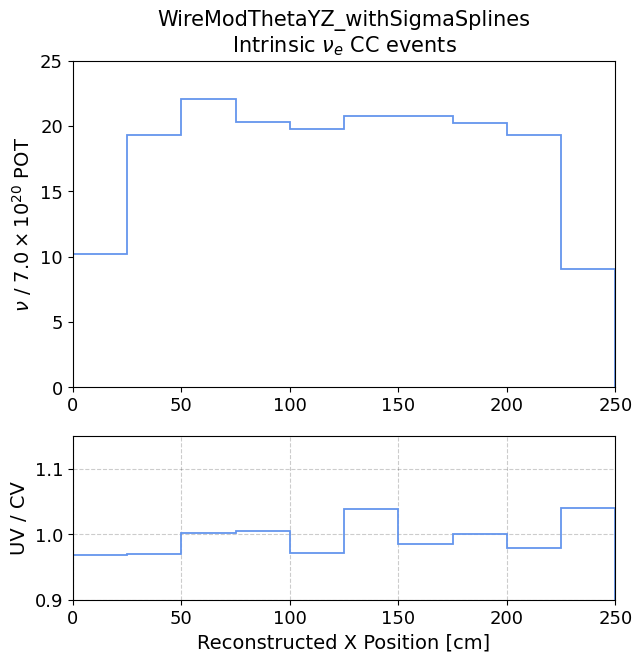

In [41]:
for variation in intrinsic_detvar_run3_rhc.keys(): 
    
    if variation=='CV_intrinsic': 
        continue
        
    if variation=='LYAttenuation_intrinsic': 
        comb_v = rhc_detsys_dict[variation]
        comb_cv = rhc_detsys_dict['CV_intrinsic']
        
    else: 
        comb_v = [a+b for a,b in zip(fhc_detsys_dict[variation], rhc_detsys_dict[variation])]
        comb_cv = [a+b for a,b in zip(fhc_detsys_dict['CV_intrinsic'], rhc_detsys_dict['CV_intrinsic'])]
        
    fig = plt.figure(figsize=(7, 7)) 
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    ax1.tick_params(axis = 'x', which = 'major', labelsize = 13)
    ax2.tick_params(axis = 'x', which = 'major', labelsize = 13)
    
    ax1.tick_params(axis = 'y', which = 'major', labelsize = 13)
    ax2.tick_params(axis = 'y', which = 'major', labelsize = 13)
        
    ax1.hist(bincenters_detsys, bins_detsys, histtype='step', range=[bins_detsys[0], bins_detsys[-1]], 
                 weights=comb_v, color='cornflowerblue', linewidth=1.3)
    # Ratios to CV 
    
    ratio = [x/y for x,y in zip(comb_v, comb_cv)]
    
    ax2.hist(bincenters_detsys, bins_detsys,
             weights=ratio, 
             color="cornflowerblue", histtype='step', linewidth=1.3)
    
    if variation=='LYAttenuation_intrinsic': 
        ax1.set_title(variation[:-10]+'\nIntrinsic $\\nu_{e}$ CC events (RHC Only)', fontsize=15)
        
    else: 
        ax1.set_title(variation[:-10]+'\nIntrinsic $\\nu_{e}$ CC events', fontsize=15)
    ax1.set_ylabel('$\\nu$ / $7.0 \\times 10^{20}$ POT' , fontsize=14)
    ax1.set_xlim(0, 250)
    ax1.set_ylim(0, 25)
    
    
    ax2.set_xlabel("Reconstructed X Position [cm]", fontsize=14)
    ax2.set_ylabel('UV / CV', fontsize=14)
    ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
    ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)
    ax2.set_xlim(0, 250)
    ax2.set_ylim(0.9, 1.15)
    
    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_"+variation+"_recox.pdf", 
    #        transparent=True, bbox_inches='tight')
    
    plt.show()

In [42]:
detsys_cv = [a+b for a,b in zip(fhc_detsys_dict['CV_intrinsic'], rhc_detsys_dict['CV_intrinsic'])]

In [43]:
detsys_cov_nueCC = {}
fhc_detsys_cov_nueCC = {}
rhc_detsys_cov_nueCC = {}

for variation in intrinsic_detvar_run3_rhc.keys(): 
    
    print(variation)
    
    if variation=='CV': 
        continue
        
    if variation=='LYAttenuation_intrinsic': 
        
        detsys_cov_nueCC[variation] = calcCov(xvar_detsys, bins_detsys, 
                                          rhc_detsys_dict['CV_intrinsic'], 
                                              rhc_detsys_dict['CV_intrinsic'], 
                                              [rhc_detsys_dict[variation]])
        
        rhc_detsys_cov_nueCC[variation] = detsys_cov_nueCC[variation]
        
    else: 
   
        detsys_cov_nueCC[variation] = calcCov(xvar_detsys, bins_detsys, 
                                          detsys_cv, detsys_cv, 
                                              [[a+b for a,b in zip(fhc_detsys_dict[variation], rhc_detsys_dict[variation])]])
    
        fhc_detsys_cov_nueCC[variation] = calcCov(xvar_detsys, bins_detsys, 
                                          fhc_detsys_dict['CV_intrinsic'], 
                                              fhc_detsys_dict['CV_intrinsic'], 
                                              [fhc_detsys_dict[variation]])
        
        rhc_detsys_cov_nueCC[variation] = calcCov(xvar_detsys, bins_detsys, 
                                          rhc_detsys_dict['CV_intrinsic'], 
                                              rhc_detsys_dict['CV_intrinsic'], 
                                              [rhc_detsys_dict[variation]])
  

LYAttenuation_intrinsic
number of universes =  1
LYRayleigh_intrinsic
number of universes =  1
number of universes =  1
number of universes =  1
LYDown_intrinsic
number of universes =  1
number of universes =  1
number of universes =  1
SCE_intrinsic
number of universes =  1
number of universes =  1
number of universes =  1
Recomb2_intrinsic
number of universes =  1
number of universes =  1
number of universes =  1
WireModX_intrinsic
number of universes =  1
number of universes =  1
number of universes =  1
WireModYZ_intrinsic
number of universes =  1
number of universes =  1
number of universes =  1
WireModThetaXZ_intrinsic
number of universes =  1
number of universes =  1
number of universes =  1
WireModThetaYZ_withSigmaSplines_intrinsic
number of universes =  1
number of universes =  1
number of universes =  1
CV_intrinsic
number of universes =  1
number of universes =  1
number of universes =  1


In [44]:
frac_cov = [ [0]*(len(bins_detsys)-1) for x in range(len(bins_detsys)-1) ]

fhc_frac_cov = [ [0]*(len(bins_detsys)-1) for x in range(len(bins_detsys)-1) ]
rhc_frac_cov = [ [0]*(len(bins_detsys)-1) for x in range(len(bins_detsys)-1) ]


for i in range(len(bins_detsys)-1): 
    for j in range(len(bins_detsys)-1):
            
        #cov[i][j] = sum([detsys_cov_nueCC[x]['cov'][i][j] for x in intrinsic_detvar_run3_rhc.keys() if x is not 'CV_intrinsic'])
        frac_cov[i][j] = sum([detsys_cov_nueCC[x]['frac_cov'][i][j] for x in intrinsic_detvar_run3_rhc.keys() if x is not 'CV_intrinsic'])
        
        fhc_frac_cov[i][j] = sum([fhc_detsys_cov_nueCC[x]['frac_cov'][i][j] for x in intrinsic_detvar_run1_fhc.keys() if x is not 'CV_intrinsic'])
        rhc_frac_cov[i][j] = sum([rhc_detsys_cov_nueCC[x]['frac_cov'][i][j] for x in intrinsic_detvar_run3_rhc.keys() if x is not 'CV_intrinsic'])
 


<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_60391/3007373054.py:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  frac_cov[i][j] = sum([detsys_cov_nueCC[x]['frac_cov'][i][j] for x in intrinsic_detvar_run3_rhc.keys() if x is not 'CV_intrinsic'])
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_60391/3007373054.py:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  fhc_frac_cov[i][j] = sum([fhc_detsys_cov_nueCC[x]['frac_cov'][i][j] for x in intrinsic_detvar_run1_fhc.keys() if x is not 'CV_intrinsic'])
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq

In [45]:
# now compute absolute total covariance - from frac cov to account for LYAttenuation (RHC only)
cov = [ [0]*(len(bins_detsys)-1) for x in range(len(bins_detsys)-1) ]

for i in range(len(bins_detsys)-1): 
    for j in range(len(bins_detsys)-1): 
        cov[i][j] = frac_cov[i][j] * detsys_cv[i] * detsys_cv[j]

In [46]:
cor = [ [0]*(len(bins_detsys)-1) for x in range(len(bins_detsys)-1) ]

# compute the corr matrix 
for i in range(len(cov)): 
    for j in range(len(cov[i])): 

        if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
            cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))

nueCC_detsys_dict = {
    'cov' : cov, 
    'frac_cov' : frac_cov,
    'fractional_uncertainty' : np.sqrt(np.diag(frac_cov)),
    'cor' : cor
} 


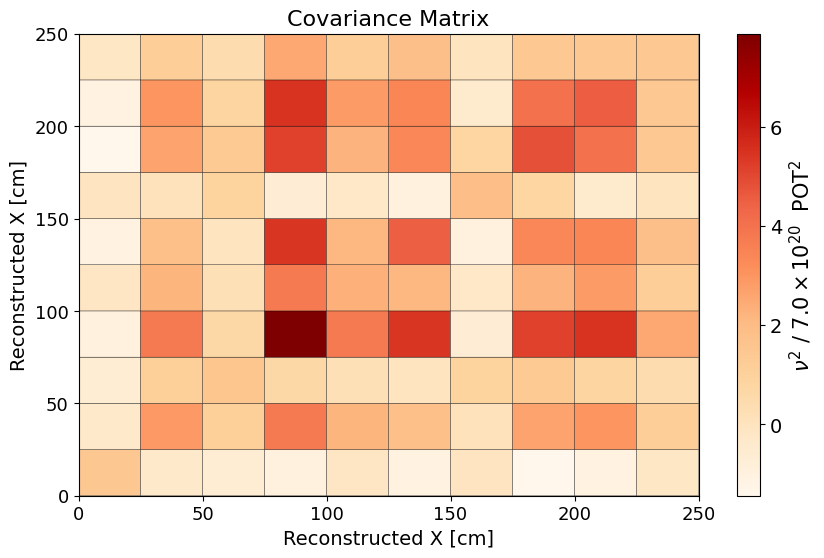

In [47]:
# cov

fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins_detsys, bins_detsys, nueCC_detsys_dict['cov'], cmap='OrRd', edgecolors='k')
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label="$\\nu^{2}$ / $7.0\\times10^{20}$  POT$^{2}$", fontsize=15)
        
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)


plt.xlabel("Reconstructed X [cm]", fontsize=14)
plt.ylabel("Reconstructed X [cm]", fontsize=14)

plt.title('Covariance Matrix', fontsize=16)

plt.show()

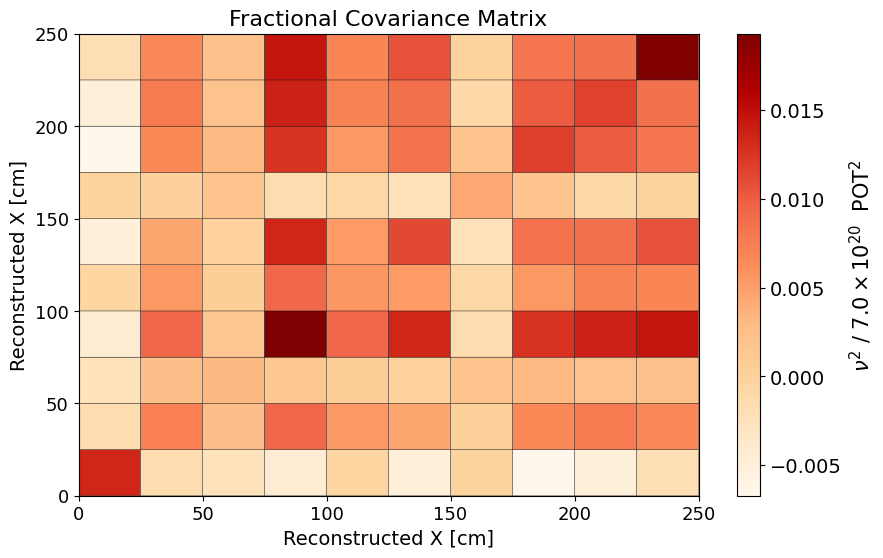

In [48]:
# frac cov 

fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins_detsys, bins_detsys, nueCC_detsys_dict['frac_cov'], cmap='OrRd', edgecolors='k')
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label="$\\nu^{2}$ / $7.0\\times10^{20}$  POT$^{2}$", fontsize=15)
        
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)


plt.xlabel("Reconstructed X [cm]", fontsize=14)
plt.ylabel("Reconstructed X [cm]", fontsize=14)

plt.title('Fractional Covariance Matrix', fontsize=16)


plt.show()

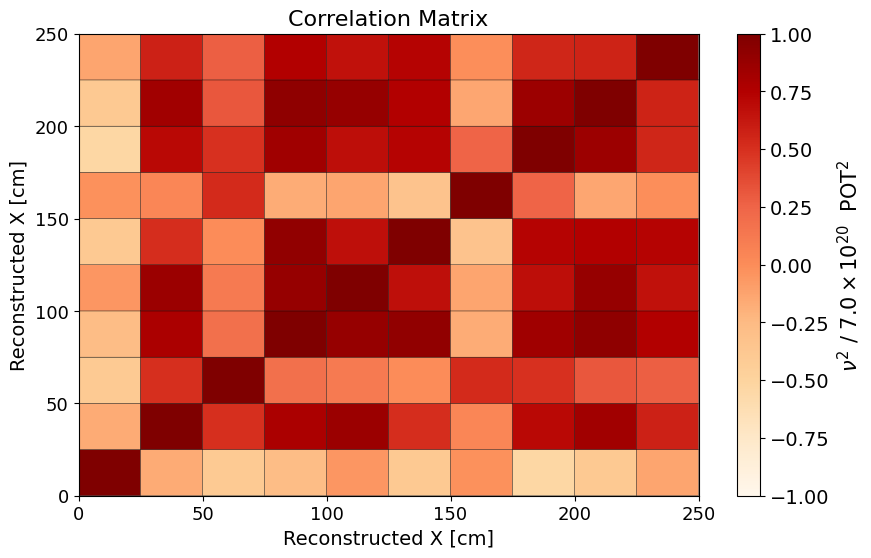

In [49]:
# cor

fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins_detsys, bins_detsys, nueCC_detsys_dict['cor'], cmap='OrRd', edgecolors='k', vmin=-1, vmax=1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label="$\\nu^{2}$ / $7.0\\times10^{20}$  POT$^{2}$", fontsize=15)
        
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)


plt.xlabel("Reconstructed X [cm]", fontsize=14)
plt.ylabel("Reconstructed X [cm]", fontsize=14)

plt.title('Correlation Matrix', fontsize=16)



plt.show()

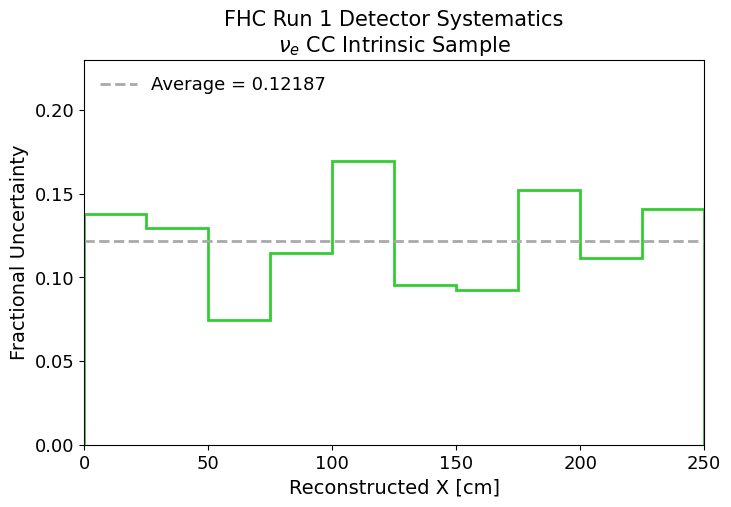

In [50]:
plt.figure(figsize=(8, 5))

plt.hist(bincenters_detsys, bins_detsys, weights=np.sqrt(np.diagonal(fhc_frac_cov)), histtype='step', 
         color='limegreen', linewidth=2)

plt.hlines(np.average(np.sqrt(np.diagonal(fhc_frac_cov))), 0, 250, linestyle='--', color='darkgray', linewidth=2,
           label='Average = '+str(round(np.average(np.sqrt(np.diagonal(fhc_frac_cov))), 5)))

plt.xlim(0, 250)
plt.ylim(0, 0.23)
plt.legend(fontsize=13, loc='upper left', frameon=False)

plt.xlabel("Reconstructed X [cm]", fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("FHC Run 1 Detector Systematics\n$\\nu_{e}$ CC Intrinsic Sample", fontsize=15)


#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/fhc_detsys_recox_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

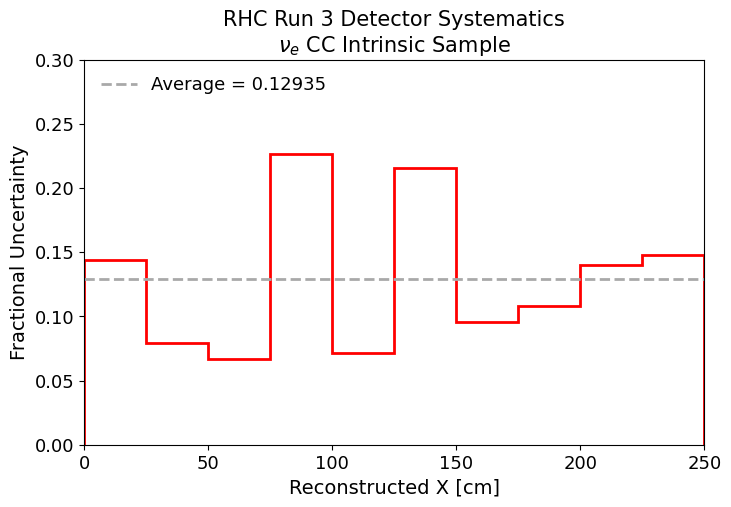

In [51]:
plt.figure(figsize=(8, 5))

plt.hist(bincenters_detsys, bins_detsys, weights=np.sqrt(np.diagonal(rhc_frac_cov)), histtype='step', 
         color='red', linewidth=2)

plt.hlines(np.average(np.sqrt(np.diagonal(rhc_frac_cov))), 0, 250, linestyle='--', color='darkgray', linewidth=2,
           label='Average = '+str(round(np.average(np.sqrt(np.diagonal(rhc_frac_cov))), 5)))

plt.xlim(0, 250)
plt.ylim(0, 0.3)
plt.legend(fontsize=13, loc='upper left', frameon=False)

plt.xlabel("Reconstructed X [cm]", fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("RHC Run 3 Detector Systematics\n$\\nu_{e}$ CC Intrinsic Sample", fontsize=15)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/rhc_detsys_recox_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

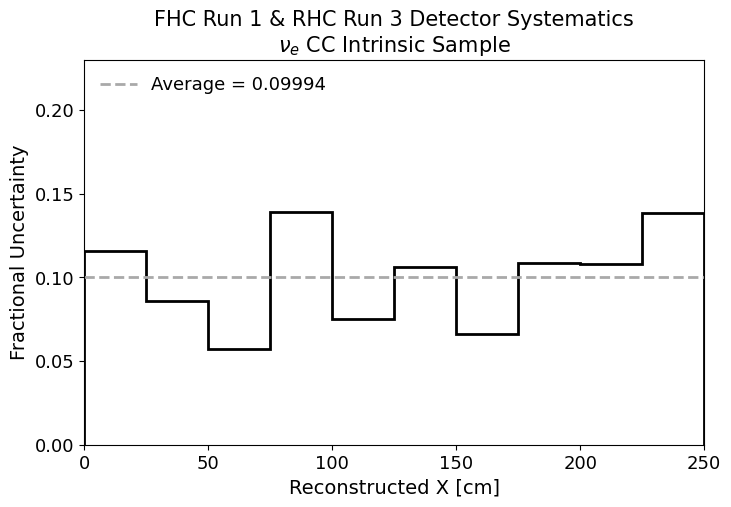

In [52]:

x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]

plt.figure(figsize=(8, 5))

plt.hist(bincenters_detsys, bins_detsys, weights=nueCC_detsys_dict['fractional_uncertainty'], histtype='step', 
          color='black', linewidth=2)


plt.hlines(np.average(nueCC_detsys_dict['fractional_uncertainty']), 0, 250, linestyle='--', color='darkgray', linewidth=2,
           label='Average = '+str(round(np.average(nueCC_detsys_dict['fractional_uncertainty']), 5)))

plt.xlim(0, 250)
plt.ylim(0, 0.23)
plt.legend(fontsize=13, loc='upper left', frameon=False)

plt.xlabel("Reconstructed X [cm]", fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("FHC Run 1 & RHC Run 3 Detector Systematics\n$\\nu_{e}$ CC Intrinsic Sample", fontsize=15)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_recox_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

In [53]:
avg_detsys_dict = {
    'fractional_uncertainty' : [np.average(nueCC_detsys_dict['fractional_uncertainty']) for x in range(len(bins))]
}

In [54]:
avg_detsys_dict['fractional_uncertainty']

[0.09994277695110641,
 0.09994277695110641,
 0.09994277695110641,
 0.09994277695110641,
 0.09994277695110641,
 0.09994277695110641,
 0.09994277695110641]

In [55]:
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
 
for i in range(len(bins)-1): 
    if [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])][i] != 0: 
        frac_cov[i][i] = np.average(nueCC_detsys_dict['fractional_uncertainty'])**2

avg_detsys_dict['frac_cov'] = frac_cov

In [56]:
avg_detsys_dict['frac_cov']

[[0.009988558664698607, 0, 0, 0, 0, 0],
 [0, 0.009988558664698607, 0, 0, 0, 0],
 [0, 0, 0.009988558664698607, 0, 0, 0],
 [0, 0, 0, 0.009988558664698607, 0, 0],
 [0, 0, 0, 0, 0.009988558664698607, 0],
 [0, 0, 0, 0, 0, 0.009988558664698607]]

## Stat uncertainty (number of events)

In [57]:
# N_data - sumw2_EXT - sumw2_MCbkgd = stat covariance 
# square root the whole thing and divide by evt rate for the fractional uncertainty 

In [58]:
stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

fhc_frac_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
rhc_frac_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

fhc_stat_percent_error = []
rhc_stat_percent_error = []
stat_percent_error = []

In [59]:
isClosureTest

True

In [60]:
isNuWro

True

In [61]:
if isClosureTest: 
    if isNuWro: 
        nuwro_full_sumw2 = fhc_dict['nuwro_full_sumw2'] # nuwro stat error
    mc_signal_sumw2 = [a+b for a,b in zip(fhc_dict['mc_signal_sumw2'], rhc_dict['mc_signal_sumw2'])] # mc stat error
    
else: 
    cv_bkgd = [a+b for a,b in zip(fhc_dict['cv_bkgd'], rhc_dict['cv_bkgd'])]
    beamon_counts = [a+b for a,b in zip(fhc_dict['beamon_counts'], rhc_dict['beamon_counts'])] # data (background-subtracted)
    print(beamon_counts)

mc_bkgd_sumw2 = [a+b for a,b in zip(fhc_dict['mc_bkgd_sumw2'], rhc_dict['mc_bkgd_sumw2'])]
ext_sumw2 = [a+b for a,b in zip(fhc_dict['ext_sumw2'], rhc_dict['ext_sumw2'])]
evt_rate = [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])]


In [62]:
if isClosureTest: 
    
    for i in range(len(bins)-1):
        
        if isNuWro: 
            
            fhc_frac_stat_cov[i][i] = (nuwro_full_sumw2[i] + fhc_dict['mc_bkgd_sumw2'][i] + fhc_dict['ext_sumw2'][i]) / (fhc_dict['evt_rate_nuwro_ppfx'][i]**2)
            fhc_stat_percent_error.append( np.sqrt( fhc_frac_stat_cov[i][i]) ) 
        
        else: 
            stat_cov[i][i] = (mc_signal_sumw2[i] + mc_bkgd_sumw2[i] + ext_sumw2[i])

            frac_stat_cov[i][i] = stat_cov[i][i] / (evt_rate[i]**2)

            # this is OK -- just take the sum of the weights squared of the full event rate for GENIE closure test 
            fhc_frac_stat_cov[i][i] = ( fhc_dict['mc_signal_sumw2'][i] + fhc_dict['mc_bkgd_sumw2'][i] + fhc_dict['ext_sumw2'][i]) / (fhc_dict['evt_rate'][i]**2)
            rhc_frac_stat_cov[i][i] = ( rhc_dict['mc_signal_sumw2'][i] + rhc_dict['mc_bkgd_sumw2'][i] + rhc_dict['ext_sumw2'][i]) / (rhc_dict['evt_rate'][i]**2)

            fhc_stat_percent_error.append( np.sqrt( fhc_frac_stat_cov[i][i]) ) 
            rhc_stat_percent_error.append(np.sqrt(rhc_frac_stat_cov[i][i])) 
            stat_percent_error.append(np.sqrt(frac_stat_cov[i][i])) 
        
else: 
    
    # use the full event rates - before background subtraction
    delta_n_data2 = [a+b for a,b in zip(beamon_counts,cv_bkgd)] 
    delta_n_data2_fhc = [a+b for a,b in zip(fhc_dict['beamon_counts'],fhc_dict['cv_bkgd'])]
    delta_n_data2_rhc = [a+b for a,b in zip(rhc_dict['beamon_counts'],rhc_dict['cv_bkgd'])]
    
    for i in range(len(bins)-1):
    
        stat_cov[i][i] = (delta_n_data2[i] + mc_bkgd_sumw2[i] + ext_sumw2[i])

        if delta_n_data2[i]!=0: 
            frac_stat_cov[i][i] = stat_cov[i][i] / (delta_n_data2[i]**2)

            fhc_frac_stat_cov[i][i] = ( delta_n_data2_fhc[i] + fhc_dict['mc_bkgd_sumw2'][i] + fhc_dict['ext_sumw2'][i]) / (fhc_dict['beamon_counts'][i]**2)
            rhc_frac_stat_cov[i][i] = ( delta_n_data2_rhc[i] + rhc_dict['mc_bkgd_sumw2'][i] + rhc_dict['ext_sumw2'][i]) / (rhc_dict['beamon_counts'][i]**2)

        fhc_stat_percent_error.append( np.sqrt( fhc_frac_stat_cov[i][i]) ) 
        rhc_stat_percent_error.append(np.sqrt(rhc_frac_stat_cov[i][i])) 
        stat_percent_error.append(np.sqrt(frac_stat_cov[i][i]))

In [63]:
#nuwro_full_sumw2 = fhc_dict['nuwro_full_sumw2']
#for i in range(len(bins)-1):
#    fhc_frac_stat_cov[i][i] = (nuwro_full_sumw2[i] + fhc_dict['mc_bkgd_sumw2'][i] + fhc_dict['ext_sumw2'][i]) / (fhc_dict['evt_rate_nuwro_ppfx'][i]**2)
#    fhc_stat_percent_error.append( np.sqrt( fhc_frac_stat_cov[i][i]) ) 

In [63]:

if not isNuWro: 
    fig = plt.figure(figsize=(8, 5))  


    plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Combined", 
             weights=stat_percent_error, color='black', linewidth=2)

    plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC", 
             weights=fhc_stat_percent_error, 
             linestyle=(0, (1, 1)), linewidth=2, color='limegreen')

    plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="RHC", 
             weights=rhc_stat_percent_error, 
             linestyle=(0, (1, 1)), color='red', linewidth=2)

    plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.xlabel("Reconstructed " + x_label, fontsize=15)
    plt.ylabel("Fractional Uncertainty", fontsize=15)

    plt.xlim(bins[0], xhigh)
    plt.ylim(0, 1.0)

    plt.legend(fontsize=13, frameon=False, ncol=3, loc='upper left')
    plt.title("Statistical Uncertainty on the Event Count", fontsize=16)


    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/stat_evt_count_"+xvar+"_frac.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()


## Stat uncertainty (response matrix)

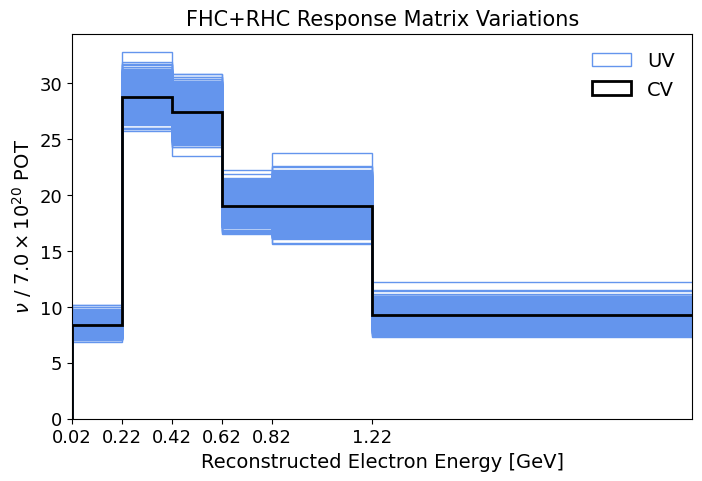

In [64]:
rmatrix_variations = []

fig = plt.figure(figsize=(8, 5)) 
n = 0

for v_fhc, v_rhc in zip(fhc_dict['response_matrix'], rhc_dict['response_matrix']): 
    
    comb_v = [a+b for a,b in zip(v_fhc,v_rhc)]
    rmatrix_variations.append(comb_v)
    
    if n==0: 
        plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
            histtype='step', color='cornflowerblue', linewidth=1, label="UV")
        
    else: 
        plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
            histtype='step', color='cornflowerblue', linewidth=1)
        
    n+=1

plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, 
        weights=[a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])],
        histtype='step', color='black', linewidth=2, label='CV') 
    
plt.xlim(xlow,xhigh)
plt.title("FHC+RHC Response Matrix Variations", fontsize=15)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(fontsize=14, frameon=False)

plt.xlabel("Reconstructed "+x_label, fontsize=14)
plt.ylabel('$\\nu$ / $7.0 \\times 10^{20}$ POT' , fontsize=14)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/rmatrix_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

In [65]:
fhc_rmatrix_dict = calcCov(xvar, bins, fhc_dict['evt_rate'], fhc_dict['evt_rate'], 
                    fhc_dict['response_matrix'], plot=False, save=False) 



number of universes =  1000


In [66]:
rhc_rmatrix_dict = calcCov(xvar, bins, rhc_dict['evt_rate'], rhc_dict['evt_rate'], 
                    rhc_dict['response_matrix'], plot=False, save=False) 

number of universes =  1000


In [67]:
rmatrix_dict = calcCov(xvar, bins, [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
                    [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
                    rmatrix_variations, plot=False, save=False) 

number of universes =  1000


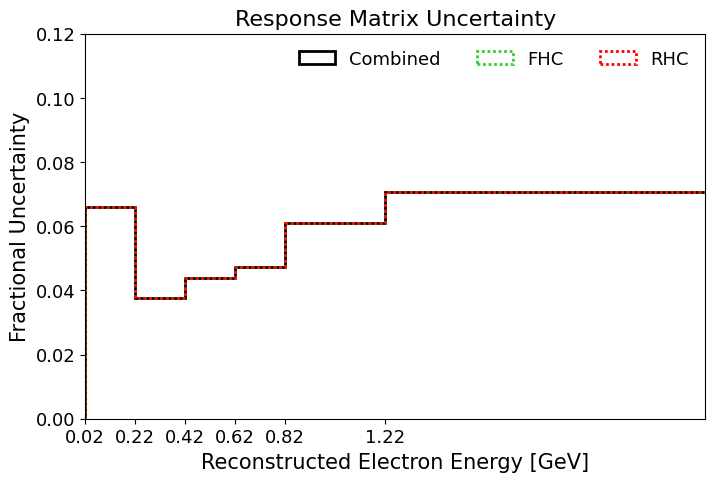

In [68]:
fig = plt.figure(figsize=(8, 5))  

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Combined", 
         weights=rmatrix_dict['fractional_uncertainty'], color='black', linewidth=2)

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC", 
         weights=fhc_rmatrix_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), linewidth=2, color='limegreen')
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="RHC", 
         weights=rhc_rmatrix_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), color='red', linewidth=2)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 0.12)

plt.legend(fontsize=13, frameon=False, ncol=3)
plt.title("Response Matrix Uncertainty", fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/rmatrix_"+xvar+"_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

## Dirt Uncertainty 

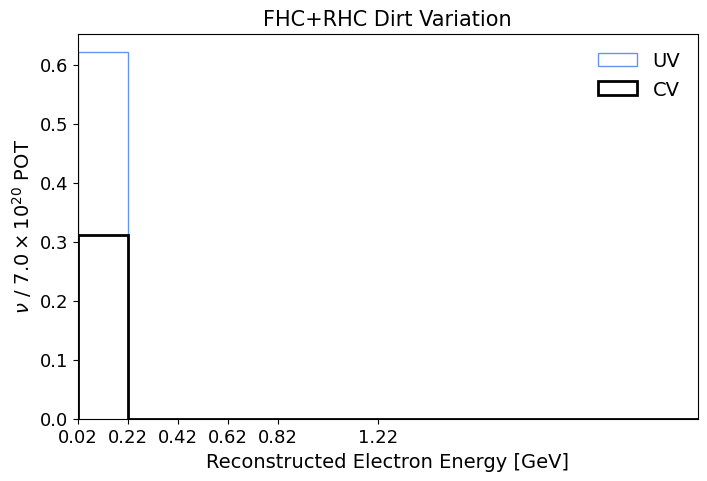

In [69]:
dirt_variations = []

fig = plt.figure(figsize=(8, 5)) 


comb_v = [a+b for a,b in zip(fhc_dict['dirt'],rhc_dict['dirt'])]
dirt_variations.append(comb_v)
    
plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
        histtype='step', color='cornflowerblue', linewidth=1, label='UV')

plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, 
        weights=[a+b for a,b in zip(fhc_dict['cv_dirt'], rhc_dict['cv_dirt'])],
        histtype='step', color='black', linewidth=2, label='CV') 
    
plt.xlim(xlow, xhigh)
plt.title("FHC+RHC Dirt Variation", fontsize=15)
plt.ylabel('$\\nu$ / $7.0 \\times 10^{20}$ POT' , fontsize=14)

plt.legend(fontsize=14, frameon=False)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel('Reconstructed '+x_label, fontsize=14)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/dirt_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')
plt.show()

In [70]:
fhc_dirt_dict = dirt_unisim(xvar, bins, fhc_dict['evt_rate'], fhc_dict['cv_dirt'], 1.0, isrun3=False, plot=False, 
                               x_label=None, title=None)



number of universes =  1


In [71]:
rhc_dirt_dict = dirt_unisim(xvar, bins, rhc_dict['evt_rate'], rhc_dict['cv_dirt'], 1.0, isrun3=True, plot=False, 
                               x_label=None, title=None)

number of universes =  1


In [72]:
dirt_dict = dirt_unisim(xvar, bins, [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
                        [a+b for a,b in zip(fhc_dict['cv_dirt'], rhc_dict['cv_dirt'])], 
                        1.0, plot=False, x_label=None, title=None)

number of universes =  1


In [73]:
fhc_dirt_dict['fractional_uncertainty']

array([0.03723517, 0.        , 0.        , 0.        , 0.        ,
       0.        ])

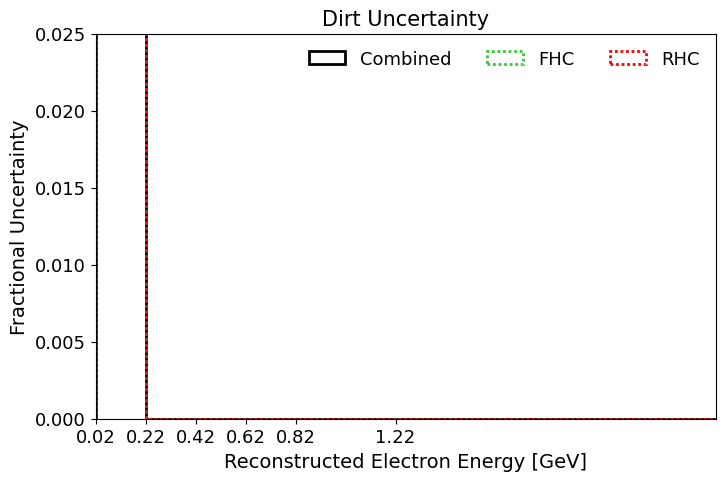

In [74]:
fig = plt.figure(figsize=(8, 5))  

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Combined", 
         weights=dirt_dict['fractional_uncertainty'], color='black', linewidth=2)

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC", 
         weights=fhc_dirt_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), linewidth=2, color='limegreen')
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="RHC", 
         weights=rhc_dirt_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), color='red', linewidth=2)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xlim(xlow, xhigh)
plt.ylim(0, 0.025)

plt.legend(fontsize=13, frameon=False, ncol=3)
plt.title("Dirt Uncertainty", fontsize=15)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/dirt_"+xvar+"_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

## POT counting 

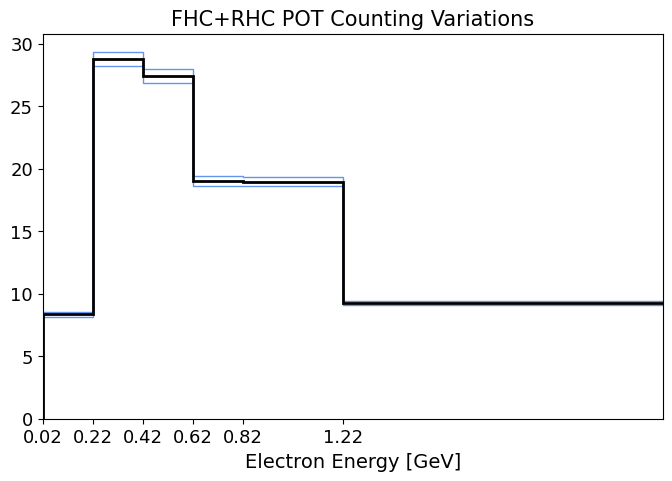

In [75]:
pot_variations = []

fig = plt.figure(figsize=(8, 5)) 

for v_fhc, v_rhc in zip(fhc_dict['pot_counting'], rhc_dict['pot_counting']): 
    
    comb_v = [a+b for a,b in zip(v_fhc,v_rhc)]
    pot_variations.append(comb_v)
    
    plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, weights=comb_v,
        histtype='step', color='cornflowerblue', linewidth=1)

plt.hist(0.5*(np.array(bins)[1:]+np.array(bins)[:-1]), bins, 
        weights=[a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])],
        histtype='step', color='black', linewidth=2) 
    
plt.xlim(xlow, xhigh)
plt.title("FHC+RHC POT Counting Variations", fontsize=15)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel(x_label, fontsize=14)
plt.show()

In [76]:
pot_dict = calcCov(xvar, bins, [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
                    [a+b for a,b in zip(fhc_dict['evt_rate'], rhc_dict['evt_rate'])], 
                    pot_variations, plot=False, save=False) 

number of universes =  2


# Full Uncertainty 

In [77]:
xvar

'shr_energy_cali'

### FHC only 

In [78]:
fhc_frac_cov_dict = {
        #'ppfx' : fhc_ppfx_dict['frac_cov'], 
        #'beamline' : fhc_beamline_unisim_dict['frac_cov'], 
        'genie_ms' : fhc_genie_dict['frac_cov'], 
        'genie_us': fhc_genie_unisim_dict['frac_cov'], 
        #'geant4' : fhc_geant4_dict['frac_cov'],
        #'detector' :  [ [0]*(len(bins)-1) for x in range(len(bins)-1) ], 
        #'pot_counting' : pot_dict['frac_cov'], #[ [round(0.02**2, 5)]*(len(bins)-1) for x in range(len(bins)-1) ], 
        #'dirt' : fhc_dirt_dict['frac_cov'],
        'response_matrix' : fhc_rmatrix_dict['frac_cov'], 
        'stat' : fhc_frac_stat_cov
    }

#for i in range(len(bins)-1): 
#        fhc_frac_cov_dict['detector'][i][i] = parameters(ISRUN3=False)['detsys_flat']**2


Note: Input must be fractional covariance matrices !


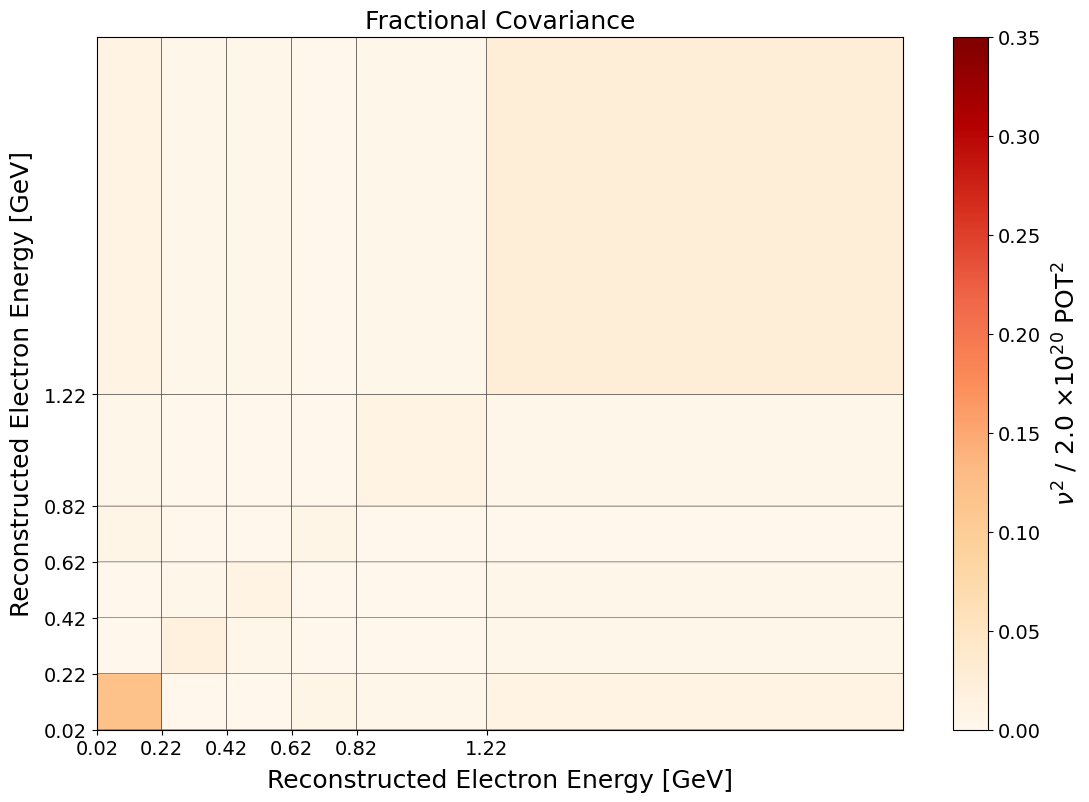

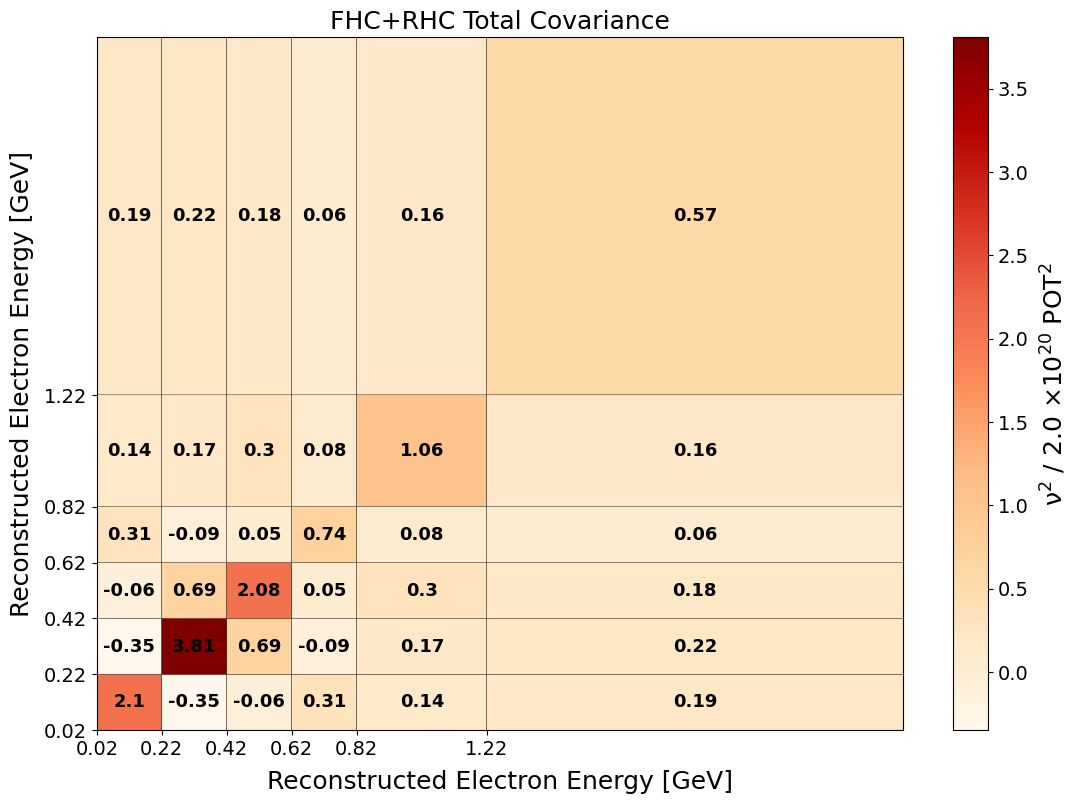

In [79]:
fhc_tot_frac_cov, fhc_tot_abs_cov = plotFullCov(fhc_frac_cov_dict, xvar, fhc_dict['evt_rate'], 
                                                bins, xlow, xhigh, x_ticks=x_ticks, save=False, bincenters=bincenters, 
                                                axis_label='Reconstructed '+x_label, pot="2.0 $\\times 10^{20}$ POT")
    

In [80]:
# add genie in quadrature
fhc_frac_cov_dict['genie_all'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(fhc_frac_cov_dict['genie_ms'], fhc_frac_cov_dict['genie_us'])]

# add stat in quadrature 
fhc_frac_cov_dict['stat_all'] = [ [x+y for x,y in zip(b,c)] for b,c in zip(fhc_frac_cov_dict['response_matrix'], fhc_frac_cov_dict['stat'])]

# add ppfx & beamline geometry in quadrature
#fhc_frac_cov_dict['flux_all'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(fhc_frac_cov_dict['ppfx'], fhc_frac_cov_dict['beamline'])]


In [81]:
fhc_frac_unc_dict = {
        #'flux_all' : np.sqrt(np.diagonal(fhc_frac_cov_dict['flux_all'])), 
        'genie_all' : np.sqrt(np.diagonal(fhc_frac_cov_dict['genie_all'])), 
        #'geant4' : np.sqrt(np.diagonal(fhc_frac_cov_dict['geant4'])),
        #'detector' : np.sqrt(np.diagonal(fhc_frac_cov_dict['detector'])), 
        #'pot_counting' : np.sqrt(np.diagonal(fhc_frac_cov_dict['pot_counting'])), 
        #'dirt' : np.sqrt(np.diagonal(fhc_frac_cov_dict['dirt'])),
        'stat_all' : np.sqrt(np.diagonal(fhc_frac_cov_dict['stat_all'])), 
        #'total' : np.sqrt(np.diagonal(fhc_tot_frac_cov))
    }

KeyError: 'flux_all'

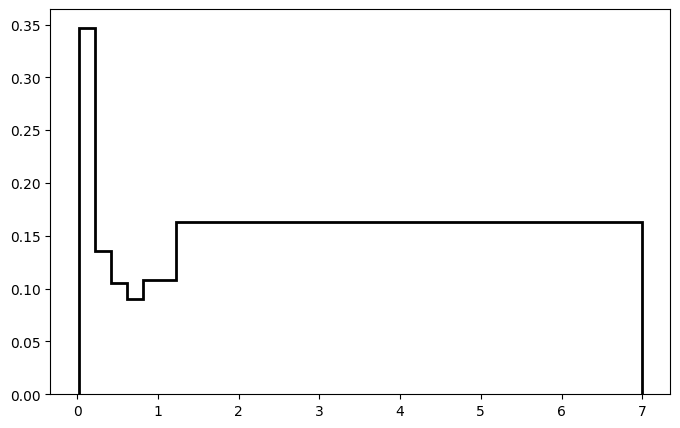

In [82]:
fig = plt.figure(figsize=(8, 5))  

# TOTAL 
plt.hist(bincenters, bins, histtype='step', weights=np.sqrt(np.diag(fhc_tot_frac_cov)), color='black', 
            linewidth=2, label='Total')

# FLUX
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Flux", 
             weights=fhc_frac_unc_dict['flux_all'])#, color='royalblue')

# CROSS SECTION MODELS 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GENIE", 
             weights=fhc_frac_unc_dict['genie_all'])#, color='goldenrod')

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GEANT4", 
             weights=fhc_frac_unc_dict['geant4'])#, color='green')

# DETECTOR 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Detector", 
             weights=fhc_frac_unc_dict['detector'])#, color='crimson')

# POT COUNTING 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="POT counting",
        weights=fhc_frac_unc_dict['pot_counting'])#, color='purple')

# DIRT 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Dirt",
            weights=fhc_frac_unc_dict['dirt'])#, color='brown')

# STATISTICAL 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Stat",
            weights=fhc_frac_unc_dict['stat_all'])#, color='hotpink')



plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 1.05)

plt.legend(fontsize=13, frameon=False, ncol=3)
plt.title("FHC Background-Subtracted Event Rate Uncertainty", fontsize=16)

    #if isNuWro: 
    #    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/nuwro_nosys_"+xvar+"_FracUncertainty.pdf", 
    #                transparent=True, bbox_inches='tight')


    #    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/nuwro_"+xvar+"_FracUncertainty.pdf", 
    #                transparent=True, bbox_inches='tight')

plt.show()

In [84]:
fhc_abs_cov_dict = {
        #'ppfx' : fhc_ppfx_dict['cov'], 
        #'beamline' : fhc_beamline_unisim_dict['cov'], 
        'genie_ms' : fhc_genie_dict['cov'], 
        'genie_us': fhc_genie_unisim_dict['cov'], 
        #'geant4' : fhc_geant4_dict['cov'],
        #'detector' : [ [0]*(len(bins)-1) for x in range(len(bins)-1) ], 
        #'pot_counting' : [ [0]*(len(bins)-1) for x in range(len(bins)-1) ], 
        #'dirt' : fhc_dirt_dict['cov'],
        'response_matrix' : fhc_rmatrix_dict['cov'], 
        'stat' : [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

}
    
# convert the detector & stat uncertainty into an absolute covariance (multiply by event rate)
for i in range(len(bins)-1): 
    for j in range(len(bins)-1): 
        
        #if i==j: 
            #fhc_abs_cov_dict['detector'][i][j] = (0.12187*0.12187) * fhc_dict['evt_rate'][i] * fhc_dict['evt_rate'][j]
        
        fhc_abs_cov_dict['stat'][i][j] = fhc_frac_stat_cov[i][j] * fhc_dict['evt_rate'][i] * fhc_dict['evt_rate'][j]
        #fhc_abs_cov_dict['pot_counting'][i][j] = (0.02*0.02) * fhc_dict['evt_rate'][i] * fhc_dict['evt_rate'][j]
        
            


### RHC only 

In [85]:
rhc_frac_cov_dict = {
        'ppfx' : rhc_ppfx_dict['frac_cov'], 
        'beamline' : rhc_beamline_unisim_dict['frac_cov'], 
        'genie_ms' : rhc_genie_dict['frac_cov'], 
        'genie_us': rhc_genie_unisim_dict['frac_cov'], 
        'geant4' : rhc_geant4_dict['frac_cov'],
        'detector' :  [ [0]*(len(bins)-1) for x in range(len(bins)-1) ],
        'pot_counting' : pot_dict['frac_cov'], #[ [round(0.02**2, 5)]*(len(bins)-1) for x in range(len(bins)-1) ],  
        'dirt' : rhc_dirt_dict['frac_cov'],
        'response_matrix' : rhc_rmatrix_dict['frac_cov'], 
        'stat' : rhc_frac_stat_cov
    }

for i in range(len(bins)-1): 
         rhc_frac_cov_dict['detector'][i][i] = parameters(ISRUN3=True)['detsys_flat']**2



Note: Input must be fractional covariance matrices !


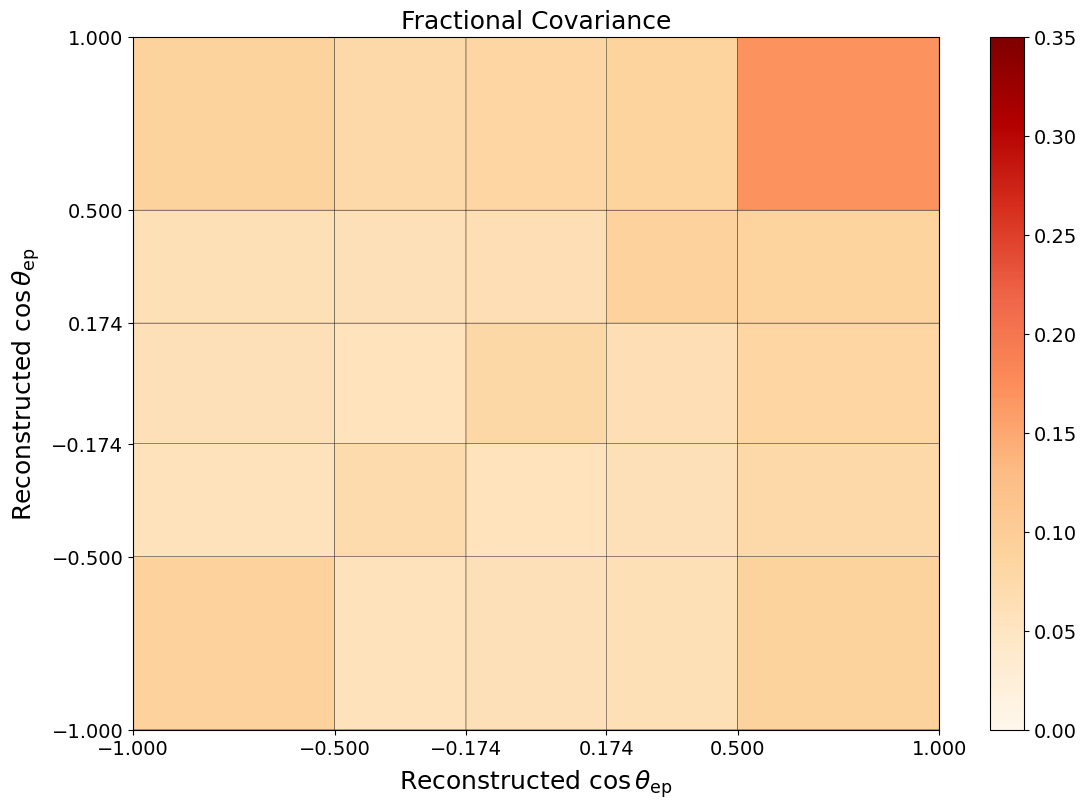

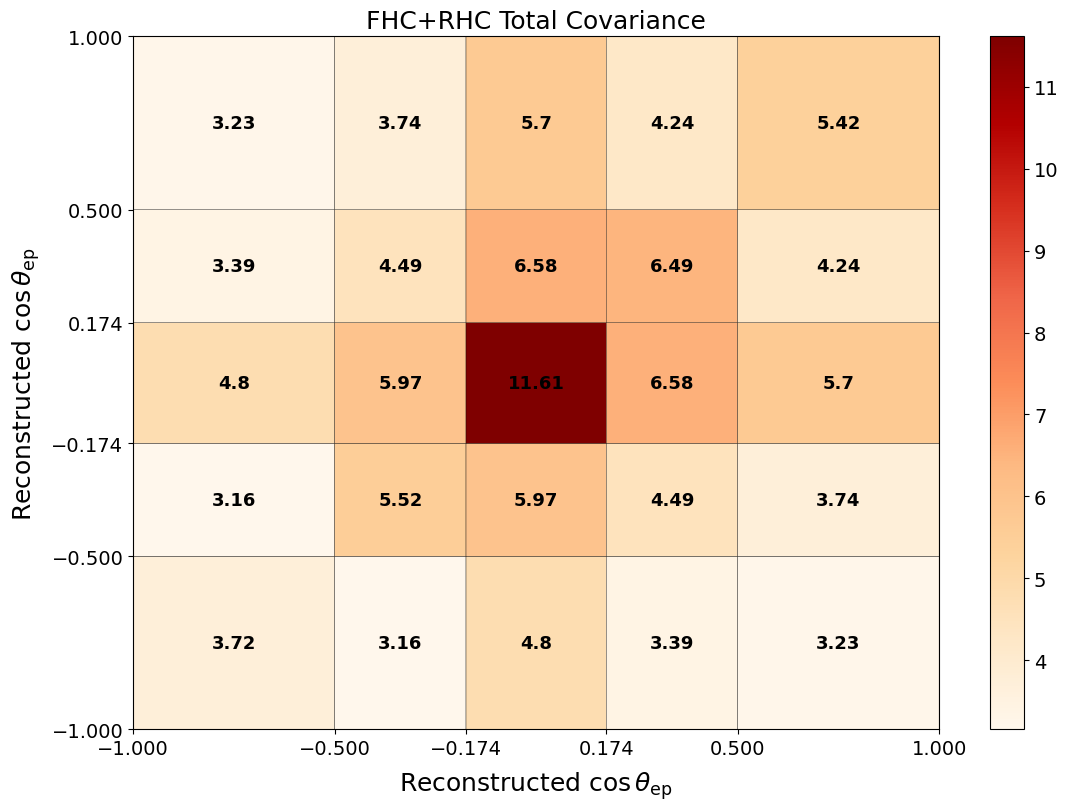

In [86]:
rhc_tot_frac_cov, rhc_tot_abs_cov = plotFullCov(rhc_frac_cov_dict, xvar, rhc_dict['evt_rate'], 
                                                bins, xlow, xhigh, x_ticks=x_ticks, save=False, bincenters=bincenters, 
                                                axis_label='Reconstructed '+x_label)


In [87]:
# add genie in quadrature
rhc_frac_cov_dict['genie_all'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(rhc_frac_cov_dict['genie_ms'], rhc_frac_cov_dict['genie_us'])]

# add stat in quadrature 
rhc_frac_cov_dict['stat_all'] = [ [x+y for x,y in zip(b,c)] for b,c in zip(rhc_frac_cov_dict['response_matrix'], rhc_frac_cov_dict['stat'])]

# add ppfx & beamline geometry in quadrature
rhc_frac_cov_dict['flux_all'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(rhc_frac_cov_dict['ppfx'], rhc_frac_cov_dict['beamline'])]


In [88]:
rhc_frac_unc_dict = {
        'flux_all' : np.sqrt(np.diagonal(rhc_frac_cov_dict['flux_all'])), 
        'genie_all' : np.sqrt(np.diagonal(rhc_frac_cov_dict['genie_all'])), 
        'geant4' : np.sqrt(np.diagonal(rhc_frac_cov_dict['geant4'])),
        'detector' : np.sqrt(np.diagonal(rhc_frac_cov_dict['detector'])), 
        'pot_counting' : np.sqrt(np.diagonal(rhc_frac_cov_dict['pot_counting'])), 
        'dirt' : np.sqrt(np.diagonal(rhc_frac_cov_dict['dirt'])),
        'stat_all' : np.sqrt(np.diagonal(rhc_frac_cov_dict['stat_all'])), 
        'total' : np.sqrt(np.diagonal(rhc_tot_frac_cov))
    }

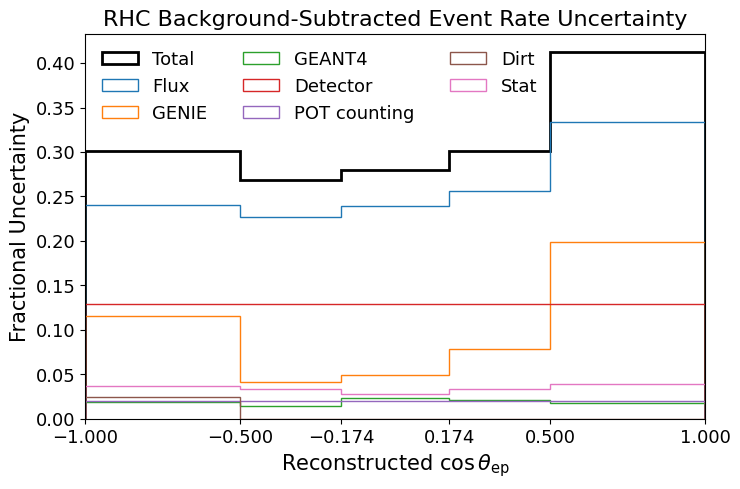

In [89]:
fig = plt.figure(figsize=(8, 5))  

# TOTAL 
plt.hist(bincenters, bins, histtype='step', weights=np.sqrt(np.diag(rhc_tot_frac_cov)), color='black', 
            linewidth=2, label='Total')

# FLUX
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Flux", 
             weights=rhc_frac_unc_dict['flux_all'])#, color='royalblue')

# CROSS SECTION MODELS 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GENIE", 
             weights=rhc_frac_unc_dict['genie_all'])#, color='goldenrod')

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GEANT4", 
             weights=rhc_frac_unc_dict['geant4'])#, color='green')

# DETECTOR 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Detector", 
             weights=rhc_frac_unc_dict['detector'])#, color='crimson')

# POT COUNTING 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="POT counting",
            weights=rhc_frac_unc_dict['pot_counting'])#, color='purple')

# DIRT 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Dirt",
            weights=rhc_frac_unc_dict['dirt'])#, color='brown')

# STATISTICAL 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Stat",
            weights=rhc_frac_unc_dict['stat_all'])#, color='hotpink')

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
#plt.ylim(0, 1.05)

plt.legend(fontsize=13, frameon=False, ncol=3)
plt.title("RHC Background-Subtracted Event Rate Uncertainty", fontsize=16)

plt.show()

## FHC + RHC TOTAL COVARIANCE  

In [90]:
frac_cov_dict = {
        'ppfx' : ppfx_dict['frac_cov'], 
        'beamline' : beamline_unisim_dict['frac_cov'], 
        'genie_ms' : genie_dict['frac_cov'], 
        'genie_us': genie_unisim_dict['frac_cov'], 
        'geant4' : geant4_dict['frac_cov'],
        'detector' : avg_detsys_dict['frac_cov'], 
        'pot_counting' : pot_dict['frac_cov'], 
        'dirt' : dirt_dict['frac_cov'],
        'response_matrix' : rmatrix_dict['frac_cov'], 
        'stat' : frac_stat_cov

}
    
abs_cov_dict = {
        'ppfx' : ppfx_dict['cov'], 
        'beamline' : beamline_unisim_dict['cov'], 
        'genie_ms' : genie_dict['cov'], 
        'genie_us': genie_unisim_dict['cov'], 
        'geant4' : geant4_dict['cov'],
        'detector' : [ [0]*(len(bins)-1) for x in range(len(bins)-1) ], 
        'pot_counting' : pot_dict['cov'], 
        'dirt' : dirt_dict['cov'],
        'response_matrix' : rmatrix_dict['cov'], 
        'stat' : [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

}
    
# convert the detector & stat uncertainty into an absolute covariance (multiply by event rate)
for i in range(len(bins)-1): 
    for j in range(len(bins)-1): 
        abs_cov_dict['detector'][i][j] = avg_detsys_dict['frac_cov'][i][j] * evt_rate[i] * evt_rate[j]
        abs_cov_dict['stat'][i][j] = frac_stat_cov[i][j] * evt_rate[i] * evt_rate[j]


Note: Input must be fractional covariance matrices !


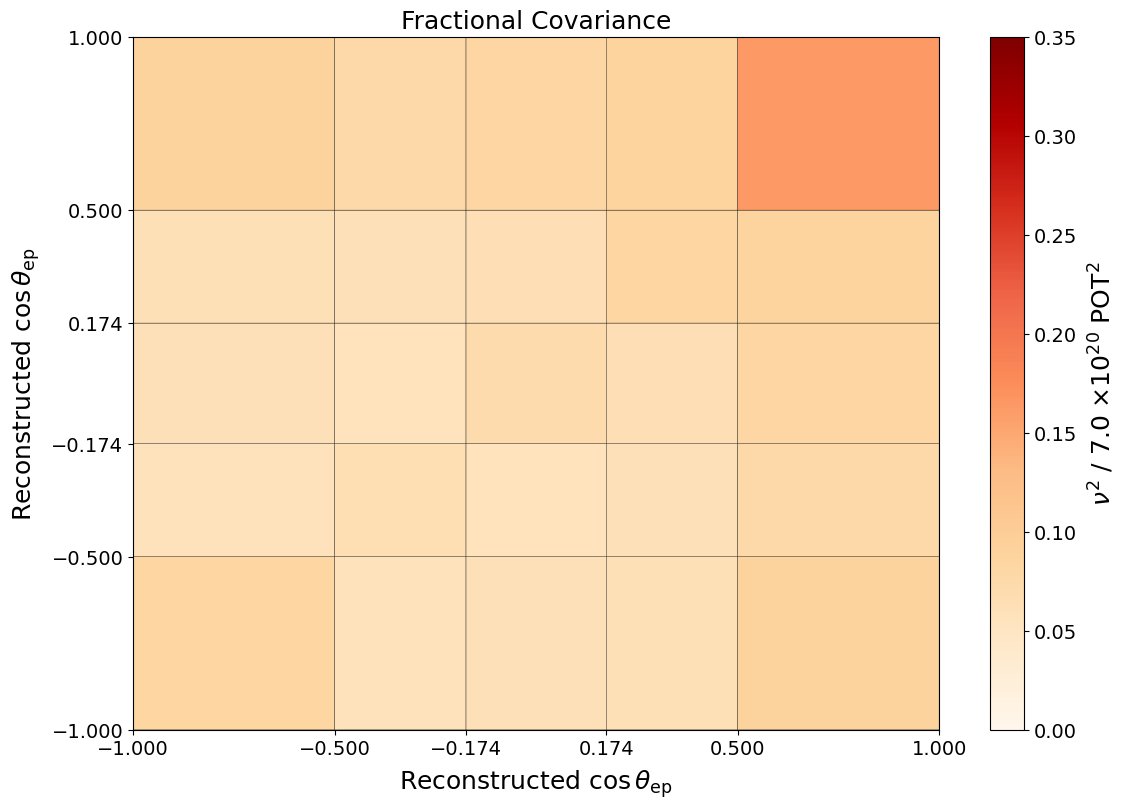

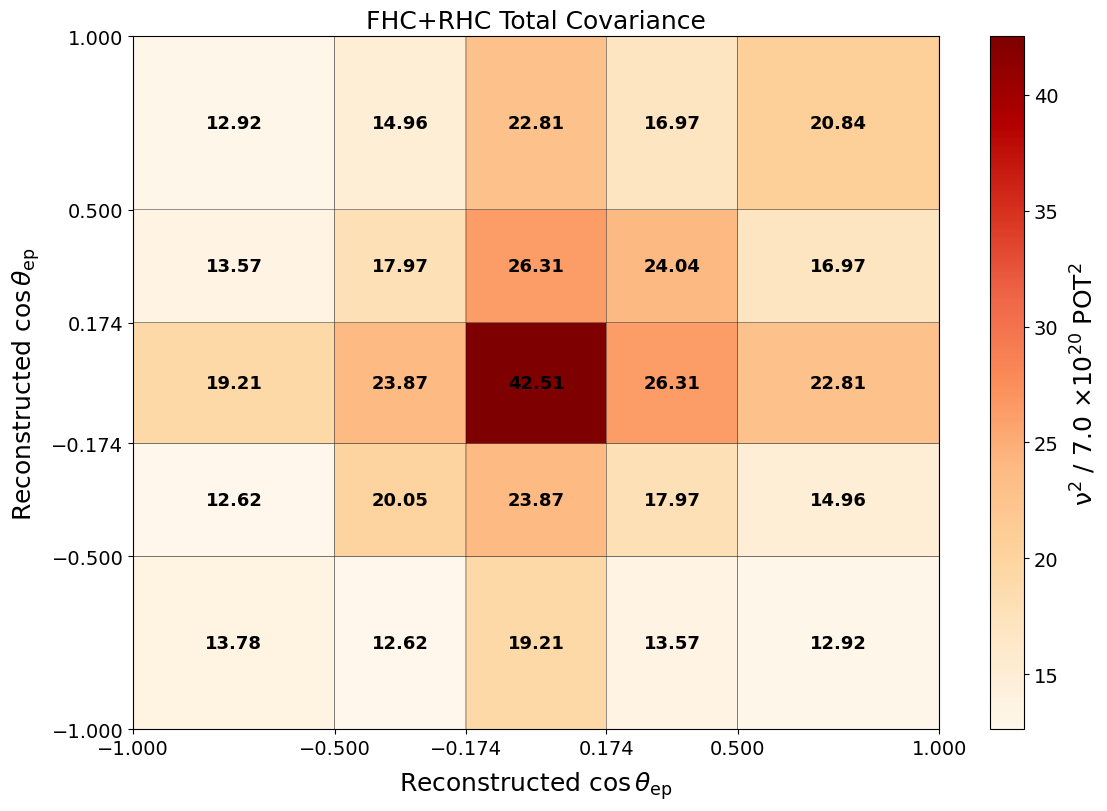

In [91]:
tot_frac_cov, tot_abs_cov = plotFullCov(frac_cov_dict, xvar, evt_rate, bins, xlow, xhigh, save=False, bincenters=bincenters, x_ticks=x_ticks,
                      axis_label='Reconstructed '+x_label, pot="7.0 $\\times 10^{20}$ POT") 

abs_cov_dict['total'] = tot_abs_cov

In [92]:
np.sqrt(np.diagonal(tot_frac_cov))

array([0.28932076, 0.25527107, 0.26772298, 0.28950715, 0.40395975])

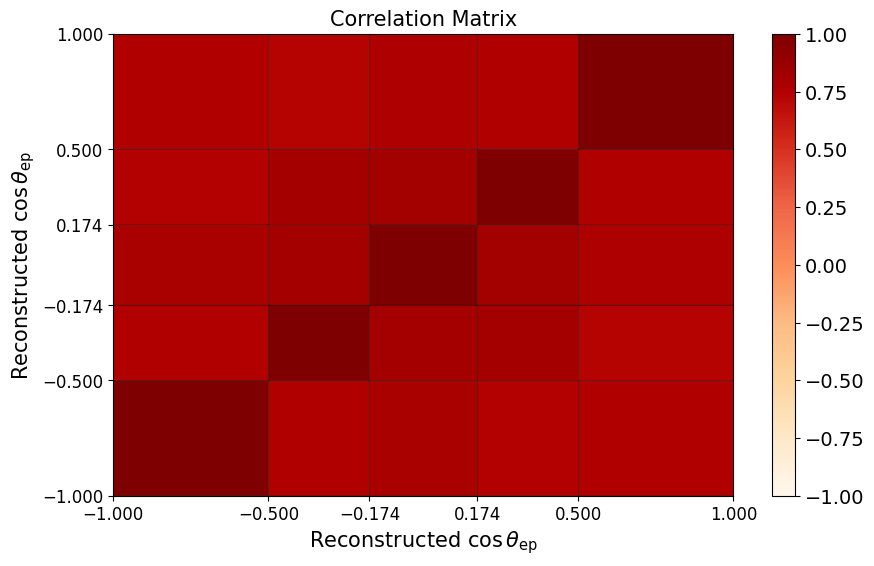

In [93]:
## correlation matrix

tot_cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for i in range(len(bincenters)): 
    for j in range(len(bincenters)): 
        tot_cor[i][j] = tot_abs_cov[i][j] / (np.sqrt(tot_abs_cov[i][i])*np.sqrt(tot_abs_cov[j][j]))
        
# CORRELATION MATRIX 

fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, tot_cor, cmap='OrRd', edgecolors='k', vmin=-1, vmax=1)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Reconstructed "+x_label, fontsize=15)
plt.ylabel("Reconstructed "+x_label, fontsize=15)

plt.xticks(x_ticks, fontsize=12)
plt.yticks(x_ticks, fontsize=12)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

plt.title('Correlation Matrix', fontsize=15)

#if isData: 
#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/cor_"+xvar+".pdf", 
#                transparent=True, bbox_inches='tight')

plt.show()

In [94]:
# add ppfx & beamline geometry in quadrature
frac_cov_dict['flux_all'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(frac_cov_dict['ppfx'], frac_cov_dict['beamline'])]


In [95]:
# add genie in quadrature
frac_cov_dict['genie_all'] = [ [x+y for x,y in zip(a,b)] for a,b in zip(frac_cov_dict['genie_ms'], frac_cov_dict['genie_us'])]
frac_cov_dict['stat_all'] = [ [x+y for x,y in zip(b,c)] for b,c in zip(frac_cov_dict['response_matrix'], frac_cov_dict['stat'])]


In [96]:
frac_cov_dict.keys()

dict_keys(['ppfx', 'beamline', 'genie_ms', 'genie_us', 'geant4', 'detector', 'pot_counting', 'dirt', 'response_matrix', 'stat', 'flux_all', 'genie_all', 'stat_all'])

In [97]:
# clean away nans
v = np.array(tot_frac_cov)
v[np.isnan(v)] = 0
tot_frac_cov = v

In [98]:
frac_unc_dict = {
        'flux_all' : np.sqrt(np.diagonal(frac_cov_dict['flux_all'])), 
        'genie_all' : np.sqrt(np.diagonal(frac_cov_dict['genie_all'])), 
        'geant4' : np.sqrt(np.diagonal(frac_cov_dict['geant4'])),
        'detector' : np.sqrt(np.diagonal(frac_cov_dict['detector'])), 
        'pot_counting' : np.sqrt(np.diagonal(frac_cov_dict['pot_counting'])), 
        'dirt' : np.sqrt(np.diagonal(frac_cov_dict['dirt'])),
        'stat_all' : np.sqrt(np.diagonal(frac_cov_dict['stat_all'])), # does this include beam on stat (indirectly)? 
        'total' : np.sqrt(np.diagonal(tot_frac_cov))
}

In [99]:
frac_unc_dict['total']

array([0.28932076, 0.25527107, 0.26772298, 0.28950715, 0.40395975])

## Uncertainty Breakdown

In [100]:
for key in frac_unc_dict.keys(): 
    
    if key=='stat_all': 
        print("beam-on stat:", np.round( np.average( [np.sqrt(a)/a for a in delta_n_data2] )*100, 1))
        
        # fractional uncertainty on the event count 
        f = [np.sqrt(a+b)/d for a,b,d in zip(mc_bkgd_sumw2, ext_sumw2, evt_rate)]
        
        # add in quadrature with fractional uncertainty on th eresponse matrix 
        print('mc+ext stat:', np.round(np.average([np.sqrt(a**2 + b**2) for a,b in zip(f, rmatrix_dict['fractional_uncertainty']) ])*100, 1))
        print(key, ":", np.round(np.average(frac_unc_dict[key])*100, 1))
    else: 
        print(key, ":", np.round(np.average(frac_unc_dict[key])*100, 1))

flux_all : 26.0
genie_all : 9.7
geant4 : 1.9
detector : 10.0
pot_counting : 2.0
dirt : 0.5


NameError: name 'delta_n_data2' is not defined

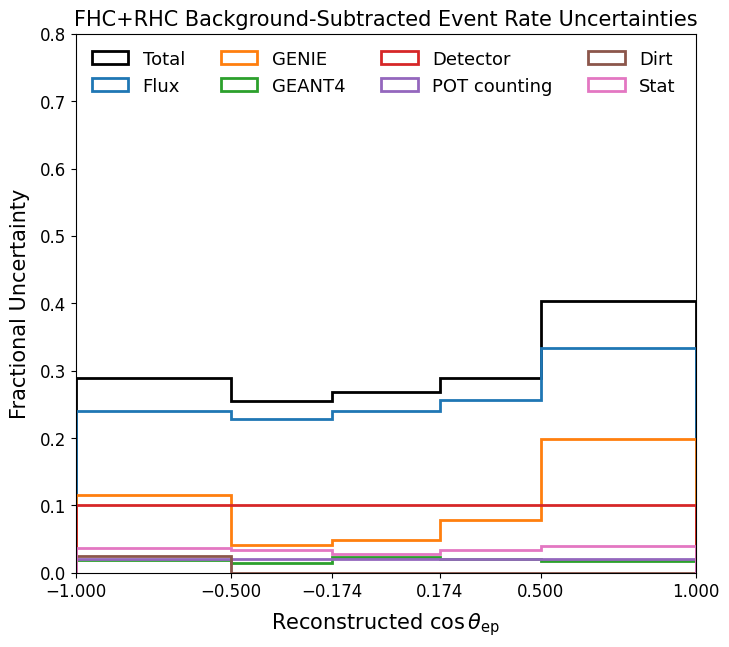

In [101]:
fig = plt.figure(figsize=(8, 7))  

# TOTAL 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Total",
            weights=frac_unc_dict['total'], linewidth=2, color='black')

# FLUX
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Flux", 
         weights=frac_unc_dict['flux_all'], linewidth=2)#, color='royalblue')

 # CROSS SECTION MODELS 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GENIE", 
             weights=frac_unc_dict['genie_all'], linewidth=2)#, color='goldenrod')

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GEANT4", 
             weights=frac_unc_dict['geant4'], linewidth=2)#, color='green')

# DETECTOR 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Detector", 
             weights=frac_unc_dict['detector'], linewidth=2)#, color='crimson')

# POT COUNTING 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="POT counting",
            weights=frac_unc_dict['pot_counting'], linewidth=2)#, color='purple')

# DIRT 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Dirt",
            weights=frac_unc_dict['dirt'], linewidth=2)#, color='brown')

# STATISTICAL 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Stat",
            weights=frac_unc_dict['stat_all'], linewidth=2)#, color='hotpink')


plt.xticks(x_ticks, fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Reconstructed " + x_label, fontsize=15, labelpad=7)
plt.ylabel("Fractional Uncertainty", fontsize=15, labelpad=7)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 0.8)

plt.legend(fontsize=13, frameon=False, ncol=4, loc='upper left')
plt.title("FHC+RHC Background-Subtracted Event Rate Uncertainties", fontsize=15)

#plt.savefig("/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/plots/combined/"+xvar+"_Uncertainty.svg", bbox_inches='tight')


plt.show()

In [102]:
frac_unc_dict['total']*100

array([28.93207567, 25.52710718, 26.77229796, 28.95071488, 40.3959749 ])

In [103]:
frac_unc_dict['flux_all']*100

array([24.00396089, 22.74833044, 23.98084875, 25.65015971, 33.37118615])

In [104]:
# ppfx portion of the flux 
np.sqrt(np.diagonal(ppfx_dict['frac_cov']))*100

array([23.81122939, 22.57871548, 23.80269908, 25.30620233, 33.01240103])

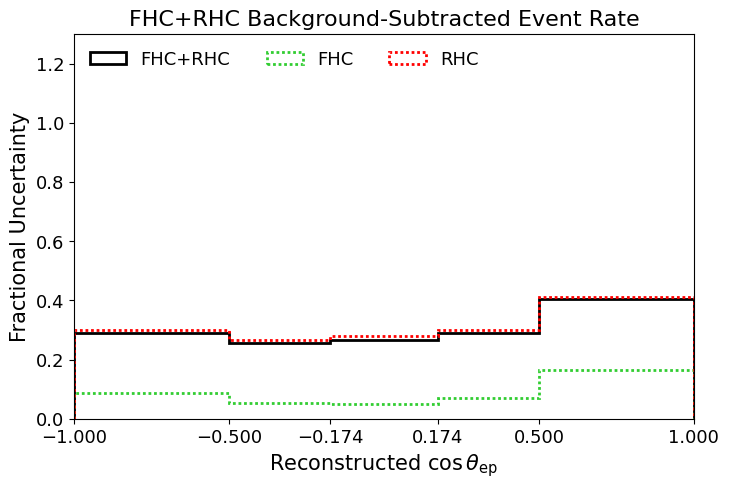

In [105]:
fig = plt.figure(figsize=(8, 5))  

# TOTAL 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC+RHC",
        weights=frac_unc_dict['total'], linewidth=2, color='black')

# FHC

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="FHC", 
         weights=np.sqrt(np.diag(fhc_tot_frac_cov)), 
         linestyle=(0, (1, 1)), linewidth=2, color='limegreen')

# RHC
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="RHC", 
         weights=np.sqrt(np.diag(rhc_tot_frac_cov)), 
         linestyle=(0, (1, 1)), color='red', linewidth=2)


plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 1.3)

plt.legend(fontsize=13, frameon=False, ncol=3, loc='upper left')
plt.title("FHC+RHC Background-Subtracted Event Rate", fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/"+xvar+"_FracUncertainty_comparison.pdf", transparent=True, bbox_inches='tight')


plt.show()

## Background subtracted event rate 

In [106]:
x_err = []
for x in range(len(bincenters)):
    x_err.append(round(abs((x_ticks+[xhigh][:-1]+[xhigh])[x+1]-(x_ticks+[xhigh][:-1]+[xhigh])[x])/2, 2))

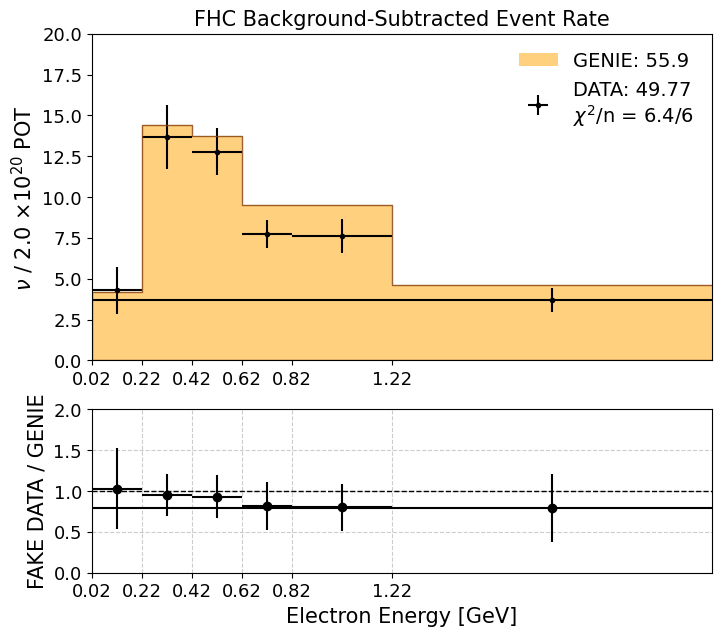

In [85]:
fig = plt.figure(figsize=(8, 7))

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
    
ax1.tick_params(axis = 'both', which = 'major', labelsize = 13)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 13)
    
ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)

ax1.set_xticks(bins[:-1])
ax2.set_xticks(bins[:-1])

ax1.set_xlim(bins[0], xhigh)
ax2.set_xlim(bins[0], xhigh)


## PREDICTION ## 

fhc_n_genie = ax1.hist(bincenters, bins, histtype='bar', weights=fhc_dict['evt_rate'], color='orange', alpha=0.5,
            label='GENIE: '+str(round(sum(fhc_dict['evt_rate']), 2)))[0]

#

fhc_genie_frac_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
for i in range(len(bins)-1): 
    fhc_genie_frac_stat_cov[i][i] = fhc_dict['mc_signal_sumw2'][i]/(fhc_n_genie[i]**2)

## CHI2 COMPARISON ##

# include genie stat covariance
fhc_cov_chi2 = np.array(fhc_tot_frac_cov) + np.array(fhc_genie_frac_stat_cov)

# convert to absolute units
for i in range(len(bins)-1): 
     for j in range(len(bins)-1): 
            fhc_cov_chi2[i][j] = fhc_cov_chi2[i][j] * (fhc_n_genie[i] **2)

fhc_inverse_cov_chi2 = np.linalg.inv(fhc_cov_chi2)
fhc_chi2 = 0

for i in range(len(bins)-1): 
    for j in range(len(bins)-1): 
            fhc_chi2 = fhc_chi2  + ( (fhc_n_genie[i]-fhc_dict['evt_rate_nuwro_ppfx'][i])*fhc_inverse_cov_chi2[i][j]*(fhc_n_genie[j]-fhc_dict['evt_rate_nuwro_ppfx'][j]) )


## DATA ## 

ax1.errorbar(bincenters, fhc_dict['evt_rate_nuwro_ppfx'], yerr=np.sqrt(np.diag(fhc_tot_abs_cov)), xerr=x_err, 
             color="black", fmt='o', markersize=3, 
             label='DATA: '+str(round(sum(fhc_dict['evt_rate_nuwro_ppfx']),2))+"\n$\\chi^{2}$/n = "+str(round(fhc_chi2, 1))+"/"+str(len(bins)-1))[0]


ax1.step(list(bins)+[0], [0]+list(fhc_n_genie)+[0], 
         color='saddlebrown', linewidth=1, alpha=0.85)



plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)


ax2.set_xlabel(x_label, fontsize=15)

plt.xlim(bins[0], xhigh)
ax1.set_ylim(0, 20)
ax2.errorbar(bincenters, fhc_dict['evt_rate_nuwro_ppfx']/fhc_n_genie, 
             yerr=get_ratio_err(fhc_dict['evt_rate_nuwro_ppfx'], fhc_n_genie), 
             xerr=x_err, color="black", fmt='o')
ax2.set_ylim(0, 2)
ax2.set_ylabel("FAKE DATA / GENIE", fontsize=15)
ax2.axhline(1.0, color='black', lw=1, linestyle='--')

ax1.set_title("FHC Background-Subtracted Event Rate", fontsize=15)
ax1.set_ylabel("$\\nu$ / 2.0 $\\times 10^{20}$ POT", fontsize=15)

    
ax1.legend(frameon=False, fontsize=14)

plt.show()
     

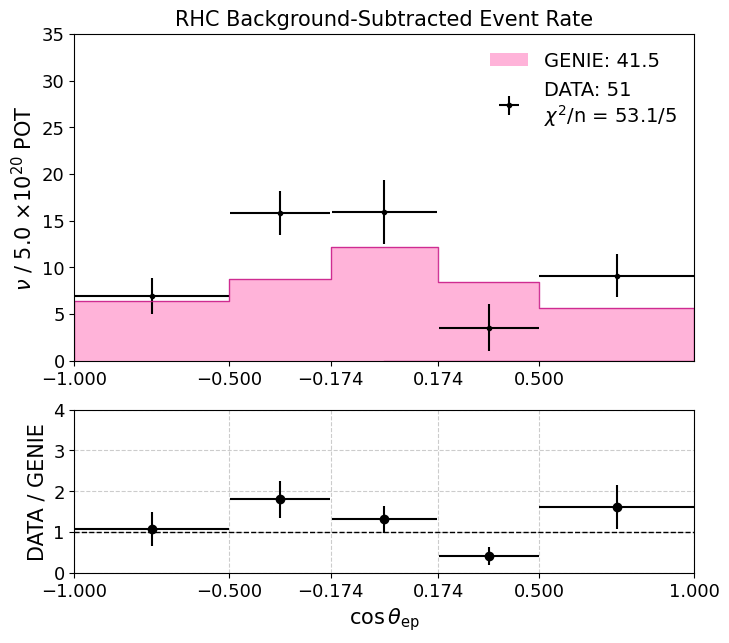

In [108]:
fig = plt.figure(figsize=(8, 7))

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
    
ax1.tick_params(axis = 'both', which = 'major', labelsize = 13)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 13)
    
ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)

ax1.set_xticks(bins[:-1])
ax2.set_xticks(bins[:-1])

ax1.set_xlim(bins[0], xhigh)
ax2.set_xlim(bins[0], xhigh)


############# GENIE PREDICTION #############

rhc_n_genie = ax1.hist(bincenters, bins, histtype='bar', weights=rhc_dict['evt_rate'], color='hotpink', alpha=0.5,
            label='GENIE: '+str(round(sum(rhc_dict['evt_rate']), 1)))[0]

# Colour originally 'orange'!

rhc_genie_frac_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
for i in range(len(bins)-1): 
    rhc_genie_frac_stat_cov[i][i] = rhc_dict['mc_signal_sumw2'][i]/(rhc_n_genie[i]**2)

############# CHI2 COMPARISON #############

# include genie stat covariance
rhc_cov_chi2 = np.array(rhc_tot_frac_cov) + np.array(rhc_genie_frac_stat_cov)

# convert to absolute units
for i in range(len(bins)-1): 
     for j in range(len(bins)-1): 
            rhc_cov_chi2[i][j] = rhc_cov_chi2[i][j] * (rhc_n_genie[i] **2)

rhc_inverse_cov_chi2 = np.linalg.inv(rhc_cov_chi2)
rhc_chi2 = 0

for i in range(len(bins)-1): 
    for j in range(len(bins)-1): 
            rhc_chi2 = rhc_chi2  + ( (rhc_n_genie[i]-rhc_dict['beamon_counts'][i])*rhc_inverse_cov_chi2[i][j]*(rhc_n_genie[j]-rhc_dict['beamon_counts'][j]) )

            
############# DATA RESULT #############

ax1.errorbar(bincenters, rhc_dict['beamon_counts'], yerr=np.sqrt(np.diag(rhc_tot_abs_cov)), xerr=x_err, 
             color="black", fmt='o', markersize=3, 
             label='DATA: '+str(int(sum(rhc_dict['beamon_counts'])))+"\n$\\chi^{2}$/n = "+str(round(rhc_chi2, 1))+"/"+str(len(bins)-1))[0]


ax1.step(list(bins)+[0], [0]+list(rhc_n_genie)+[0], 
         color='mediumvioletred', linewidth=1, alpha=0.85)

# Colour originally 'saddlebrown'!

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)


ax2.set_xlabel(x_label, fontsize=15)


ax1.set_ylim(0, 35)

ax2.errorbar(bincenters, rhc_dict['beamon_counts']/rhc_n_genie, 
             yerr=get_ratio_err(rhc_dict['beamon_counts'], rhc_n_genie), 
             xerr=x_err, color="black", fmt='o')
ax2.set_ylim(0, 4) # Originally (0,2)
ax2.set_ylabel("DATA / GENIE", fontsize=15)
ax2.axhline(1.0, color='black', lw=1, linestyle='--')

ax1.set_title("RHC Background-Subtracted Event Rate", fontsize=15)
ax1.set_ylabel("$\\nu$ / 5.0 $\\times 10^{20}$ POT", fontsize=15)

ax1.legend(frameon=False, fontsize=14)

#plt.savefig("/exp/uboone/app/users/abarnard/plots/new_run3.pdf", bbox_inches='tight', dpi=1000)


plt.show()


[9.119623654262146, 9.119623654262146, 13.063552032458633, 17.832930406095045, 12.032834133442236, 6.736333953260208]
[16.544904301741095, 16.544904301741095, 22.019151320241917, 30.8724909311249, 21.838960953969234, 15.867286998810535]


NameError: name 'beamon_counts' is not defined

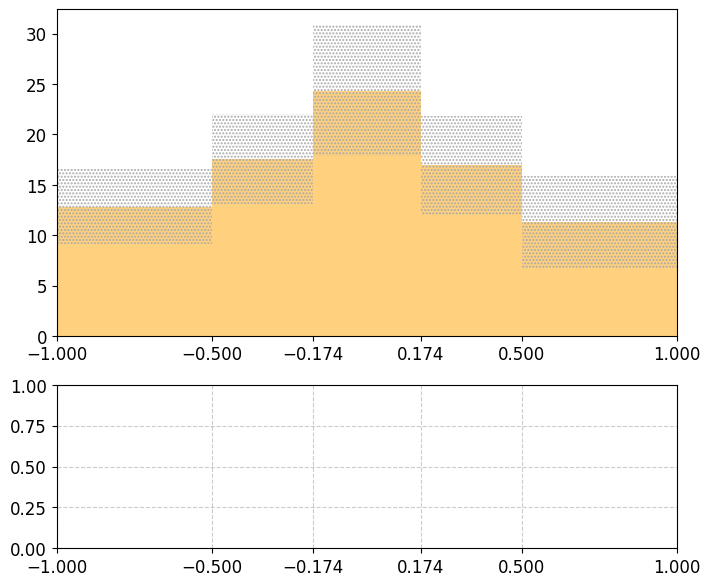

In [109]:
fig = plt.figure(figsize=(8, 7))

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
    
ax1.tick_params(axis='x', which='major', labelsize=12)  # Adjust labelsize to make x-axis tick labels smaller
ax2.tick_params(axis='x', which='major', labelsize=12)  # Adjust labelsize to make x-axis tick labels smaller
ax1.tick_params(axis='y', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)
    
ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)

ax1.set_xticks(x_ticks)
ax2.set_xticks(x_ticks)

ax1.set_xlim(bins[0], xhigh)
ax2.set_xlim(bins[0], xhigh)


############# GENIE PREDICTION #############

n_genie = ax1.hist(bincenters, bins, histtype='bar', weights=evt_rate, color='orange', alpha=0.5,
            label='Signal: '+str(round(sum(evt_rate), 1)))[0]

#genie_frac_stat_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
#for i in range(len(bins)-1): 
    #genie_frac_stat_cov[i][i] = (fhc_dict['mc_signal_sumw2'][i]+rhc_dict['mc_signal_sumw2'][i])/(n_genie[i]**2)

#sim_err = [x*y for x, y in zip(n_genie, np.sqrt(np.diag(genie_frac_stat_cov)))]

sim_err = [x*y for x, y in zip(n_genie, np.sqrt(np.diag(tot_frac_cov)))]

low_err = [ x-y for x,y in zip(n_genie, sim_err) ]
low_err.insert(0, low_err[0])

high_err = [ x+y for x,y in zip(n_genie, sim_err)]
high_err.insert(0, high_err[0])

print(low_err)
print(high_err)

ax1.fill_between(bins, low_err, high_err, step="pre",
                    facecolor=(.25, .25, .25, 0), 
                     edgecolor='darkgray', 
                     hatch='.....', 
                     linewidth=0.0, zorder=2, 
                     label='MC+EXT Stat.\n& Sys. Uncertainty')
#                     label='Stat. Uncertainty')

############# CHI2 CALCULATION #############

# include genie stat covariance
cov_chi2 = np.array(tot_abs_cov) #+ np.array(genie_frac_stat_cov)

# convert to absolute units
#for i in range(len(bins)-1): 
#     for j in range(len(bins)-1): 
#            cov_chi2[i][j] = cov_chi2[i][j] * (n_genie[i] **2)

inverse_cov_chi2 = np.linalg.inv(cov_chi2)
chi2 = 0

for i in range(len(bins)-1): 
    for j in range(len(bins)-1): 
            chi2 = chi2  + ( (n_genie[i]-beamon_counts[i])*inverse_cov_chi2[i][j]*(n_genie[j]-beamon_counts[j]) )


    
############# DATA RESULT #############

ax1.errorbar(bincenters, beamon_counts, yerr=np.sqrt(np.diag(tot_abs_cov)), xerr=x_err, 
             color="black", fmt='o', markersize=3, 
             label='NuMI Data: '+str(int(sum(beamon_counts))))[0]

ax1.step(list(bins)+[0], [0]+list(n_genie)+[0], 
         color='saddlebrown', linewidth=1, alpha=0.85)


########## RATIO ###############################

ax2.errorbar(bincenters, [x/y for x,y in zip(beamon_counts,n_genie)], 
             yerr=get_ratio_err(beamon_counts, n_genie), 
             xerr=x_err, color="black", fmt='o')

#low_err_ratio = [ 1 - x for x in np.sqrt(np.diag(genie_frac_stat_cov)) ]
#low_err_ratio.insert(0, low_err_ratio[0])
    
#high_err_ratio = [ 1 + x for x in np.sqrt(np.diag(genie_frac_stat_cov)) ]
#high_err_ratio.insert(0, high_err_ratio[0])

# MC ratio error - stat + sys 
low_err_ratio = [ 1 - x for x in np.sqrt(np.diag(tot_frac_cov)) ]
low_err_ratio.insert(0, low_err_ratio[0])
    
high_err_ratio = [ 1 + x for x in np.sqrt(np.diag(tot_frac_cov)) ]
high_err_ratio.insert(0, high_err_ratio[0])

ax2.fill_between(bins, low_err_ratio, high_err_ratio, step="pre", facecolor=(.25, .25, .25, 0), 
                     edgecolor='darkgray',
                     hatch='.....', 
                     linewidth=0.0, zorder=1)


######### FORMATTING ############################
#plt.xticks(x_ticks, fontsize=13)
#plt.yticks(fontsize=13)

ax2.set_xlabel('Reconstructed '+x_label, fontsize=15)


ax2.set_ylim(0, 2)
#ax2.set_yticks([0, .5, 1, 1.5, 2])
ax1.set_ylim(0, 175)
ax2.set_ylabel("Data / Prediction", fontsize=15)
ax2.axhline(1.0, color='black', lw=1, linestyle='--')

# ax1.set_title("FHC+RHC Background-Subtracted Event Rate", fontsize=15)
ax1.set_ylabel("Events / Bin ", fontsize=15)
   
ax1.legend(frameon=False, fontsize=12)

#ax1.text(xlow+0.02, 50, 
         #"MicroBooNE Data: 7.0 $\\times 10^{20}$ POT \n $\\chi^{2}$/n = "+str(round(chi2, 1))+"/"+str(len(bins)-1), 
         #fontsize=13.5)

ax1.text(0.03, 0.82, 
         "MicroBooNE FHC+RHC: $7.0\\times10^{20}$ POT\n$\\chi^{2}/n$ = "+str(round(chi2, 1))+"/"+str(len(bins)-1), 
                 fontsize=13.5, transform=ax1.transAxes, horizontalalignment='left')

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/"+xvar+"_evtrate_sub_NewFluxWeights.pdf", bbox_inches='tight')#, dpi=1000)

#plt.savefig("/exp/uboone/app/users/abarnard/NoBkgEvtRate_"+xvar+".svg", bbox_inches='tight')#, dpi=1000)

plt.show()

print("Event Rates:", np.round(beamon_counts, 2))

In [ ]:
beamon_counts

In [110]:
from scipy.stats import chi2, norm

# make a new inverse matrix to use -- delete everything but the first bin
inv = np.delete(np.array(tot_abs_cov), obj=[i for i in range(len(bincenters)) if i>0], axis=0)
inv = np.linalg.inv(np.delete(inv, obj=[i for i in range(len(bincenters)) if i>0], axis=1))

chi_2 = 0

for i in range(len(inv)): 
    for j in range(len(inv)): 
            chi_2 = chi_2  + ( (n_genie[i]-beamon_counts[i])*inv[i][j]*(n_genie[j]-beamon_counts[j]) )


print('chi2 -- first bin ONLY :')  
print(round(chi_2,1), '(reduced = '+str(round(chi_2/len(inv),1))+')')

chi_squared = chi_2
degrees_of_freedom = 1
p_value = 1 - chi2.cdf(chi_squared, degrees_of_freedom)

sigma = norm.ppf(1 - p_value / 2)

# Print results
print(f"P-value: {round(p_value, 5)}")
print(f"Sigma: {round(sigma, 1)}")


NameError: name 'beamon_counts' is not defined

## Smearing & efficiency 

In [86]:
# Make sure to change the date to the ones you want to use!
if isNuWro:
    # Files for NuWro
    with open('unfolding/smearing/FHC_'+xvar+'_021225.json') as f_fhc:
        fhc_smearing_dict = json.load(f_fhc)
    with open('unfolding/smearing/FHC_'+xvar+'_021225.json') as f_rhc:
        rhc_smearing_dict = json.load(f_rhc)

else:
    # Default files
    with open('unfolding/smearing/FHC_'+xvar+'_021225.json') as f_fhc:
        fhc_smearing_dict = json.load(f_fhc)
    with open('unfolding/smearing/FHC_'+xvar+'_021225.json') as f_rhc:
        rhc_smearing_dict = json.load(f_rhc)

In [87]:
xvar

'shr_energy_cali'

In [88]:
fhc_true_generated_intrinsic = generated_signal(False, true_var, bins, xlow, xhigh, weight='totweight_intrinsic')[0]
rhc_true_generated_intrinsic = generated_signal(True, true_var, bins, xlow, xhigh, weight='totweight_intrinsic')[0]
true_generated_intrinsic = [a+b for a,b in zip(fhc_true_generated_intrinsic,rhc_true_generated_intrinsic)]

Adding pot_scale column using dirt & EXT tune....
Adding pot_scale column using dirt & EXT tune....


FHC Efficiency (%) =  [3.9, 12.1, 15.8, 17.4, 16.1, 12.9]


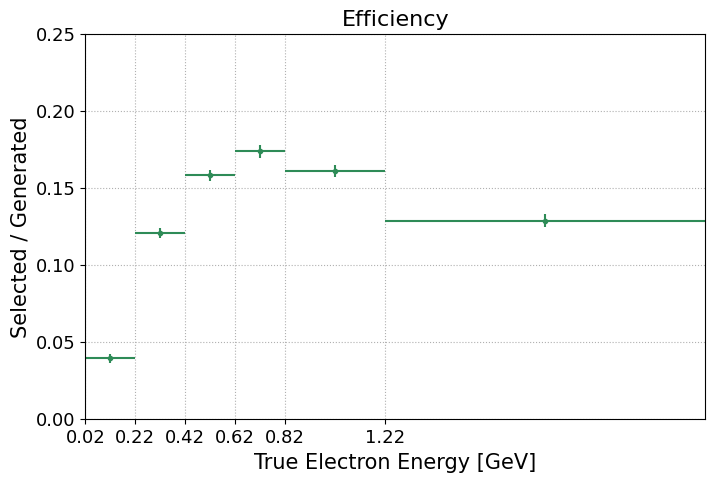

In [89]:
###########################################################################################

# fhc efficiency 
fhc_true_generated = fhc_smearing_dict['true_generated']
fhc_true_selected = fhc_smearing_dict['true_selected']

fhc_eff = [a/b for a,b in zip(fhc_true_selected, fhc_true_generated)]
fhc_eff_err = [ np.sqrt( (x*(1-x)) / y ) for x,y in zip(fhc_eff,fhc_true_generated_intrinsic) ]

print('FHC Efficiency (%) = ', [round(x,3)*100 for x in fhc_eff])


fig = plt.figure(figsize=(8, 5))  

plt.errorbar(bincenters, fhc_eff, yerr=fhc_eff_err, xerr=binwidth, fmt='.', color='seagreen')

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.ylim(0, .25)

plt.xlabel("True " + x_label, fontsize=15)
plt.ylabel("Selected / Generated", fontsize=15)

plt.xlim(bins[0], xhigh)

plt.title("Efficiency", fontsize=16)

plt.grid(linestyle=':')

plt.show()

RHC Efficiency (%) =  [3.9, 12.1, 15.8, 17.4, 16.1, 12.9]
Combined Efficiency (%) =  [3.9, 12.1, 15.8, 17.4, 16.1, 12.9]


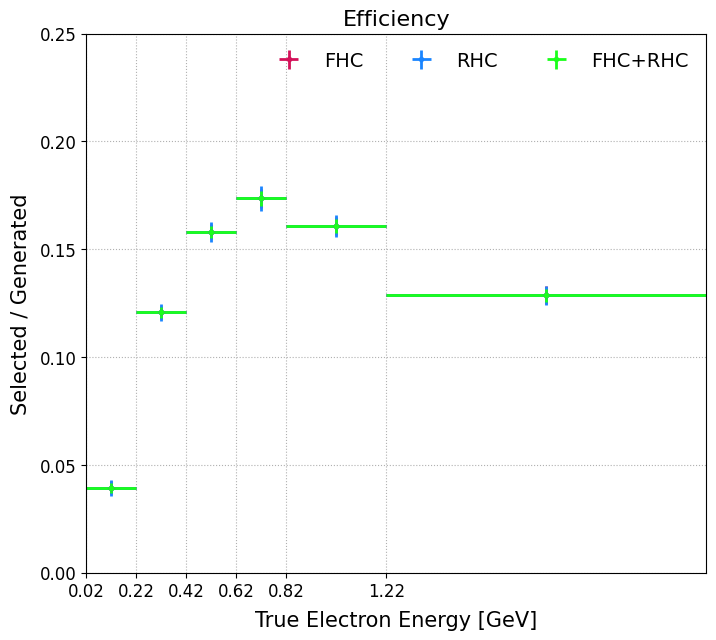

In [90]:


###########################################################################################

# rhc efficiency 
rhc_true_generated = rhc_smearing_dict['true_generated']
rhc_true_selected = rhc_smearing_dict['true_selected']

rhc_eff = [a/b for a,b in zip(rhc_true_selected, rhc_true_generated)]
rhc_eff_err = [ np.sqrt( (x*(1-x)) / y ) for x,y in zip(rhc_eff,rhc_true_generated_intrinsic) ]

print('RHC Efficiency (%) = ', [round(x,3)*100 for x in rhc_eff])

###########################################################################################

# combined efficiency 

true_generated = [a+b for a,b in zip(fhc_smearing_dict['true_generated'], rhc_smearing_dict['true_generated'])]
true_selected = [a+b for a,b in zip(fhc_smearing_dict['true_selected'], rhc_smearing_dict['true_selected'])]

eff = [a/b for a,b in zip(true_selected, true_generated)]
eff_err = [ np.sqrt( (x*(1-x)) / y ) for x,y in zip(eff,true_generated_intrinsic) ]

print('Combined Efficiency (%) = ', [round(x,3)*100 for x in eff])


# Plot 

#fig = plt.figure(figsize=(8, 5))  
fig = plt.figure(figsize=(8, 7))

plt.errorbar(bincenters, fhc_eff, yerr=fhc_eff_err, xerr=binwidth, label="FHC", fmt='.', color='#D41159', linewidth=2)
plt.errorbar(bincenters, rhc_eff, yerr=rhc_eff_err, xerr=binwidth, label="RHC", fmt='.', color='#1A85FF', linewidth=2)

plt.errorbar(bincenters, eff, yerr=eff_err, xerr=binwidth, label="FHC+RHC", fmt='.', color='#1AFF1A', linewidth=2)

plt.xticks(x_ticks, fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0, .25)

plt.xlabel("True " + x_label, fontsize=15, labelpad=7)
plt.ylabel("Selected / Generated", fontsize=15, labelpad=7)

plt.xlim(bins[0], xhigh)

plt.legend(fontsize=14, frameon=False, ncol=3)
plt.title("Efficiency", fontsize=16)

plt.grid(linestyle=':')

#plt.savefig("/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/plots/combined/"+xvar+"_efficiency_comparison.svg", bbox_inches='tight')


plt.show()

In [91]:
response_matrix = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
smearing_matrix = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

fhc_response_matrix = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
rhc_response_matrix = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

true_generated = [a+b for a,b in zip(fhc_true_generated,rhc_true_generated)]

for x in range(len(bins)-1): # the column
    for y in range(len(bins)-1): # the row
        
        fhc_response_matrix[x][y] = fhc_smearing_dict['smearing_matrix'][x][y] / fhc_smearing_dict['true_generated'][x]

        #if not isNuWro: 
        smearing_matrix[x][y] = (fhc_smearing_dict['smearing_matrix'][x][y] + rhc_smearing_dict['smearing_matrix'][x][y])
            
        response_matrix[x][y] =  smearing_matrix[x][y] / true_generated[x]

        rhc_response_matrix[x][y] = rhc_smearing_dict['smearing_matrix'][x][y] / rhc_smearing_dict['true_generated'][x]

In [92]:
## check that R * true generated = reco selected

# matmul does row multiplication, so need to transpose
np.round(np.matmul(np.array(response_matrix).T, true_generated),5) == np.round(evt_rate,5)

array([ True,  True,  True,  True,  True,  True])

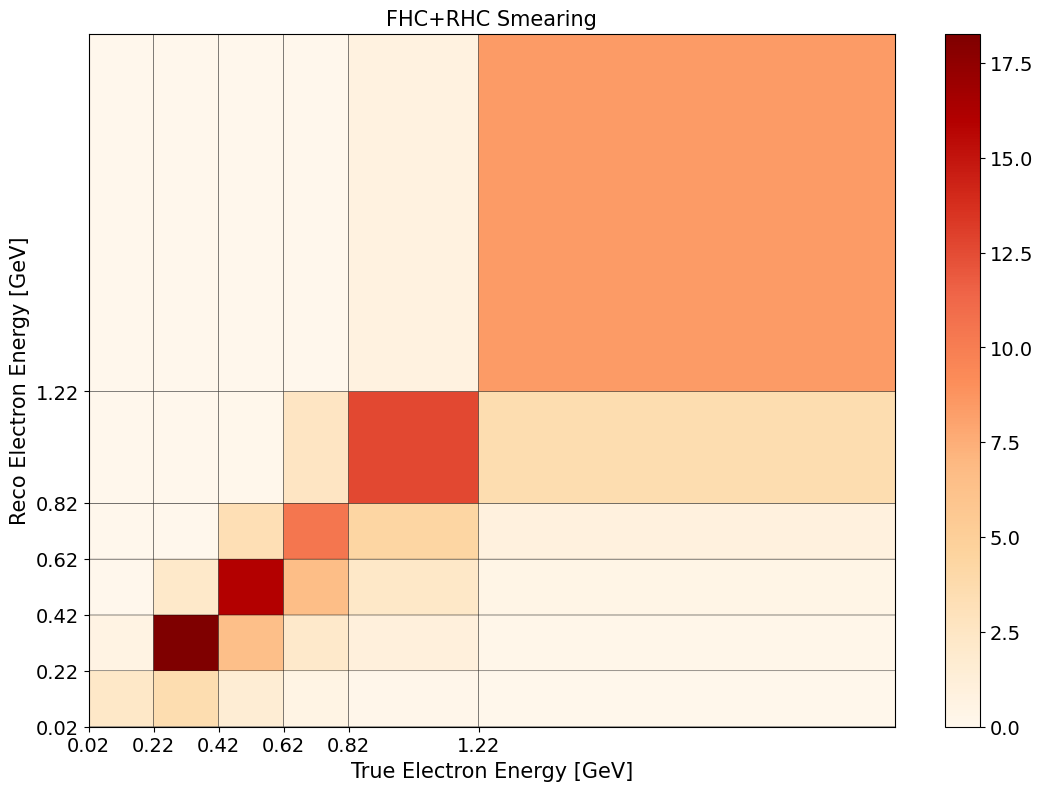

In [93]:
fig = plt.figure(figsize=(13, 9))

plt.pcolor(bins, bins, np.array(smearing_matrix).T, cmap='OrRd', vmin=0.00000000001, edgecolors='k')

plt.title('FHC+RHC Smearing', fontsize=15)

plt.xticks(x_ticks, fontsize=14)
plt.gca().xaxis.tick_bottom()
plt.yticks(x_ticks, fontsize=14)

plt.xlim(bins[0], xhigh)
plt.ylim(bins[0], xhigh)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.xlabel('True '+x_label, fontsize=15)
plt.ylabel('Reco '+x_label, fontsize=15)

plt.show()

# Response Matrix

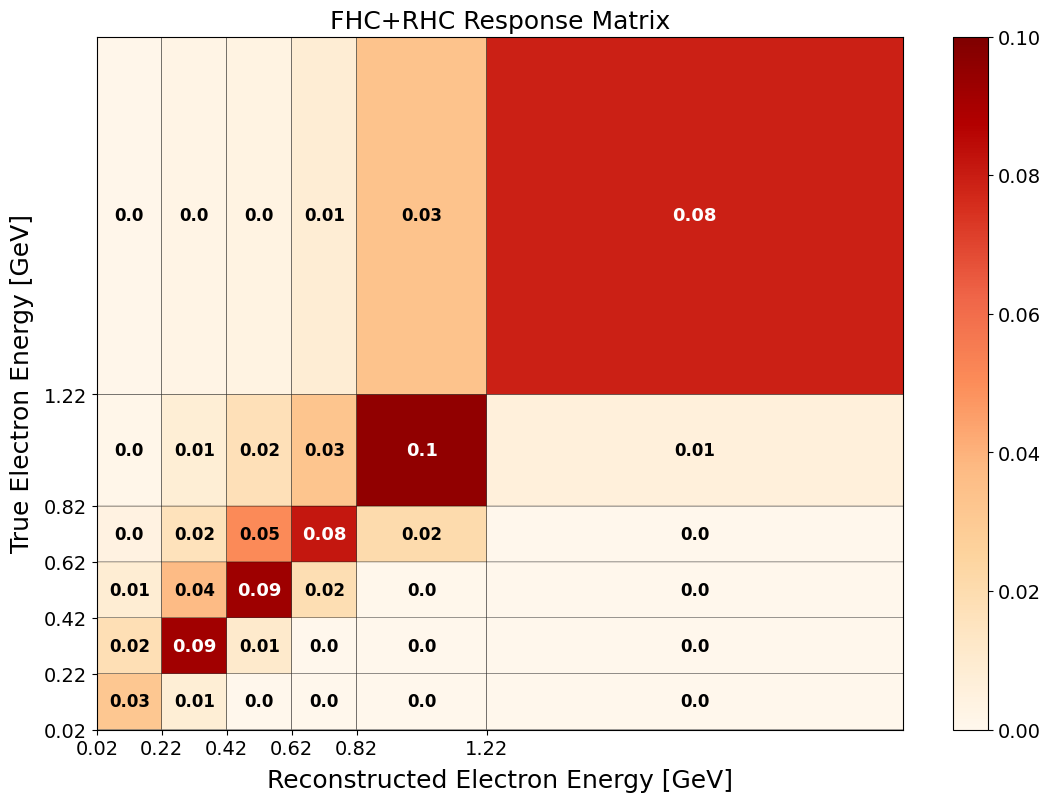

Combined Efficiency (%) =  [3.9, 12.1, 15.8, 17.4, 16.1, 12.9]


In [94]:
#fig = plt.figure(figsize=(10, 6))
fig = plt.figure(figsize=(13, 9))

# pcolor transposes, so account for this - 
plt.pcolor(bins, bins, np.array(response_matrix), cmap='OrRd', edgecolors='k', vmin=0, vmax=.10)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
#cbar.set_label("$\\nu$ / 2 $\\times$ 10$^{20}$ POT (normalized)", fontsize=15)

plt.xticks(x_ticks, fontsize=14)
plt.yticks(x_ticks, fontsize=14)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

plt.xlabel("Reconstructed "+x_label, fontsize=18, labelpad=7)
plt.ylabel("True "+x_label, fontsize=18, labelpad=7)

#for x in range(len(bins)-1): 
    #for y in range(len(bins)-1): 

        #if not np.isnan(np.array(response_matrix).T[x][y]):
            #plt.text(bincenters[x], bincenters[y], round(np.array(response_matrix).T[x][y], 2), 
                        #color='black', ha="center", va="center", fontsize=13, fontweight='bold')
            

for x in range(len(bins)-1): 
    for y in range(len(bins)-1):           

        if not np.isnan(np.array(response_matrix).T[x][y]): 
            if round(np.array(response_matrix).T[x][y],2)>.06 :
                plt.text(bincenters[x], bincenters[y], round(np.array(response_matrix).T[x][y], 2), 
                        color='white', ha="center", va="center", fontsize=13, fontweight='bold')
            else: 
                plt.text(bincenters[x], bincenters[y], round(np.array(response_matrix).T[x][y], 2), 
                        color='black', ha="center", va="center", fontsize=12, fontweight='bold')



plt.title('FHC+RHC Response Matrix', fontsize=18)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/"+xvar+"_rmatrix.pdf", 
#                transparent=True, bbox_inches='tight') 

#plt.savefig("/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/plots/combined/Response_Matrix_"+xvar+".pdf", transparent=False, bbox_inches='tight')

plt.show()

print('Combined Efficiency (%) = ', [round(x,3)*100 for x in eff])

In [95]:
# to get reco bin y, loop over the column 

for y in range(len(bins)-1): 
    s = 0
    for x in range(len(bins)-1): # loop over the column
        s = s + response_matrix[x][y] * true_generated[x]
    print(s)   

8.342866308256163
28.767926167684745
27.429643935712157
19.011552176043136
18.983523765095907
9.255458726810637


In [96]:
evt_rate

[8.342866320930264,
 28.76792621070946,
 27.42964390413956,
 19.011552148940567,
 18.983523786182786,
 9.25545869662011]

## save the input covariance breakdown 

In [97]:
isClosureTest

True

In [98]:
if isClosureTest and isNuWro==False:

    cov_path = 'unfolding/covariance/closuretests/'
    #cov_file = xvar+"_Combined_abs_inputcov_ClosureTest.json"

    #if os.path.exists(cov_path+cov_file): 
    #    print(cov_path+cov_file, "exists and is readable, need to update file name to save ! ")

    #else:       
    #    with open(cov_path+cov_file, 'w') as f:
    #            json.dump(abs_cov_dict, f)
                
                
    cov_file_fhc = xvar+"_FHC_abs_inputcov_ClosureTest.json"
    
    if os.path.exists(cov_path+cov_file_fhc): 
        print(cov_path+cov_file_fhc, "exists and is readable, need to update file name to save ! ")
        
    else:       
        with open(cov_path+cov_file_fhc, 'w') as f_fhc:
                json.dump(fhc_abs_cov_dict, f_fhc)

In [100]:
if isNuWro==True:

    cov_path = 'unfolding/covariance/fakedata/'
    cov_file = xvar+"_FHC_abs_inputcov_NuWro.json"

    if os.path.exists(cov_path+cov_file): 
        print(cov_path+cov_file, "exists and is readable, need to update file name to save ! ")

    else:       
        with open(cov_path+cov_file, 'w') as f:
                json.dump(fhc_abs_cov_dict, f)

## Save to unfolding file (toggle on/off)

In [101]:
# Path has been changed to my path (and set to save!)
save = True
path = "/Users/patrick/Documents/MicroBooNE/CrossSections/NueCCNp_Analysis/uB_NuMI_CC_Np/unfolding/unblinded/"

In [102]:
xvar

'shr_energy_cali'

In [103]:
fhc_response_matrix_T = np.array(fhc_response_matrix).T
print(fhc_response_matrix_T)
print(np.array(fhc_response_matrix))

[[0.03138676 0.01809077 0.00890812 0.00427712 0.00152385 0.00085309]
 [0.00803442 0.09151865 0.03719721 0.01659909 0.00796767 0.00253436]
 [0.         0.01103186 0.09236117 0.05100007 0.01724766 0.00372609]
 [0.         0.         0.01912718 0.08132852 0.0325574  0.00849538]
 [0.         0.         0.00050143 0.02035303 0.09541583 0.0338296 ]
 [0.         0.         0.         0.         0.00619864 0.07921761]]
[[0.03138676 0.00803442 0.         0.         0.         0.        ]
 [0.01809077 0.09151865 0.01103186 0.         0.         0.        ]
 [0.00890812 0.03719721 0.09236117 0.01912718 0.00050143 0.        ]
 [0.00427712 0.01659909 0.05100007 0.08132852 0.02035303 0.        ]
 [0.00152385 0.00796767 0.01724766 0.0325574  0.09541583 0.00619864]
 [0.00085309 0.00253436 0.00372609 0.00849538 0.0338296  0.07921761]]


In [104]:
########### true signal distribution ###########
fhc_htrue_signal = TH1F("htrue_signal", "Generated MC Signal vs. True "+x_label+" ("+true_var+")", len(bins)-1, np.array(bins))

for i in range(len(bincenters)): 
    
    # use genie true generated as input for both closure tests and fake data studies
    fhc_htrue_signal.Fill(bincenters[i], fhc_smearing_dict['true_generated'][i])
        
        
########### reco distribution (MC or data) ###########
fhc_hreco = TH1F("hmeas", "Selected MC Signal vs. Reco "+x_label+" ("+xvar+")", len(bins)-1, np.array(bins))
for i in range(len(bincenters)): 
    
    if isNuWro: 
        fhc_hreco.Fill(bincenters[i], fhc_dict['evt_rate_nuwro_ppfx'][i]) 
        print("Filling reco dist. with NuWro counts....")
    elif isClosureTest: 
        fhc_hreco.Fill(bincenters[i], fhc_dict['evt_rate'][i])
        print("Filling reco dist. with GENIE counts....")
    else: # real data! 
        print("Filling reco dist. with real data counts....")
        fhc_hreco.Fill(bincenters[i], fhc_dict['beamon_counts'][i])


########### covariance matrix ###########
fhc_hcov = TH2D("hcov_tot", "Covariance Matrix of Reco "+x_label, 
                len(bins)-1, np.array(bins), len(bins)-1, np.array(bins))


for i in range(len(bincenters)): # i = row (y)
    for j in range(len(bincenters)): # j = column (x) 
       
        fhc_hcov.Fill(bincenters[j], bincenters[i], fhc_tot_abs_cov[i][j])

    
########### response matrix ###########
fhc_r = TH2D("hR", "Response Matrix", len(bins)-1, np.array(bins), len(bins)-1, np.array(bins))
for i in range(len(bincenters)): # i = column (x)
    for j in range(len(bincenters)): # j = row (y) 
        fhc_r.Fill(bincenters[i], bincenters[j], fhc_response_matrix_T[i][j]) 
            

Filling reco dist. with NuWro counts....
Filling reco dist. with NuWro counts....
Filling reco dist. with NuWro counts....
Filling reco dist. with NuWro counts....
Filling reco dist. with NuWro counts....
Filling reco dist. with NuWro counts....


In [105]:
htrue_signal_values = np.array([fhc_htrue_signal.GetBinContent(bin) for bin in range(1, fhc_htrue_signal.GetNbinsX() + 1)])
hreco_values = np.array([fhc_hreco.GetBinContent(bin) for bin in range(1, fhc_hreco.GetNbinsX() + 1)])
hR_values = np.array([[fhc_r.GetBinContent(bin_x, bin_y) 
                        for bin_y in range(1, fhc_r.GetNbinsY() + 1)]
                        for bin_x in range(1, fhc_r.GetNbinsX() + 1)])

# closure
print(np.matmul(hR_values, htrue_signal_values))
print(hreco_values)

[ 4.17143323 14.38396335 13.71482187  9.50577622  9.49176199  4.62772924]
[ 4.29189205 13.67711067 12.77817726  7.73893166  7.59952688  3.68934703]


In [107]:
# Determine the save file name based on isNuWro
if isNuWro:
    fhc_filename = "WSVD_"+xvar+"_FHC_NuWro_"+date.today().strftime("%m%d%y")+".root"
else:
    fhc_filename = "WSVD_"+xvar+"_FHC_"+date.today().strftime("%m%d%y")+".root"

if os.path.exists(path+fhc_filename): 
    print(path+fhc_filename, "exists and is readable, need to update file name to save!")
        
elif save: 
    fhc_f = ROOT.TFile.Open(path+fhc_filename, "NEW")

    fhc_f.cd()

    fhc_hcov.Write()
    fhc_htrue_signal.Write()
    fhc_hreco.Write()
    fhc_r.Write()

    # Include the individual covariances
    for key in fhc_abs_cov_dict.keys(): 
        h = TH2D(key, "Covariance Matrix of Reco "+x_label + " - "+key, 
                    len(bins)-1, np.array(bins), len(bins)-1, np.array(bins))
        
        for i in range(len(bincenters)):  # i = row (y)
            for j in range(len(bincenters)):  # j = column (x)
                h.Fill(bincenters[j], bincenters[i], fhc_abs_cov_dict[key][i][j])
        h.Write()

    fhc_f.Close()

In [108]:
fhc_abs_cov_dict.keys()

dict_keys(['genie_ms', 'genie_us', 'response_matrix', 'stat'])

In [109]:
fhc_smearing_dict['true_generated']

[37.38995279317464,
 99.80981090014366,
 86.4593379915033,
 64.4000072570546,
 66.41697559589346,
 53.220929881038956]

In [110]:
fhc_dict['evt_rate_nuwro_ppfx']

[4.291892186282633,
 13.677110556046443,
 12.778177615618297,
 7.738931621560335,
 7.599526958042148,
 3.689347050180714]

In [111]:
fhc_response_matrix

[[0.031386758747891624, 0.00803442222696114, 0.0, 0.0, 0.0, 0.0],
 [0.018090765750052366,
  0.09151865190576734,
  0.011031858365129607,
  0.0,
  0.0,
  0.0],
 [0.008908116744199716,
  0.03719720927574088,
  0.09236117483766132,
  0.019127176780177106,
  0.0005014296955087994,
  0.0],
 [0.004277117031966476,
  0.016599087866485215,
  0.05100006849887741,
  0.08132851671681926,
  0.020353025130677882,
  0.0],
 [0.001523846035528366,
  0.007967669039351402,
  0.017247664617395887,
  0.03255739843541034,
  0.09541582627289187,
  0.0061986358724419885],
 [0.0008530916024500623,
  0.0025343624677318746,
  0.003726085526862639,
  0.008495380348531013,
  0.03382960492990345,
  0.07921760715871216]]

In [112]:
np.round(np.matmul(np.array(fhc_response_matrix).T, fhc_smearing_dict['true_generated']),5) == np.round(fhc_dict['evt_rate_nuwro_ppfx'],5)

array([False, False, False, False, False, False])

In [113]:
print(np.matmul(np.array(fhc_response_matrix).T, fhc_smearing_dict['true_generated']))
print(fhc_dict['evt_rate_nuwro_ppfx'])

[ 4.17143315 14.38396308 13.71482197  9.50577609  9.49176188  4.62772936]
[4.291892186282633, 13.677110556046443, 12.778177615618297, 7.738931621560335, 7.599526958042148, 3.689347050180714]


In [114]:
path+fhc_filename

'/Users/patrick/Documents/MicroBooNE/CrossSections/NueCCNp_Analysis/uB_NuMI_CC_Np/unfolding/unblinded/WSVD_shr_energy_cali_FHC_NuWro_021225.root'

In [135]:
# covariance matrix 
rhc_hcov = TH2D("hcov_tot", "Covariance Matrix vs. Reco "+x_label, 
            len(bins)-1, np.array(bins), len(bins)-1, np.array(bins))

for i in range(len(bincenters)): # i = row (y)
    for j in range(len(bincenters)): # j = column (x) 

        rhc_hcov.Fill(bincenters[j], bincenters[i], rhc_tot_abs_cov[i][j]) 

# true signal distribution
rhc_htrue_signal = TH1F("htrue_signal", "Generated MC Signal vs. True "+x_label+" ("+true_var+")", len(bins)-1, np.array(bins))

for i in range(len(bincenters)): 
    rhc_htrue_signal.Fill(bincenters[i], rhc_smearing_dict['true_generated'][i])
        
# reco distribution (MC or data)
rhc_hreco = TH1D("hmeas", "Selected MC Signal vs. Reco "+x_label+" ("+xvar+")", len(bins)-1, np.array(bins))

for i in range(len(bincenters)): 
    
    if isClosureTest: 
        rhc_hreco.Fill(bincenters[i], rhc_dict['evt_rate'][i])
    else: # real data! 
        print("Filling reco dist. with real data counts....")
        rhc_hreco.Fill(bincenters[i], rhc_dict['beamon_counts'][i])
    
# response matrix 
rhc_r = TH2D("hR", "Response Matrix", len(bins)-1, np.array(bins), len(bins)-1, np.array(bins))

for i in range(len(bincenters)): # i = column (x)
    for j in range(len(bincenters)): # j = row (y) 
            
        rhc_r.Fill(bincenters[i], bincenters[j], rhc_response_matrix[i][j]) 
            

Warning in <TROOT::Append>: Replacing existing TH1: hcov_tot (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: htrue_signal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hmeas (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hR (Potential memory leak).


In [136]:
# Determine the save file name based on isNuWro
if isNuWro:
    rhc_filename = "WSVD_"+xvar+"_RHC_NuWro_"+date.today().strftime("%m%d%y")+".root"
else:
    rhc_filename = "WSVD_"+xvar+"_RHC_"+date.today().strftime("%m%d%y")+".root"

if os.path.exists(path+rhc_filename): 
    print(rhc_filename, " exists and is readable, need to update file name to save!")
        
elif save: 
    rhc_f = ROOT.TFile.Open(path+rhc_filename, "RECREATE")

    rhc_f.cd()
    rhc_hcov.Write()
    rhc_htrue_signal.Write()
    rhc_hreco.Write()
    rhc_r.Write()

    rhc_f.Close()

WSVD_tksh_angle_RHC_NuWro_021125.root  exists and is readable, need to update file name to save!


In [135]:
np.round(np.array(tot_abs_cov),5) == np.round(np.array(tot_abs_cov).T, 5)

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [136]:
bincenters

array([-0.75 , -0.337,  0.   ,  0.337,  0.75 ])

In [137]:
# covariance matrix 
hcov = TH2D("hcov_tot", "Covariance Matrix vs. Reco "+x_label, 
            len(bins)-1, np.array(bins), len(bins)-1, np.array(bins))

for x in range(len(bincenters)): 
    for y in range(len(bincenters)): 

        hcov.Fill(bincenters[x], bincenters[y], tot_abs_cov[x][y]) 

# true generated signal distribution
htrue_signal = TH1F("htrue_signal", "Generated MC Signal vs. True "+x_label+" ("+true_var+")", len(bins)-1, np.array(bins))

for x in range(len(bincenters)): 
    htrue_signal.Fill(bincenters[x], true_generated[x])
        
# reco selected distribution (MC or data)
hreco = TH1D("hmeas", "Selected Signal vs. Reco "+x_label+" ("+xvar+")", len(bins)-1, np.array(bins))

for x in range(len(bincenters)): 
    if isClosureTest: 
        hreco.Fill(bincenters[x], evt_rate[x])
    else: 
        print("Filling reco dist. with real data counts....")
        hreco.Fill(bincenters[x], beamon_counts[x])

# reco selected distribution (MC)
hreco_genie = TH1D("hreco_genie", "Selected MC Signal vs. Reco "+x_label+" ("+xvar+")", len(bins)-1, np.array(bins))

for x in range(len(bincenters)): 
    hreco_genie.Fill(bincenters[x], evt_rate[x])

# response matrix 
r = TH2D("hR", "Response Matrix", len(bins)-1, np.array(bins), len(bins)-1, np.array(bins))
for x in range(len(bincenters)): # true / column
    for y in range(len(bincenters)): # reco / row
            
        # store the transpose
        r.Fill(bincenters[x], bincenters[y], np.array(response_matrix).T[x][y]) 
            
# Determine the save file name based on isNuWro
if isNuWro:
    filename = "WSVD_"+xvar+"_NuWro_Combined_"+date.today().strftime("%m%d%y")+".root"
else:
    filename = "WSVD_"+xvar+"_Combined_"+date.today().strftime("%m%d%y")+".root"

if os.path.exists(path+filename): 
    print(filename, " exists and is readable, need to update file name to save!")
        
elif save: 
    f = ROOT.TFile.Open(path+filename, "RECREATE")

    f.cd()

    hcov.Write()
    htrue_signal.Write()
    hreco.Write()
    hreco_genie.Write()
    r.Write()

    f.Close()   

print(path)

/Users/patrick/Documents/MicroBooNE/CrossSections/NueCCNp_Analysis/uB_NuMI_CC_Np/unfolding/unblinded/


Warning in <TROOT::Append>: Replacing existing TH1: hcov_tot (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: htrue_signal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hmeas (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hR (Potential memory leak).


## extra/outdated

In [135]:
data_signal = TMatrixD(len(bins)-1,1)

for i in range(len(bins)-1):
    data_signal[i][0] = rhc_dict['beamon_counts'][i]

data_covmat = TMatrixD(len(bins)-1, len(bins)-1)

for i in range(len(bins)-1):
    for j in range(len(bins)-1):
        data_covmat[i][j] = rhc_tot_abs_cov[i][j]


smearcept = TMatrixD(len(bins)-1,len(bins)-1)

for i in range(len(bins)-1):
    for j in range(len(bins)-1):
        smearcept[i][j] = rhc_response_matrix[i][j]

prior_true_signal = TMatrixD(len(bins)-1, 1)

for i in range(len(bins)-1):
    prior_true_signal[i][0] = rhc_smearing_dict['true_generated'][i]
    

# save to file 

filename = "gardiner_WSVD_"+xvar+"_RHC_"+date.today().strftime("%m%d%y")+".root"
    
if os.path.exists(path+filename): 
    print(filename, " exists and is readable, need to update file name to save ! ")
        
else: 
            
    f = ROOT.TFile.Open(path+filename, "RECREATE")
    f.cd()

    data_signal.Write("data_signal")
    data_covmat.Write("data_covmat")
    smearcept.Write("smearcept")
    prior_true_signal.Write("prior_true_signal")

    f.Close() 

In [ ]:
np.sum(beamon_counts)/np.sum(evt_rate)

### compare input vs. output covariance

In [254]:
# get the rotation matrix 

with open('unfolding/results/closuretests/CombinedResults_true_e_visible_112822.json') as f:
        results_dict = json.load(f)

In [ ]:
results_dict.keys()

In [256]:
covrot = np.array(results_dict['covrotation'])

# also need the transpose! 
covrot_t = covrot.transpose()

In [ ]:
# rotate the input covariance 
unfcov = np.matmul( np.matmul(covrot, tot_abs_cov), covrot_t )

fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, unfcov, cmap='OrRd', edgecolors='k')#, vmin=650, vmax=750)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Unfolded "+x_label, fontsize=15)
plt.ylabel("Unfolded "+x_label, fontsize=15)

plt.xticks(x_ticks, fontsize=12)
plt.yticks(x_ticks, fontsize=12)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

plt.title('CovRot * InputCov * CovRot_t', fontsize=15)

plt.show()

In [258]:
## compute the fractional covariance & uncertainty
unfcov_frac = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for i in range(len(bins)-1):
    for j in range(len(bins)-1): 
        unfcov_frac[i][j] = unfcov[i][j]/(evt_rate[i]*evt_rate[j])

In [ ]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, unfcov_frac, cmap='OrRd', edgecolors='k')#, vmin=650, vmax=750)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Unfolded "+x_label, fontsize=15)
plt.ylabel("Unfolded "+x_label, fontsize=15)

plt.xticks(x_ticks, fontsize=12)
plt.yticks(x_ticks, fontsize=12)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

plt.title('Fractional Covariance', fontsize=15)

plt.show()